In [1]:
import os

import numpy as np

import tensorflow as tf
from tensorflow import keras



from RoadDataset import RoadDataset

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
val_datasets_path = "../notebooks/datasets/validation/"
sub_dirs = os.listdir(val_datasets_path)
val_dataset_paths = [[val_datasets_path + sub_dir + "/" + sub_dir + ".csv", val_datasets_path + sub_dir + "/frames/"] for sub_dir in sub_dirs]
val_dataset_paths

[['../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/Tag-Sonne-Wolken-Ausserorts.csv',
  '../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/frames/'],
 ['../notebooks/datasets/validation/Nacht-Schneechaos/Nacht-Schneechaos.csv',
  '../notebooks/datasets/validation/Nacht-Schneechaos/frames/']]

In [4]:
dataset_index = 0
column_names = ['filename','steering_wheel_angle','speed', 'blink_l', 'blink_r']
val_set = RoadDataset(val_dataset_paths[dataset_index][0], val_dataset_paths[dataset_index][1], column_names, batch_size=16)
#val_set.clean()
#val_set.balance()
val_set.normalize()

Loaded dataset with 10474 samples


In [5]:
#model_name = 'diypilot_v1'
#model_name = 'diypilot_v2_epoch_10'
#model_name = 'diypilot_v3_epoch_5'
#model_name = 'openpilot_replica_epoch_59'
#model_name = 'openpilot_replica_mae_epoch_100'
model_name = 'diypilot_v9_small_FC_epoch_3'
loaded_model = keras.models.load_model('./trained_models/' + model_name + '.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 210, 848, 3)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 282, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 102, 138, 16)      2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 69, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 33, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 6, 64)          5

In [6]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from Jetson.autopilot.record.AutopilotGUI import AutopilotGUI

In [7]:
gui = AutopilotGUI()

In [8]:
def show_frame(test_image_index):

    test_sample = val_set.get_frame(test_image_index)
    test_image = test_sample[0]
    test_image_cropped = val_set.get_cropped_frame(test_image_index)[0]
    test_labels = test_sample[1]

    print("Test csv: " + str(test_labels))

    test_data = np.expand_dims(test_image_cropped, axis=0)
    predictions = loaded_model.predict(test_data)

    gui.set_frame(test_image)
    gui.set_show_overlay(True)
    gui.set_engaged(False)
    gui.set_recording(True)

    timestamp = test_labels['filename']
    gui.set_timestring(timestamp)

    velocity = test_labels['speed']
    gui.set_velocity(velocity)

    actual_swa = test_labels['steering_wheel_angle']*90
    gui.set_actual_swa(actual_swa)

    predicted_swa = predictions[0][0]*90
    print("Ground-truth: " +str(actual_swa))
    print("Prediction: " + str(predicted_swa))
    gui.set_predicted_swa(predicted_swa)

    gui.show_jupyter()

In [9]:
import ipywidgets as widgets
frame_slider = widgets.IntSlider(min=0, max=val_set.get_batch_size()*len(val_set)-1, continuous_update=False)

In [10]:
from ipywidgets import interact

interact(show_frame, test_image_index=frame_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='test_image_index', max=10463), …

In [11]:
import cv2
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(model_name + '.avi',fourcc, 15.0, (848,480))

In [63]:
framecount = val_set.get_batch_size()*len(val_set)
ground_truth = []
predictions_list = []
velocity_list = []
for i in range(framecount):
    test_sample = val_set.get_frame(i)
    test_image = test_sample[0]
    test_image_cropped = val_set.get_cropped_frame(i)[0]
    test_labels = test_sample[1]

    print("Test csv: " + str(test_labels))

    test_data = np.expand_dims(test_image_cropped, axis=0)
    predictions = loaded_model.predict(test_data)

    gui.set_frame(test_image)
    gui.set_show_overlay(True)
    gui.set_engaged(False)
    gui.set_recording(True)

    timestamp = test_labels['filename']
    gui.set_timestring(timestamp)

    velocity = test_labels['speed']
    velocity_list.append(velocity)
    gui.set_velocity(velocity)

    actual_swa = test_labels['steering_wheel_angle']*90
    ground_truth.append(actual_swa)
    gui.set_actual_swa(actual_swa)

    predicted_swa = predictions[0][0]*90
    predictions_list.append(predicted_swa)
    print("Ground-truth: " +str(actual_swa))
    print("Prediction: " + str(predicted_swa))
    gui.set_predicted_swa(predicted_swa)
    
    gui.render()
    frame = gui.get_rendered_gui()
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    out.write(rgb_frame.astype(np.uint8))
    
out.release()

Test csv: filename                1609088520.3121.jpg
steering_wheel_angle              -0.314444
speed                                     0
blink_l                                   0
blink_r                                   0
Name: 0, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                1609088520.5036263.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 1, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                1609088520.5699978.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 2, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                1609088520.6284947.jp

Test csv: filename                1609088522.8950016.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 37, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                1609088522.9609795.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 38, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                1609088523.0260782.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 39, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                160

Test csv: filename                1609088525.3633244.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 74, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                1609088525.4422503.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 75, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                1609088525.4905286.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 76, dtype: object
Ground-truth: -28.3
Prediction: -18.803634345531464
Test csv: filename                160

Test csv: filename                1609088527.9576848.jpg
steering_wheel_angle                -0.0264444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 113, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609088528.0296996.jpg
steering_wheel_angle                -0.0264444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 114, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609088528.0962918.jpg
steering_wheel_angle                -0.0264444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 115, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088530.6379318.jpg
steering_wheel_angle                -0.0264444
speed                                    2.542
blink_l                                      0
blink_r                                      0
Name: 153, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609088530.7050905.jpg
steering_wheel_angle                -0.0264444
speed                                    2.542
blink_l                                      0
blink_r                                      0
Name: 154, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609088530.7694128.jpg
steering_wheel_angle                -0.0187778
speed                                    2.542
blink_l                                      0
blink_r                                      0
Name: 155, dtype: object
Ground-truth: -1.6900000000000002
Prediction: -18.803634345531464
Test csv: filename  

Test csv: filename                1609088533.3691156.jpg
steering_wheel_angle                   2.87167
speed                                    5.115
blink_l                                      0
blink_r                                      0
Name: 194, dtype: object
Ground-truth: 258.45
Prediction: -18.803634345531464
Test csv: filename                1609088533.4327006.jpg
steering_wheel_angle                   2.87167
speed                                    5.115
blink_l                                      0
blink_r                                      0
Name: 195, dtype: object
Ground-truth: 258.45
Prediction: -18.803634345531464
Test csv: filename                1609088533.5039396.jpg
steering_wheel_angle                   3.32178
speed                                    5.115
blink_l                                      0
blink_r                                      0
Name: 196, dtype: object
Ground-truth: 298.96
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088535.9775698.jpg
steering_wheel_angle                     5.392
speed                                    1.333
blink_l                                      0
blink_r                                      0
Name: 233, dtype: object
Ground-truth: 485.28
Prediction: -18.803634345531464
Test csv: filename                1609088536.0330148.jpg
steering_wheel_angle                     5.392
speed                                    1.333
blink_l                                      0
blink_r                                      0
Name: 234, dtype: object
Ground-truth: 485.28
Prediction: -18.803634345531464
Test csv: filename                1609088536.102892.jpg
steering_wheel_angle                  5.27233
speed                                   1.333
blink_l                                     0
blink_r                                     0
Name: 235, dtype: object
Ground-truth: 474.51
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088538.7747993.jpg
steering_wheel_angle                  -5.20622
speed                                    3.689
blink_l                                      0
blink_r                                      0
Name: 275, dtype: object
Ground-truth: -468.56
Prediction: -18.803634345531464
Test csv: filename                1609088538.8705413.jpg
steering_wheel_angle                  -5.24733
speed                                    3.689
blink_l                                      0
blink_r                                      0
Name: 276, dtype: object
Ground-truth: -472.26000000000005
Prediction: -18.803634345531464
Test csv: filename                1609088538.9438891.jpg
steering_wheel_angle                  -5.29111
speed                                    4.061
blink_l                                      0
blink_r                                      0
Name: 277, dtype: object
Ground-truth: -476.20000000000005
Prediction: -18.803634345531464
Test

Test csv: filename                1609088541.7434049.jpg
steering_wheel_angle                  -1.24311
speed                                    9.982
blink_l                                      0
blink_r                                      0
Name: 318, dtype: object
Ground-truth: -111.88
Prediction: -18.803634345531464
Test csv: filename                1609088541.8168852.jpg
steering_wheel_angle                     -0.96
speed                                   10.478
blink_l                                      0
blink_r                                      0
Name: 319, dtype: object
Ground-truth: -86.4
Prediction: -18.803634345531464
Test csv: filename                1609088541.8720078.jpg
steering_wheel_angle                 -0.739444
speed                                   10.478
blink_l                                      0
blink_r                                      0
Name: 320, dtype: object
Ground-truth: -66.55
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088544.7779675.jpg
steering_wheel_angle                 0.0528889
speed                                   12.834
blink_l                                      0
blink_r                                      0
Name: 362, dtype: object
Ground-truth: 4.76
Prediction: -18.803634345531464
Test csv: filename                1609088544.917498.jpg
steering_wheel_angle                0.0682222
speed                                  12.834
blink_l                                     0
blink_r                                     0
Name: 363, dtype: object
Ground-truth: 6.139999999999999
Prediction: -18.803634345531464
Test csv: filename                1609088544.9795353.jpg
steering_wheel_angle                 0.0695556
speed                                   12.524
blink_l                                      0
blink_r                                      0
Name: 364, dtype: object
Ground-truth: 6.26
Prediction: -18.803634345531464
Test csv: filename           

Test csv: filename                1609088547.7783158.jpg
steering_wheel_angle                  0.306111
speed                                    2.728
blink_l                                      0
blink_r                                      0
Name: 404, dtype: object
Ground-truth: 27.55
Prediction: -18.803634345531464
Test csv: filename                1609088547.854507.jpg
steering_wheel_angle                 0.306111
speed                                   2.728
blink_l                                     0
blink_r                                     0
Name: 405, dtype: object
Ground-truth: 27.55
Prediction: -18.803634345531464
Test csv: filename                1609088547.9179764.jpg
steering_wheel_angle                  0.306111
speed                                    2.728
blink_l                                      0
blink_r                                      0
Name: 406, dtype: object
Ground-truth: 27.55
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088551.2442138.jpg
steering_wheel_angle                     0.039
speed                                    6.417
blink_l                                      0
blink_r                                      0
Name: 448, dtype: object
Ground-truth: 3.51
Prediction: -18.803634345531464
Test csv: filename                1609088551.3343713.jpg
steering_wheel_angle                 0.0437778
speed                                    6.727
blink_l                                      0
blink_r                                      0
Name: 449, dtype: object
Ground-truth: 3.94
Prediction: -18.803634345531464
Test csv: filename                1609088551.425966.jpg
steering_wheel_angle                0.0437778
speed                                   6.727
blink_l                                     0
blink_r                                     0
Name: 450, dtype: object
Ground-truth: 3.94
Prediction: -18.803634345531464
Test csv: filename                16090885

Test csv: filename                1609088554.008576.jpg
steering_wheel_angle                    0.256
speed                                  16.833
blink_l                                     0
blink_r                                     0
Name: 490, dtype: object
Ground-truth: 23.04
Prediction: -18.803634345531464
Test csv: filename                1609088554.0695636.jpg
steering_wheel_angle                     0.256
speed                                   16.833
blink_l                                      0
blink_r                                      0
Name: 491, dtype: object
Ground-truth: 23.04
Prediction: -18.803634345531464
Test csv: filename                1609088554.137254.jpg
steering_wheel_angle                    0.256
speed                                  16.833
blink_l                                     0
blink_r                                     0
Name: 492, dtype: object
Ground-truth: 23.04
Prediction: -18.803634345531464
Test csv: filename                1609088554

Test csv: filename                1609088556.8175926.jpg
steering_wheel_angle                 -0.206556
speed                                   24.211
blink_l                                      0
blink_r                                      0
Name: 532, dtype: object
Ground-truth: -18.59
Prediction: -18.803634345531464
Test csv: filename                1609088556.864256.jpg
steering_wheel_angle                -0.154444
speed                                  24.211
blink_l                                     0
blink_r                                     0
Name: 533, dtype: object
Ground-truth: -13.9
Prediction: -18.803634345531464
Test csv: filename                1609088556.9285486.jpg
steering_wheel_angle                 -0.154444
speed                                   24.211
blink_l                                      0
blink_r                                      0
Name: 534, dtype: object
Ground-truth: -13.9
Prediction: -18.803634345531464
Test csv: filename                1609

Test csv: filename                1609088559.6679265.jpg
steering_wheel_angle                 0.0522222
speed                                   25.668
blink_l                                      0
blink_r                                      0
Name: 575, dtype: object
Ground-truth: 4.7
Prediction: -18.803634345531464
Test csv: filename                1609088559.7282462.jpg
steering_wheel_angle                 0.0522222
speed                                   25.668
blink_l                                      0
blink_r                                      0
Name: 576, dtype: object
Ground-truth: 4.7
Prediction: -18.803634345531464
Test csv: filename                1609088559.8014045.jpg
steering_wheel_angle                 0.0486667
speed                                   25.358
blink_l                                      0
blink_r                                      0
Name: 577, dtype: object
Ground-truth: 4.38
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088562.471829.jpg
steering_wheel_angle               -0.0501111
speed                                  15.314
blink_l                                     0
blink_r                                     1
Name: 617, dtype: object
Ground-truth: -4.51
Prediction: -18.803634345531464
Test csv: filename                1609088562.5191722.jpg
steering_wheel_angle                -0.0501111
speed                                   15.314
blink_l                                      0
blink_r                                      1
Name: 618, dtype: object
Ground-truth: -4.51
Prediction: -18.803634345531464
Test csv: filename                1609088562.6051466.jpg
steering_wheel_angle                -0.0277778
speed                                   13.423
blink_l                                      0
blink_r                                      1
Name: 619, dtype: object
Ground-truth: -2.5
Prediction: -18.803634345531464
Test csv: filename                160908

Test csv: filename                1609088565.4021392.jpg
steering_wheel_angle                  -2.42778
speed                                    5.177
blink_l                                      0
blink_r                                      1
Name: 661, dtype: object
Ground-truth: -218.49999999999997
Prediction: -18.803634345531464
Test csv: filename                1609088565.4529283.jpg
steering_wheel_angle                  -2.66222
speed                                    5.177
blink_l                                      0
blink_r                                      1
Name: 662, dtype: object
Ground-truth: -239.6
Prediction: -18.803634345531464
Test csv: filename                1609088565.526833.jpg
steering_wheel_angle                 -2.66222
speed                                   5.177
blink_l                                     0
blink_r                                     1
Name: 663, dtype: object
Ground-truth: -239.6
Prediction: -18.803634345531464
Test csv: filename     

Test csv: filename                1609088568.195586.jpg
steering_wheel_angle                 -2.53356
speed                                   13.64
blink_l                                     0
blink_r                                     0
Name: 703, dtype: object
Ground-truth: -228.02
Prediction: -18.803634345531464
Test csv: filename                1609088568.2588046.jpg
steering_wheel_angle                  -2.34433
speed                                    13.64
blink_l                                      0
blink_r                                      0
Name: 704, dtype: object
Ground-truth: -210.99000000000004
Prediction: -18.803634345531464
Test csv: filename                1609088568.32761.jpg
steering_wheel_angle                -2.34433
speed                                  13.64
blink_l                                    0
blink_r                                    0
Name: 705, dtype: object
Ground-truth: -210.99000000000004
Prediction: -18.803634345531464
Test csv: filename 

Test csv: filename                1609088571.0612943.jpg
steering_wheel_angle                 -0.128667
speed                                   24.428
blink_l                                      0
blink_r                                      0
Name: 746, dtype: object
Ground-truth: -11.580000000000002
Prediction: -18.803634345531464
Test csv: filename                1609088571.1234148.jpg
steering_wheel_angle                 -0.128667
speed                                   24.428
blink_l                                      0
blink_r                                      0
Name: 747, dtype: object
Ground-truth: -11.580000000000002
Prediction: -18.803634345531464
Test csv: filename                1609088571.2060971.jpg
steering_wheel_angle                 -0.139111
speed                                     24.8
blink_l                                      0
blink_r                                      0
Name: 748, dtype: object
Ground-truth: -12.52
Prediction: -18.803634345531464
Test 

Test csv: filename                1609088573.8695254.jpg
steering_wheel_angle                 -0.231667
speed                                   26.691
blink_l                                      0
blink_r                                      0
Name: 788, dtype: object
Ground-truth: -20.85
Prediction: -18.803634345531464
Test csv: filename                1609088573.9383607.jpg
steering_wheel_angle                 -0.231667
speed                                   26.691
blink_l                                      0
blink_r                                      0
Name: 789, dtype: object
Ground-truth: -20.85
Prediction: -18.803634345531464
Test csv: filename                1609088573.9958813.jpg
steering_wheel_angle                 -0.231667
speed                                   26.784
blink_l                                      0
blink_r                                      0
Name: 790, dtype: object
Ground-truth: -20.85
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088576.5384293.jpg
steering_wheel_angle                -0.0445556
speed                                   36.611
blink_l                                      0
blink_r                                      0
Name: 828, dtype: object
Ground-truth: -4.01
Prediction: -18.803634345531464
Test csv: filename                1609088576.5964727.jpg
steering_wheel_angle                -0.0452222
speed                                   36.766
blink_l                                      0
blink_r                                      0
Name: 829, dtype: object
Ground-truth: -4.07
Prediction: -18.803634345531464
Test csv: filename                1609088576.67207.jpg
steering_wheel_angle              -0.0465556
speed                                 36.766
blink_l                                    0
blink_r                                    0
Name: 830, dtype: object
Ground-truth: -4.19
Prediction: -18.803634345531464
Test csv: filename                1609088576

Test csv: filename                1609088579.3362644.jpg
steering_wheel_angle                 0.0257778
speed                                   39.928
blink_l                                      0
blink_r                                      0
Name: 870, dtype: object
Ground-truth: 2.32
Prediction: -18.803634345531464
Test csv: filename                1609088579.400191.jpg
steering_wheel_angle                0.0257778
speed                                  39.773
blink_l                                     0
blink_r                                     0
Name: 871, dtype: object
Ground-truth: 2.32
Prediction: -18.803634345531464
Test csv: filename                1609088579.4678783.jpg
steering_wheel_angle                 0.0285556
speed                                   39.773
blink_l                                      0
blink_r                                      0
Name: 872, dtype: object
Ground-truth: 2.57
Prediction: -18.803634345531464
Test csv: filename                16090885

Test csv: filename                1609088582.1439078.jpg
steering_wheel_angle                    -0.025
speed                                   39.215
blink_l                                      0
blink_r                                      0
Name: 912, dtype: object
Ground-truth: -2.25
Prediction: -18.803634345531464
Test csv: filename                1609088582.2030096.jpg
steering_wheel_angle                -0.0264444
speed                                   39.432
blink_l                                      0
blink_r                                      0
Name: 913, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609088582.2637212.jpg
steering_wheel_angle                -0.0285556
speed                                   39.432
blink_l                                      0
blink_r                                      0
Name: 914, dtype: object
Ground-truth: -2.57
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088584.939005.jpg
steering_wheel_angle               -0.0166667
speed                                  41.044
blink_l                                     0
blink_r                                     0
Name: 954, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                1609088585.0063605.jpg
steering_wheel_angle                -0.0166667
speed                                    41.23
blink_l                                      0
blink_r                                      0
Name: 955, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                1609088585.0737154.jpg
steering_wheel_angle                -0.0166667
speed                                    41.23
blink_l                                      0
blink_r                                      0
Name: 956, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                16090885

Test csv: filename                1609088587.6744087.jpg
steering_wheel_angle                 0.0104444
speed                                   41.571
blink_l                                      0
blink_r                                      0
Name: 995, dtype: object
Ground-truth: 0.94
Prediction: -18.803634345531464
Test csv: filename                1609088587.7518172.jpg
steering_wheel_angle                 0.0104444
speed                                   41.571
blink_l                                      0
blink_r                                      0
Name: 996, dtype: object
Ground-truth: 0.94
Prediction: -18.803634345531464
Test csv: filename                1609088587.8055503.jpg
steering_wheel_angle                     0.009
speed                                   41.602
blink_l                                      0
blink_r                                      0
Name: 997, dtype: object
Ground-truth: 0.81
Prediction: -18.803634345531464
Test csv: filename                160

Test csv: filename                1609088590.5500185.jpg
steering_wheel_angle                  0.243444
speed                                    43.09
blink_l                                      0
blink_r                                      0
Name: 1038, dtype: object
Ground-truth: 21.91
Prediction: -18.803634345531464
Test csv: filename                1609088590.6039517.jpg
steering_wheel_angle                  0.244222
speed                                   43.276
blink_l                                      0
blink_r                                      0
Name: 1039, dtype: object
Ground-truth: 21.98
Prediction: -18.803634345531464
Test csv: filename                1609088590.6758604.jpg
steering_wheel_angle                  0.245556
speed                                   43.276
blink_l                                      0
blink_r                                      0
Name: 1040, dtype: object
Ground-truth: 22.1
Prediction: -18.803634345531464
Test csv: filename              

Test csv: filename                1609088593.4139771.jpg
steering_wheel_angle                  0.229556
speed                                   45.229
blink_l                                      0
blink_r                                      0
Name: 1081, dtype: object
Ground-truth: 20.66
Prediction: -18.803634345531464
Test csv: filename                1609088593.4820285.jpg
steering_wheel_angle                  0.229556
speed                                   45.229
blink_l                                      0
blink_r                                      0
Name: 1082, dtype: object
Ground-truth: 20.66
Prediction: -18.803634345531464
Test csv: filename                1609088593.5444021.jpg
steering_wheel_angle                  0.229556
speed                                   45.229
blink_l                                      0
blink_r                                      0
Name: 1083, dtype: object
Ground-truth: 20.66
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088596.2231069.jpg
steering_wheel_angle                  0.230222
speed                                   49.011
blink_l                                      0
blink_r                                      0
Name: 1123, dtype: object
Ground-truth: 20.72
Prediction: -18.803634345531464
Test csv: filename                1609088596.3003776.jpg
steering_wheel_angle                  0.212222
speed                                   49.011
blink_l                                      0
blink_r                                      0
Name: 1124, dtype: object
Ground-truth: 19.1
Prediction: -18.803634345531464
Test csv: filename                1609088596.3475144.jpg
steering_wheel_angle                  0.197556
speed                                   49.352
blink_l                                      0
blink_r                                      0
Name: 1125, dtype: object
Ground-truth: 17.78
Prediction: -18.803634345531464
Test csv: filename              

Test csv: filename                1609088598.968132.jpg
steering_wheel_angle                -0.108556
speed                                  52.824
blink_l                                     0
blink_r                                     0
Name: 1164, dtype: object
Ground-truth: -9.77
Prediction: -18.803634345531464
Test csv: filename                1609088599.053762.jpg
steering_wheel_angle                -0.108556
speed                                  52.824
blink_l                                     0
blink_r                                     0
Name: 1165, dtype: object
Ground-truth: -9.77
Prediction: -18.803634345531464
Test csv: filename                1609088599.0920024.jpg
steering_wheel_angle                 -0.117556
speed                                   52.824
blink_l                                      0
blink_r                                      0
Name: 1166, dtype: object
Ground-truth: -10.58
Prediction: -18.803634345531464
Test csv: filename                160908

Test csv: filename                1609088601.7505133.jpg
steering_wheel_angle                 -0.203111
speed                                   56.854
blink_l                                      0
blink_r                                      0
Name: 1206, dtype: object
Ground-truth: -18.28
Prediction: -18.803634345531464
Test csv: filename                1609088601.8174236.jpg
steering_wheel_angle                 -0.203111
speed                                   56.761
blink_l                                      0
blink_r                                      0
Name: 1207, dtype: object
Ground-truth: -18.28
Prediction: -18.803634345531464
Test csv: filename                1609088601.8861349.jpg
steering_wheel_angle                 -0.203111
speed                                   56.761
blink_l                                      0
blink_r                                      0
Name: 1208, dtype: object
Ground-truth: -18.28
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088604.4831789.jpg
steering_wheel_angle                 -0.185778
speed                                   55.583
blink_l                                      0
blink_r                                      0
Name: 1247, dtype: object
Ground-truth: -16.72
Prediction: -18.803634345531464
Test csv: filename                1609088604.5505106.jpg
steering_wheel_angle                    -0.185
speed                                   55.583
blink_l                                      0
blink_r                                      0
Name: 1248, dtype: object
Ground-truth: -16.65
Prediction: -18.803634345531464
Test csv: filename                1609088604.617226.jpg
steering_wheel_angle                   -0.185
speed                                  55.397
blink_l                                     0
blink_r                                     0
Name: 1249, dtype: object
Ground-truth: -16.65
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609088607.154271.jpg
steering_wheel_angle                -0.303333
speed                                  35.247
blink_l                                     0
blink_r                                     0
Name: 1287, dtype: object
Ground-truth: -27.3
Prediction: -18.803634345531464
Test csv: filename                1609088607.2229865.jpg
steering_wheel_angle                 -0.303333
speed                                   35.247
blink_l                                      0
blink_r                                      0
Name: 1288, dtype: object
Ground-truth: -27.3
Prediction: -18.803634345531464
Test csv: filename                1609088607.2850482.jpg
steering_wheel_angle                 -0.306111
speed                                   35.247
blink_l                                      0
blink_r                                      0
Name: 1289, dtype: object
Ground-truth: -27.55
Prediction: -18.803634345531464
Test csv: filename                1

Test csv: filename                1609088609.8870177.jpg
steering_wheel_angle                  -1.17778
speed                                   21.142
blink_l                                      0
blink_r                                      0
Name: 1328, dtype: object
Ground-truth: -106.0
Prediction: -18.803634345531464
Test csv: filename                1609088609.9662817.jpg
steering_wheel_angle                  -1.20278
speed                                   21.266
blink_l                                      0
blink_r                                      0
Name: 1329, dtype: object
Ground-truth: -108.25
Prediction: -18.803634345531464
Test csv: filename                1609088610.0236845.jpg
steering_wheel_angle                  -1.20278
speed                                   21.266
blink_l                                      0
blink_r                                      0
Name: 1330, dtype: object
Ground-truth: -108.25
Prediction: -18.803634345531464
Test csv: filename        

Test csv: filename                1609088612.5598872.jpg
steering_wheel_angle                  -1.20422
speed                                   27.435
blink_l                                      0
blink_r                                      0
Name: 1368, dtype: object
Ground-truth: -108.37999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088612.6268184.jpg
steering_wheel_angle                  -1.20422
speed                                    28.83
blink_l                                      0
blink_r                                      0
Name: 1369, dtype: object
Ground-truth: -108.37999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088612.688468.jpg
steering_wheel_angle                 -1.10056
speed                                   28.83
blink_l                                     0
blink_r                                     0
Name: 1370, dtype: object
Ground-truth: -99.05
Prediction: -18.803634345531464
Test cs

Test csv: filename                1609088615.493781.jpg
steering_wheel_angle               -0.0917778
speed                                   37.82
blink_l                                     0
blink_r                                     0
Name: 1412, dtype: object
Ground-truth: -8.26
Prediction: -18.803634345531464
Test csv: filename                1609088615.5585861.jpg
steering_wheel_angle                -0.0897778
speed                                    37.82
blink_l                                      0
blink_r                                      0
Name: 1413, dtype: object
Ground-truth: -8.08
Prediction: -18.803634345531464
Test csv: filename                1609088615.6248007.jpg
steering_wheel_angle                -0.0897778
speed                                    38.44
blink_l                                      0
blink_r                                      0
Name: 1414, dtype: object
Ground-truth: -8.08
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088618.4326599.jpg
steering_wheel_angle               -0.00211111
speed                                    52.08
blink_l                                      0
blink_r                                      0
Name: 1456, dtype: object
Ground-truth: -0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088618.5007455.jpg
steering_wheel_angle               -0.00555556
speed                                    52.08
blink_l                                      0
blink_r                                      0
Name: 1457, dtype: object
Ground-truth: -0.5
Prediction: -18.803634345531464
Test csv: filename                1609088618.5579379.jpg
steering_wheel_angle                    -0.009
speed                                    52.08
blink_l                                      0
blink_r                                      0
Name: 1458, dtype: object
Ground-truth: -0.81
Prediction: -18.803634345531464
Test csv: filenam

Test csv: filename                1609088621.2301922.jpg
steering_wheel_angle                 0.0202222
speed                                   55.366
blink_l                                      0
blink_r                                      0
Name: 1498, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088621.2996142.jpg
steering_wheel_angle                 0.0202222
speed                                   55.366
blink_l                                      0
blink_r                                      0
Name: 1499, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088621.3628755.jpg
steering_wheel_angle                 0.0215556
speed                                   55.614
blink_l                                      0
blink_r                                      0
Name: 1500, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -18.80363434

Test csv: filename                1609088623.9606118.jpg
steering_wheel_angle                     0.023
speed                                    57.97
blink_l                                      0
blink_r                                      0
Name: 1539, dtype: object
Ground-truth: 2.07
Prediction: -18.803634345531464
Test csv: filename                1609088624.0394974.jpg
steering_wheel_angle                     0.023
speed                                    57.97
blink_l                                      0
blink_r                                      0
Name: 1540, dtype: object
Ground-truth: 2.07
Prediction: -18.803634345531464
Test csv: filename                1609088624.0984564.jpg
steering_wheel_angle                 0.0236667
speed                                    57.97
blink_l                                      0
blink_r                                      0
Name: 1541, dtype: object
Ground-truth: 2.13
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088626.7078195.jpg
steering_wheel_angle                    -0.009
speed                                   57.877
blink_l                                      0
blink_r                                      0
Name: 1580, dtype: object
Ground-truth: -0.81
Prediction: -18.803634345531464
Test csv: filename                1609088626.7666976.jpg
steering_wheel_angle                -0.0125556
speed                                   57.877
blink_l                                      0
blink_r                                      0
Name: 1581, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609088626.8473704.jpg
steering_wheel_angle                -0.0125556
speed                                    57.97
blink_l                                      0
blink_r                                      0
Name: 1582, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088629.4410446.jpg
steering_wheel_angle                    -0.103
speed                                   54.622
blink_l                                      0
blink_r                                      0
Name: 1621, dtype: object
Ground-truth: -9.27
Prediction: -18.803634345531464
Test csv: filename                1609088629.5048869.jpg
steering_wheel_angle                 -0.103667
speed                                   54.622
blink_l                                      0
blink_r                                      0
Name: 1622, dtype: object
Ground-truth: -9.33
Prediction: -18.803634345531464
Test csv: filename                1609088629.5707388.jpg
steering_wheel_angle                 -0.103667
speed                                   54.157
blink_l                                      0
blink_r                                      0
Name: 1623, dtype: object
Ground-truth: -9.33
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088632.1686513.jpg
steering_wheel_angle                 -0.126556
speed                                   51.336
blink_l                                      0
blink_r                                      0
Name: 1662, dtype: object
Ground-truth: -11.39
Prediction: -18.803634345531464
Test csv: filename                1609088632.249924.jpg
steering_wheel_angle                -0.126556
speed                                  51.336
blink_l                                     0
blink_r                                     0
Name: 1663, dtype: object
Ground-truth: -11.39
Prediction: -18.803634345531464
Test csv: filename                1609088632.3036208.jpg
steering_wheel_angle                 -0.126556
speed                                   51.336
blink_l                                      0
blink_r                                      0
Name: 1664, dtype: object
Ground-truth: -11.39
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609088635.0396464.jpg
steering_wheel_angle                 -0.198222
speed                                   51.274
blink_l                                      0
blink_r                                      0
Name: 1705, dtype: object
Ground-truth: -17.84
Prediction: -18.803634345531464
Test csv: filename                1609088635.106806.jpg
steering_wheel_angle                -0.198222
speed                                  51.274
blink_l                                     0
blink_r                                     0
Name: 1706, dtype: object
Ground-truth: -17.84
Prediction: -18.803634345531464
Test csv: filename                1609088635.1790543.jpg
steering_wheel_angle                 -0.198222
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 1707, dtype: object
Ground-truth: -17.84
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609088637.7757204.jpg
steering_wheel_angle                 -0.179444
speed                                   51.119
blink_l                                      0
blink_r                                      0
Name: 1746, dtype: object
Ground-truth: -16.15
Prediction: -18.803634345531464
Test csv: filename                1609088637.8470793.jpg
steering_wheel_angle                 -0.179444
speed                                   51.119
blink_l                                      0
blink_r                                      0
Name: 1747, dtype: object
Ground-truth: -16.15
Prediction: -18.803634345531464
Test csv: filename                1609088637.910815.jpg
steering_wheel_angle                -0.186444
speed                                  51.119
blink_l                                     0
blink_r                                     0
Name: 1748, dtype: object
Ground-truth: -16.78
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609088640.51057.jpg
steering_wheel_angle               -0.251111
speed                                 48.918
blink_l                                    0
blink_r                                    0
Name: 1787, dtype: object
Ground-truth: -22.6
Prediction: -18.803634345531464
Test csv: filename                1609088640.581166.jpg
steering_wheel_angle                -0.243444
speed                                  48.577
blink_l                                     0
blink_r                                     0
Name: 1788, dtype: object
Ground-truth: -21.91
Prediction: -18.803634345531464
Test csv: filename                1609088640.6501067.jpg
steering_wheel_angle                 -0.233778
speed                                   48.577
blink_l                                      0
blink_r                                      0
Name: 1789, dtype: object
Ground-truth: -21.04
Prediction: -18.803634345531464
Test csv: filename                1609088640

Test csv: filename                1609088643.3820012.jpg
steering_wheel_angle                -0.0556667
speed                                   49.476
blink_l                                      0
blink_r                                      0
Name: 1830, dtype: object
Ground-truth: -5.01
Prediction: -18.803634345531464
Test csv: filename                1609088643.4490328.jpg
steering_wheel_angle                -0.0556667
speed                                   49.476
blink_l                                      0
blink_r                                      0
Name: 1831, dtype: object
Ground-truth: -5.01
Prediction: -18.803634345531464
Test csv: filename                1609088643.506765.jpg
steering_wheel_angle               -0.0556667
speed                                  49.476
blink_l                                     0
blink_r                                     0
Name: 1832, dtype: object
Ground-truth: -5.01
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088646.178594.jpg
steering_wheel_angle                    0.041
speed                                  49.135
blink_l                                     0
blink_r                                     0
Name: 1872, dtype: object
Ground-truth: 3.69
Prediction: -18.803634345531464
Test csv: filename                1609088646.2484598.jpg
steering_wheel_angle                     0.041
speed                                   49.135
blink_l                                      0
blink_r                                      0
Name: 1873, dtype: object
Ground-truth: 3.69
Prediction: -18.803634345531464
Test csv: filename                1609088646.314592.jpg
steering_wheel_angle                0.0486667
speed                                  49.135
blink_l                                     0
blink_r                                     0
Name: 1874, dtype: object
Ground-truth: 4.38
Prediction: -18.803634345531464
Test csv: filename                1609088646

Test csv: filename                1609088648.9836922.jpg
steering_wheel_angle                  0.171111
speed                                   47.244
blink_l                                      0
blink_r                                      0
Name: 1914, dtype: object
Ground-truth: 15.399999999999999
Prediction: -18.803634345531464
Test csv: filename                1609088649.0534759.jpg
steering_wheel_angle                  0.180889
speed                                   47.244
blink_l                                      0
blink_r                                      0
Name: 1915, dtype: object
Ground-truth: 16.28
Prediction: -18.803634345531464
Test csv: filename                1609088649.1138139.jpg
steering_wheel_angle                  0.180889
speed                                   47.244
blink_l                                      0
blink_r                                      0
Name: 1916, dtype: object
Ground-truth: 16.28
Prediction: -18.803634345531464
Test csv: filename

Test csv: filename                1609088651.5862658.jpg
steering_wheel_angle                  0.169778
speed                                   43.524
blink_l                                      0
blink_r                                      0
Name: 1953, dtype: object
Ground-truth: 15.28
Prediction: -18.803634345531464
Test csv: filename                1609088651.6625037.jpg
steering_wheel_angle                  0.167667
speed                                   43.524
blink_l                                      0
blink_r                                      0
Name: 1954, dtype: object
Ground-truth: 15.09
Prediction: -18.803634345531464
Test csv: filename                1609088651.7155893.jpg
steering_wheel_angle                  0.167667
speed                                   43.524
blink_l                                      0
blink_r                                      0
Name: 1955, dtype: object
Ground-truth: 15.09
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088654.2586324.jpg
steering_wheel_angle                -0.0138889
speed                                   33.108
blink_l                                      0
blink_r                                      0
Name: 1993, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609088654.3217506.jpg
steering_wheel_angle                -0.0138889
speed                                   33.108
blink_l                                      0
blink_r                                      0
Name: 1994, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609088654.3894057.jpg
steering_wheel_angle                -0.0417778
speed                                   31.651
blink_l                                      0
blink_r                                      0
Name: 1995, dtype: object
Ground-truth: -3.76
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088656.925815.jpg
steering_wheel_angle                 -1.40033
speed                                  22.599
blink_l                                     0
blink_r                                     0
Name: 2033, dtype: object
Ground-truth: -126.03000000000002
Prediction: -18.803634345531464
Test csv: filename                1609088656.9956343.jpg
steering_wheel_angle                  -1.30089
speed                                   22.661
blink_l                                      0
blink_r                                      0
Name: 2034, dtype: object
Ground-truth: -117.07999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088657.059617.jpg
steering_wheel_angle                 -1.13811
speed                                  22.661
blink_l                                     0
blink_r                                     0
Name: 2035, dtype: object
Ground-truth: -102.43000000000002
Prediction: -18.803634345531464

Test csv: filename                1609088659.724218.jpg
steering_wheel_angle                  1.59022
speed                                  24.831
blink_l                                     0
blink_r                                     0
Name: 2075, dtype: object
Ground-truth: 143.12
Prediction: -18.803634345531464
Test csv: filename                1609088659.7888286.jpg
steering_wheel_angle                   1.61456
speed                                     24.8
blink_l                                      0
blink_r                                      0
Name: 2076, dtype: object
Ground-truth: 145.31
Prediction: -18.803634345531464
Test csv: filename                1609088659.8581576.jpg
steering_wheel_angle                   1.62778
speed                                     24.8
blink_l                                      0
blink_r                                      0
Name: 2077, dtype: object
Ground-truth: 146.5
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088662.5219169.jpg
steering_wheel_angle                   1.17422
speed                                   27.466
blink_l                                      0
blink_r                                      1
Name: 2117, dtype: object
Ground-truth: 105.68
Prediction: -18.803634345531464
Test csv: filename                1609088662.587882.jpg
steering_wheel_angle                 0.932889
speed                                  27.869
blink_l                                     0
blink_r                                     1
Name: 2118, dtype: object
Ground-truth: 83.96
Prediction: -18.803634345531464
Test csv: filename                1609088662.6575637.jpg
steering_wheel_angle                  0.683778
speed                                   27.869
blink_l                                      0
blink_r                                      1
Name: 2119, dtype: object
Ground-truth: 61.540000000000006
Prediction: -18.803634345531464
Test csv: filename    

Test csv: filename                1609088665.2611032.jpg
steering_wheel_angle                  -1.05744
speed                                   29.822
blink_l                                      0
blink_r                                      1
Name: 2158, dtype: object
Ground-truth: -95.17
Prediction: -18.803634345531464
Test csv: filename                1609088665.3282022.jpg
steering_wheel_angle                  -1.05744
speed                                   29.605
blink_l                                      0
blink_r                                      1
Name: 2159, dtype: object
Ground-truth: -95.17
Prediction: -18.803634345531464
Test csv: filename                1609088665.412762.jpg
steering_wheel_angle                 -1.05744
speed                                  29.605
blink_l                                     0
blink_r                                     1
Name: 2160, dtype: object
Ground-truth: -95.17
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609088668.002034.jpg
steering_wheel_angle                   -0.761
speed                                  28.768
blink_l                                     0
blink_r                                     1
Name: 2199, dtype: object
Ground-truth: -68.49
Prediction: -18.803634345531464
Test csv: filename                1609088668.060369.jpg
steering_wheel_angle                -0.694222
speed                                  28.768
blink_l                                     0
blink_r                                     1
Name: 2200, dtype: object
Ground-truth: -62.48
Prediction: -18.803634345531464
Test csv: filename                1609088668.129914.jpg
steering_wheel_angle                -0.694222
speed                                  28.768
blink_l                                     0
blink_r                                     1
Name: 2201, dtype: object
Ground-truth: -62.48
Prediction: -18.803634345531464
Test csv: filename                160908866

Test csv: filename                1609088670.6760192.jpg
steering_wheel_angle                 0.0556667
speed                                   31.589
blink_l                                      0
blink_r                                      0
Name: 2239, dtype: object
Ground-truth: 5.01
Prediction: -18.803634345531464
Test csv: filename                1609088670.7365708.jpg
steering_wheel_angle                 0.0556667
speed                                   31.589
blink_l                                      0
blink_r                                      0
Name: 2240, dtype: object
Ground-truth: 5.01
Prediction: -18.803634345531464
Test csv: filename                1609088670.8056884.jpg
steering_wheel_angle                     0.071
speed                                   31.713
blink_l                                      0
blink_r                                      0
Name: 2241, dtype: object
Ground-truth: 6.39
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088673.2717779.jpg
steering_wheel_angle                  0.475111
speed                                   30.473
blink_l                                      0
blink_r                                      0
Name: 2278, dtype: object
Ground-truth: 42.76
Prediction: -18.803634345531464
Test csv: filename                1609088673.3338597.jpg
steering_wheel_angle                  0.511333
speed                                   30.473
blink_l                                      0
blink_r                                      0
Name: 2279, dtype: object
Ground-truth: 46.02000000000001
Prediction: -18.803634345531464
Test csv: filename                1609088673.4120228.jpg
steering_wheel_angle                  0.511333
speed                                   30.597
blink_l                                      0
blink_r                                      0
Name: 2280, dtype: object
Ground-truth: 46.02000000000001
Prediction: -18.803634345531464
Test cs

Test csv: filename                1609088675.9364264.jpg
steering_wheel_angle                     0.599
speed                                   34.193
blink_l                                      0
blink_r                                      0
Name: 2318, dtype: object
Ground-truth: 53.91
Prediction: -18.803634345531464
Test csv: filename                1609088675.999171.jpg
steering_wheel_angle                 0.560667
speed                                  34.317
blink_l                                     0
blink_r                                     0
Name: 2319, dtype: object
Ground-truth: 50.46
Prediction: -18.803634345531464
Test csv: filename                1609088676.0679953.jpg
steering_wheel_angle                  0.523778
speed                                   34.317
blink_l                                      0
blink_r                                      0
Name: 2320, dtype: object
Ground-truth: 47.14
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088678.5484626.jpg
steering_wheel_angle                 0.0277778
speed                                   39.649
blink_l                                      0
blink_r                                      0
Name: 2357, dtype: object
Ground-truth: 2.5
Prediction: -18.803634345531464
Test csv: filename                1609088678.6005769.jpg
steering_wheel_angle                 0.0277778
speed                                   39.959
blink_l                                      0
blink_r                                      0
Name: 2358, dtype: object
Ground-truth: 2.5
Prediction: -18.803634345531464
Test csv: filename                1609088678.6697264.jpg
steering_wheel_angle                 0.0277778
speed                                   39.959
blink_l                                      0
blink_r                                      0
Name: 2359, dtype: object
Ground-truth: 2.5
Prediction: -18.803634345531464
Test csv: filename                160

Test csv: filename                1609088681.1423073.jpg
steering_wheel_angle                  0.100222
speed                                     43.4
blink_l                                      0
blink_r                                      0
Name: 2396, dtype: object
Ground-truth: 9.02
Prediction: -18.803634345531464
Test csv: filename                1609088681.209632.jpg
steering_wheel_angle                 0.100222
speed                                  43.555
blink_l                                     0
blink_r                                     0
Name: 2397, dtype: object
Ground-truth: 9.02
Prediction: -18.803634345531464
Test csv: filename                1609088681.269911.jpg
steering_wheel_angle                 0.100222
speed                                  43.555
blink_l                                     0
blink_r                                     0
Name: 2398, dtype: object
Ground-truth: 9.02
Prediction: -18.803634345531464
Test csv: filename                1609088681

Test csv: filename                1609088683.8103814.jpg
steering_wheel_angle                 0.0313333
speed                                   42.873
blink_l                                      0
blink_r                                      0
Name: 2436, dtype: object
Ground-truth: 2.82
Prediction: -18.803634345531464
Test csv: filename                1609088683.8728676.jpg
steering_wheel_angle                 0.0305556
speed                                   42.873
blink_l                                      0
blink_r                                      0
Name: 2437, dtype: object
Ground-truth: 2.75
Prediction: -18.803634345531464
Test csv: filename                1609088683.946791.jpg
steering_wheel_angle                0.0298889
speed                                  42.842
blink_l                                     0
blink_r                                     0
Name: 2438, dtype: object
Ground-truth: 2.69
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088686.6105247.jpg
steering_wheel_angle                 -0.721444
speed                                   36.983
blink_l                                      0
blink_r                                      0
Name: 2478, dtype: object
Ground-truth: -64.93
Prediction: -18.803634345531464
Test csv: filename                1609088686.6757145.jpg
steering_wheel_angle                 -0.786111
speed                                   36.983
blink_l                                      0
blink_r                                      0
Name: 2479, dtype: object
Ground-truth: -70.75
Prediction: -18.803634345531464
Test csv: filename                1609088686.7499404.jpg
steering_wheel_angle                 -0.786111
speed                                   36.983
blink_l                                      0
blink_r                                      0
Name: 2480, dtype: object
Ground-truth: -70.75
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088689.2769878.jpg
steering_wheel_angle                  -1.31133
speed                                   34.627
blink_l                                      0
blink_r                                      0
Name: 2518, dtype: object
Ground-truth: -118.02
Prediction: -18.803634345531464
Test csv: filename                1609088689.3476305.jpg
steering_wheel_angle                  -1.30433
speed                                   34.813
blink_l                                      0
blink_r                                      0
Name: 2519, dtype: object
Ground-truth: -117.39
Prediction: -18.803634345531464
Test csv: filename                1609088689.413127.jpg
steering_wheel_angle                 -1.30433
speed                                  34.813
blink_l                                     0
blink_r                                     0
Name: 2520, dtype: object
Ground-truth: -117.39
Prediction: -18.803634345531464
Test csv: filename            

Test csv: filename                1609088692.0110867.jpg
steering_wheel_angle                -0.0208889
speed                                   45.756
blink_l                                      0
blink_r                                      0
Name: 2559, dtype: object
Ground-truth: -1.88
Prediction: -18.803634345531464
Test csv: filename                1609088692.0793529.jpg
steering_wheel_angle                -0.0271111
speed                                   45.756
blink_l                                      0
blink_r                                      0
Name: 2560, dtype: object
Ground-truth: -2.44
Prediction: -18.803634345531464
Test csv: filename                1609088692.1464548.jpg
steering_wheel_angle                -0.0354444
speed                                   46.314
blink_l                                      0
blink_r                                      0
Name: 2561, dtype: object
Ground-truth: -3.19
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088694.8166106.jpg
steering_wheel_angle                 0.0181111
speed                                   51.243
blink_l                                      1
blink_r                                      0
Name: 2601, dtype: object
Ground-truth: 1.63
Prediction: -18.803634345531464
Test csv: filename                1609088694.886244.jpg
steering_wheel_angle                0.0145556
speed                                  51.243
blink_l                                     1
blink_r                                     0
Name: 2602, dtype: object
Ground-truth: 1.31
Prediction: -18.803634345531464
Test csv: filename                1609088694.9521027.jpg
steering_wheel_angle                 0.0104444
speed                                   51.584
blink_l                                      1
blink_r                                      0
Name: 2603, dtype: object
Ground-truth: 0.94
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088697.559057.jpg
steering_wheel_angle                   -0.073
speed                                  59.272
blink_l                                     0
blink_r                                     0
Name: 2642, dtype: object
Ground-truth: -6.570000000000001
Prediction: -18.803634345531464
Test csv: filename                1609088697.6239436.jpg
steering_wheel_angle                    -0.073
speed                                   59.272
blink_l                                      0
blink_r                                      0
Name: 2643, dtype: object
Ground-truth: -6.570000000000001
Prediction: -18.803634345531464
Test csv: filename                1609088697.6875403.jpg
steering_wheel_angle                    -0.064
speed                                   59.272
blink_l                                      0
blink_r                                      0
Name: 2644, dtype: object
Ground-truth: -5.76
Prediction: -18.803634345531464
Test csv: 

Test csv: filename                1609088700.3464005.jpg
steering_wheel_angle              -0.000666667
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 2684, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename                1609088700.4172888.jpg
steering_wheel_angle              -0.000666667
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 2685, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename                1609088700.4831238.jpg
steering_wheel_angle                -0.0104444
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 2686, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088703.0871255.jpg
steering_wheel_angle                -0.0236667
speed                                   62.248
blink_l                                      0
blink_r                                      0
Name: 2725, dtype: object
Ground-truth: -2.13
Prediction: -18.803634345531464
Test csv: filename                1609088703.1562476.jpg
steering_wheel_angle                -0.0236667
speed                                   62.248
blink_l                                      0
blink_r                                      0
Name: 2726, dtype: object
Ground-truth: -2.13
Prediction: -18.803634345531464
Test csv: filename                1609088703.2357616.jpg
steering_wheel_angle                -0.0236667
speed                                   62.248
blink_l                                      0
blink_r                                      0
Name: 2727, dtype: object
Ground-truth: -2.13
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088705.8205352.jpg
steering_wheel_angle              -0.000666667
speed                                   63.519
blink_l                                      0
blink_r                                      0
Name: 2766, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename                1609088705.8978803.jpg
steering_wheel_angle              -0.000666667
speed                                   63.519
blink_l                                      0
blink_r                                      0
Name: 2767, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename                1609088705.9517698.jpg
steering_wheel_angle              -0.000666667
speed                                   63.674
blink_l                                      0
blink_r                                      0
Name: 2768, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088708.4980345.jpg
steering_wheel_angle              -0.000666667
speed                                    64.17
blink_l                                      0
blink_r                                      0
Name: 2806, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename                1609088708.5540776.jpg
steering_wheel_angle               -0.00144444
speed                                    64.17
blink_l                                      0
blink_r                                      0
Name: 2807, dtype: object
Ground-truth: -0.13
Prediction: -18.803634345531464
Test csv: filename                1609088708.6271954.jpg
steering_wheel_angle               -0.00144444
speed                                   64.263
blink_l                                      0
blink_r                                      0
Name: 2808, dtype: object
Ground-truth: -0.13
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088711.1655416.jpg
steering_wheel_angle              -0.000666667
speed                                   64.914
blink_l                                      0
blink_r                                      0
Name: 2846, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename                1609088711.2313285.jpg
steering_wheel_angle              -0.000666667
speed                                   64.914
blink_l                                      0
blink_r                                      0
Name: 2847, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename                1609088711.2971938.jpg
steering_wheel_angle              -0.000666667
speed                                   64.914
blink_l                                      0
blink_r                                      0
Name: 2848, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088713.8264844.jpg
steering_wheel_angle                    -0.007
speed                                    61.07
blink_l                                      0
blink_r                                      0
Name: 2886, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                1609088713.8922424.jpg
steering_wheel_angle               -0.00622222
speed                                    61.07
blink_l                                      0
blink_r                                      0
Name: 2887, dtype: object
Ground-truth: -0.56
Prediction: -18.803634345531464
Test csv: filename                1609088713.9596837.jpg
steering_wheel_angle               -0.00488889
speed                                   61.008
blink_l                                      0
blink_r                                      0
Name: 2888, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088716.5626557.jpg
steering_wheel_angle                -0.0945556
speed                                   56.823
blink_l                                      0
blink_r                                      1
Name: 2927, dtype: object
Ground-truth: -8.51
Prediction: -18.803634345531464
Test csv: filename                1609088716.6306412.jpg
steering_wheel_angle                -0.0945556
speed                                   56.513
blink_l                                      0
blink_r                                      1
Name: 2928, dtype: object
Ground-truth: -8.51
Prediction: -18.803634345531464
Test csv: filename                1609088716.7013326.jpg
steering_wheel_angle                -0.0876667
speed                                   56.513
blink_l                                      0
blink_r                                      1
Name: 2929, dtype: object
Ground-truth: -7.889999999999999
Prediction: -18.803634345531464
Test csv: filename

Test csv: filename                1609088719.3615432.jpg
steering_wheel_angle                -0.0403333
speed                                   49.848
blink_l                                      0
blink_r                                      1
Name: 2969, dtype: object
Ground-truth: -3.63
Prediction: -18.803634345531464
Test csv: filename                1609088719.4343343.jpg
steering_wheel_angle                -0.0403333
speed                                   49.848
blink_l                                      0
blink_r                                      1
Name: 2970, dtype: object
Ground-truth: -3.63
Prediction: -18.803634345531464
Test csv: filename                1609088719.5016341.jpg
steering_wheel_angle                -0.0494444
speed                                   49.848
blink_l                                      0
blink_r                                      1
Name: 2971, dtype: object
Ground-truth: -4.45
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088722.3746629.jpg
steering_wheel_angle                 -0.763111
speed                                   37.789
blink_l                                      0
blink_r                                      1
Name: 3012, dtype: object
Ground-truth: -68.68
Prediction: -18.803634345531464
Test csv: filename                1609088722.4316251.jpg
steering_wheel_angle                 -0.763111
speed                                   37.789
blink_l                                      0
blink_r                                      1
Name: 3013, dtype: object
Ground-truth: -68.68
Prediction: -18.803634345531464
Test csv: filename                1609088722.5053937.jpg
steering_wheel_angle                 -0.768667
speed                                   37.789
blink_l                                      0
blink_r                                      1
Name: 3014, dtype: object
Ground-truth: -69.18
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088725.2374427.jpg
steering_wheel_angle                 -0.782556
speed                                   36.456
blink_l                                      0
blink_r                                      1
Name: 3055, dtype: object
Ground-truth: -70.43
Prediction: -18.803634345531464
Test csv: filename                1609088725.3080454.jpg
steering_wheel_angle                 -0.770778
speed                                   36.456
blink_l                                      0
blink_r                                      1
Name: 3056, dtype: object
Ground-truth: -69.37
Prediction: -18.803634345531464
Test csv: filename                1609088725.3723516.jpg
steering_wheel_angle                 -0.754778
speed                                   36.735
blink_l                                      0
blink_r                                      1
Name: 3057, dtype: object
Ground-truth: -67.93
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088728.251394.jpg
steering_wheel_angle                -0.720667
speed                                  37.417
blink_l                                     0
blink_r                                     0
Name: 3100, dtype: object
Ground-truth: -64.86
Prediction: -18.803634345531464
Test csv: filename                1609088728.3076692.jpg
steering_wheel_angle                 -0.708889
speed                                   37.417
blink_l                                      0
blink_r                                      0
Name: 3101, dtype: object
Ground-truth: -63.800000000000004
Prediction: -18.803634345531464
Test csv: filename                1609088728.3667848.jpg
steering_wheel_angle                 -0.704667
speed                                   37.324
blink_l                                      0
blink_r                                      0
Name: 3102, dtype: object
Ground-truth: -63.42
Prediction: -18.803634345531464
Test csv: filename  

Test csv: filename                1609088731.1677618.jpg
steering_wheel_angle                 -0.596222
speed                                   36.921
blink_l                                      0
blink_r                                      0
Name: 3144, dtype: object
Ground-truth: -53.66
Prediction: -18.803634345531464
Test csv: filename                1609088731.2367392.jpg
steering_wheel_angle                 -0.596222
speed                                   36.921
blink_l                                      0
blink_r                                      0
Name: 3145, dtype: object
Ground-truth: -53.66
Prediction: -18.803634345531464
Test csv: filename                1609088731.3034775.jpg
steering_wheel_angle                 -0.575333
speed                                   36.921
blink_l                                      0
blink_r                                      0
Name: 3146, dtype: object
Ground-truth: -51.78
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088734.1099877.jpg
steering_wheel_angle                    -0.231
speed                                   31.868
blink_l                                      0
blink_r                                      1
Name: 3188, dtype: object
Ground-truth: -20.79
Prediction: -18.803634345531464
Test csv: filename                1609088734.1751363.jpg
steering_wheel_angle                 -0.236556
speed                                   30.535
blink_l                                      0
blink_r                                      1
Name: 3189, dtype: object
Ground-truth: -21.29
Prediction: -18.803634345531464
Test csv: filename                1609088734.2409348.jpg
steering_wheel_angle                 -0.236556
speed                                   30.535
blink_l                                      0
blink_r                                      1
Name: 3190, dtype: object
Ground-truth: -21.29
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088736.9052923.jpg
steering_wheel_angle                  -1.54022
speed                                   19.406
blink_l                                      0
blink_r                                      1
Name: 3230, dtype: object
Ground-truth: -138.62
Prediction: -18.803634345531464
Test csv: filename                1609088736.9808395.jpg
steering_wheel_angle                  -1.56033
speed                                    19.53
blink_l                                      0
blink_r                                      1
Name: 3231, dtype: object
Ground-truth: -140.43
Prediction: -18.803634345531464
Test csv: filename                1609088737.049823.jpg
steering_wheel_angle                 -1.59233
speed                                   19.53
blink_l                                     0
blink_r                                     1
Name: 3232, dtype: object
Ground-truth: -143.31
Prediction: -18.803634345531464
Test csv: filename            

Test csv: filename                1609088739.7231245.jpg
steering_wheel_angle                 -0.239333
speed                                   38.471
blink_l                                      0
blink_r                                      0
Name: 3272, dtype: object
Ground-truth: -21.54
Prediction: -18.803634345531464
Test csv: filename                1609088739.7814822.jpg
steering_wheel_angle                 -0.188556
speed                                   40.827
blink_l                                      0
blink_r                                      0
Name: 3273, dtype: object
Ground-truth: -16.97
Prediction: -18.803634345531464
Test csv: filename                1609088739.8491166.jpg
steering_wheel_angle                 -0.155778
speed                                   40.827
blink_l                                      0
blink_r                                      0
Name: 3274, dtype: object
Ground-truth: -14.02
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088742.5162392.jpg
steering_wheel_angle               -0.00488889
speed                                   50.561
blink_l                                      0
blink_r                                      0
Name: 3314, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename                1609088742.5787525.jpg
steering_wheel_angle               -0.00488889
speed                                    52.08
blink_l                                      0
blink_r                                      0
Name: 3315, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename                1609088742.6498053.jpg
steering_wheel_angle               -0.00211111
speed                                    52.08
blink_l                                      0
blink_r                                      0
Name: 3316, dtype: object
Ground-truth: -0.19000000000000003
Prediction: -18.803634345531464
Test csv: filena

Test csv: filename                1609088745.3150494.jpg
steering_wheel_angle                0.00211111
speed                                   52.948
blink_l                                      0
blink_r                                      0
Name: 3356, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088745.3841317.jpg
steering_wheel_angle                0.00211111
speed                                   52.917
blink_l                                      0
blink_r                                      0
Name: 3357, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088745.4501622.jpg
steering_wheel_angle                0.00211111
speed                                   52.917
blink_l                                      0
blink_r                                      0
Name: 3358, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.80363

Test csv: filename                1609088747.8470924.jpg
steering_wheel_angle                 0.0125556
speed                                   48.422
blink_l                                      0
blink_r                                      0
Name: 3394, dtype: object
Ground-truth: 1.13
Prediction: -18.803634345531464
Test csv: filename                1609088747.912492.jpg
steering_wheel_angle                0.0125556
speed                                  48.422
blink_l                                     0
blink_r                                     0
Name: 3395, dtype: object
Ground-truth: 1.13
Prediction: -18.803634345531464
Test csv: filename                1609088747.9847221.jpg
steering_wheel_angle                 0.0125556
speed                                    48.36
blink_l                                      0
blink_r                                      0
Name: 3396, dtype: object
Ground-truth: 1.13
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088750.7140343.jpg
steering_wheel_angle               -0.00622222
speed                                   48.081
blink_l                                      0
blink_r                                      0
Name: 3437, dtype: object
Ground-truth: -0.56
Prediction: -18.803634345531464
Test csv: filename                1609088750.787495.jpg
steering_wheel_angle              -0.00622222
speed                                  48.081
blink_l                                     0
blink_r                                     0
Name: 3438, dtype: object
Ground-truth: -0.56
Prediction: -18.803634345531464
Test csv: filename                1609088750.8507545.jpg
steering_wheel_angle               -0.00622222
speed                                   48.236
blink_l                                      0
blink_r                                      0
Name: 3439, dtype: object
Ground-truth: -0.56
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088753.3911805.jpg
steering_wheel_angle               -0.00488889
speed                                   54.126
blink_l                                      0
blink_r                                      0
Name: 3477, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename                1609088753.4549978.jpg
steering_wheel_angle               -0.00488889
speed                                   54.126
blink_l                                      0
blink_r                                      0
Name: 3478, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename                1609088753.5186622.jpg
steering_wheel_angle               -0.00488889
speed                                   54.126
blink_l                                      0
blink_r                                      0
Name: 3479, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088756.1290154.jpg
steering_wheel_angle                    -0.007
speed                                    57.35
blink_l                                      0
blink_r                                      0
Name: 3518, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                1609088756.193571.jpg
steering_wheel_angle              -0.00833333
speed                                  57.195
blink_l                                     0
blink_r                                     0
Name: 3519, dtype: object
Ground-truth: -0.75
Prediction: -18.803634345531464
Test csv: filename                1609088756.2603567.jpg
steering_wheel_angle               -0.00833333
speed                                   57.195
blink_l                                      0
blink_r                                      0
Name: 3520, dtype: object
Ground-truth: -0.75
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088758.991609.jpg
steering_wheel_angle               -0.0528889
speed                                  55.924
blink_l                                     0
blink_r                                     0
Name: 3561, dtype: object
Ground-truth: -4.76
Prediction: -18.803634345531464
Test csv: filename                1609088759.0576832.jpg
steering_wheel_angle                -0.0542222
speed                                   55.924
blink_l                                      0
blink_r                                      0
Name: 3562, dtype: object
Ground-truth: -4.88
Prediction: -18.803634345531464
Test csv: filename                1609088759.1342766.jpg
steering_wheel_angle                -0.0542222
speed                                   55.924
blink_l                                      0
blink_r                                      0
Name: 3563, dtype: object
Ground-truth: -4.88
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088761.8782246.jpg
steering_wheel_angle                -0.0305556
speed                                   55.986
blink_l                                      0
blink_r                                      0
Name: 3604, dtype: object
Ground-truth: -2.75
Prediction: -18.803634345531464
Test csv: filename                1609088761.9324439.jpg
steering_wheel_angle                -0.0305556
speed                                   55.986
blink_l                                      0
blink_r                                      0
Name: 3605, dtype: object
Ground-truth: -2.75
Prediction: -18.803634345531464
Test csv: filename                1609088762.0020893.jpg
steering_wheel_angle                -0.0305556
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3606, dtype: object
Ground-truth: -2.75
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088764.5946717.jpg
steering_wheel_angle                    -0.023
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3645, dtype: object
Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename                1609088764.6722474.jpg
steering_wheel_angle                -0.0208889
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3646, dtype: object
Ground-truth: -1.88
Prediction: -18.803634345531464
Test csv: filename                1609088764.7297497.jpg
steering_wheel_angle                -0.0208889
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3647, dtype: object
Ground-truth: -1.88
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088767.327324.jpg
steering_wheel_angle               -0.0132222
speed                                  56.358
blink_l                                     0
blink_r                                     0
Name: 3686, dtype: object
Ground-truth: -1.19
Prediction: -18.803634345531464
Test csv: filename                1609088767.3919044.jpg
steering_wheel_angle                -0.0132222
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 3687, dtype: object
Ground-truth: -1.19
Prediction: -18.803634345531464
Test csv: filename                1609088767.4664438.jpg
steering_wheel_angle                -0.0125556
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 3688, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088770.0632088.jpg
steering_wheel_angle                -0.0125556
speed                                   56.017
blink_l                                      0
blink_r                                      0
Name: 3727, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609088770.1288967.jpg
steering_wheel_angle                -0.0125556
speed                                   56.017
blink_l                                      0
blink_r                                      0
Name: 3728, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609088770.1943395.jpg
steering_wheel_angle                -0.0125556
speed                                   56.079
blink_l                                      0
blink_r                                      0
Name: 3729, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088772.9424007.jpg
steering_wheel_angle               -0.00622222
speed                                   57.505
blink_l                                      0
blink_r                                      0
Name: 3770, dtype: object
Ground-truth: -0.56
Prediction: -18.803634345531464
Test csv: filename                1609088773.0144553.jpg
steering_wheel_angle               -0.00622222
speed                                   57.505
blink_l                                      0
blink_r                                      0
Name: 3771, dtype: object
Ground-truth: -0.56
Prediction: -18.803634345531464
Test csv: filename                1609088773.0668316.jpg
steering_wheel_angle               -0.00622222
speed                                   57.505
blink_l                                      0
blink_r                                      0
Name: 3772, dtype: object
Ground-truth: -0.56
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088775.740075.jpg
steering_wheel_angle               -0.0132222
speed                                  58.342
blink_l                                     0
blink_r                                     0
Name: 3812, dtype: object
Ground-truth: -1.19
Prediction: -18.803634345531464
Test csv: filename                1609088775.8099556.jpg
steering_wheel_angle                -0.0132222
speed                                    58.59
blink_l                                      0
blink_r                                      0
Name: 3813, dtype: object
Ground-truth: -1.19
Prediction: -18.803634345531464
Test csv: filename                1609088775.870119.jpg
steering_wheel_angle               -0.0125556
speed                                   58.59
blink_l                                     0
blink_r                                     0
Name: 3814, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609088

Test csv: filename                1609088778.6034951.jpg
steering_wheel_angle                 0.0153333
speed                                   59.024
blink_l                                      0
blink_r                                      0
Name: 3855, dtype: object
Ground-truth: 1.38
Prediction: -18.803634345531464
Test csv: filename                1609088778.6739936.jpg
steering_wheel_angle                 0.0111111
speed                                   59.024
blink_l                                      0
blink_r                                      0
Name: 3856, dtype: object
Ground-truth: 1.0
Prediction: -18.803634345531464
Test csv: filename                1609088778.7484047.jpg
steering_wheel_angle                 0.0111111
speed                                   59.024
blink_l                                      0
blink_r                                      0
Name: 3857, dtype: object
Ground-truth: 1.0
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088781.4725707.jpg
steering_wheel_angle                0.00211111
speed                                   59.675
blink_l                                      0
blink_r                                      0
Name: 3898, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088781.539113.jpg
steering_wheel_angle               0.00211111
speed                                  59.675
blink_l                                     0
blink_r                                     0
Name: 3899, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088781.6045313.jpg
steering_wheel_angle                0.00211111
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 3900, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.8036343455

Test csv: filename                1609088784.2817416.jpg
steering_wheel_angle                -0.0208889
speed                                   59.954
blink_l                                      0
blink_r                                      0
Name: 3940, dtype: object
Ground-truth: -1.88
Prediction: -18.803634345531464
Test csv: filename                1609088784.3564007.jpg
steering_wheel_angle                -0.0208889
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 3941, dtype: object
Ground-truth: -1.88
Prediction: -18.803634345531464
Test csv: filename                1609088784.4094906.jpg
steering_wheel_angle                -0.0208889
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 3942, dtype: object
Ground-truth: -1.88
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088787.0810306.jpg
steering_wheel_angle                -0.0181111
speed                                   60.233
blink_l                                      0
blink_r                                      0
Name: 3982, dtype: object
Ground-truth: -1.63
Prediction: -18.803634345531464
Test csv: filename                1609088787.1451223.jpg
steering_wheel_angle                -0.0194444
speed                                   60.233
blink_l                                      0
blink_r                                      0
Name: 3983, dtype: object
Ground-truth: -1.75
Prediction: -18.803634345531464
Test csv: filename                1609088787.2125876.jpg
steering_wheel_angle                -0.0194444
speed                                   60.016
blink_l                                      0
blink_r                                      0
Name: 3984, dtype: object
Ground-truth: -1.75
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088789.8748646.jpg
steering_wheel_angle                -0.0674444
speed                                   59.768
blink_l                                      0
blink_r                                      0
Name: 4024, dtype: object
Ground-truth: -6.07
Prediction: -18.803634345531464
Test csv: filename                1609088789.950492.jpg
steering_wheel_angle               -0.0646667
speed                                  59.427
blink_l                                     0
blink_r                                     0
Name: 4025, dtype: object
Ground-truth: -5.819999999999999
Prediction: -18.803634345531464
Test csv: filename                1609088790.0229168.jpg
steering_wheel_angle                -0.0646667
speed                                   59.427
blink_l                                      0
blink_r                                      0
Name: 4026, dtype: object
Ground-truth: -5.819999999999999
Prediction: -18.803634345531464
Test csv: 

Test csv: filename                1609088792.6799347.jpg
steering_wheel_angle                 0.0174444
speed                                   60.078
blink_l                                      0
blink_r                                      0
Name: 4066, dtype: object
Ground-truth: 1.5700000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088792.7591672.jpg
steering_wheel_angle                 0.0202222
speed                                   60.078
blink_l                                      0
blink_r                                      0
Name: 4067, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088792.8124416.jpg
steering_wheel_angle                 0.0202222
speed                                   59.954
blink_l                                      0
blink_r                                      0
Name: 4068, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.80363434

Test csv: filename                1609088795.5542016.jpg
steering_wheel_angle                 0.0424444
speed                                   59.799
blink_l                                      0
blink_r                                      0
Name: 4109, dtype: object
Ground-truth: 3.82
Prediction: -18.803634345531464
Test csv: filename                1609088795.6199334.jpg
steering_wheel_angle                 0.0424444
speed                                   60.016
blink_l                                      0
blink_r                                      0
Name: 4110, dtype: object
Ground-truth: 3.82
Prediction: -18.803634345531464
Test csv: filename                1609088795.6976135.jpg
steering_wheel_angle                 0.0396667
speed                                   60.016
blink_l                                      0
blink_r                                      0
Name: 4111, dtype: object
Ground-truth: 3.57
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088798.2918286.jpg
steering_wheel_angle                 0.0243333
speed                                   59.272
blink_l                                      0
blink_r                                      0
Name: 4150, dtype: object
Ground-truth: 2.19
Prediction: -18.803634345531464
Test csv: filename                1609088798.358207.jpg
steering_wheel_angle                0.0243333
speed                                  59.179
blink_l                                     0
blink_r                                     0
Name: 4151, dtype: object
Ground-truth: 2.19
Prediction: -18.803634345531464
Test csv: filename                1609088798.4247448.jpg
steering_wheel_angle                 0.0243333
speed                                   59.179
blink_l                                      0
blink_r                                      0
Name: 4152, dtype: object
Ground-truth: 2.19
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088800.9603114.jpg
steering_wheel_angle                -0.0445556
speed                                   59.055
blink_l                                      0
blink_r                                      0
Name: 4190, dtype: object
Ground-truth: -4.01
Prediction: -18.803634345531464
Test csv: filename                1609088801.0242007.jpg
steering_wheel_angle                -0.0445556
speed                                   59.055
blink_l                                      0
blink_r                                      0
Name: 4191, dtype: object
Ground-truth: -4.01
Prediction: -18.803634345531464
Test csv: filename                1609088801.0955384.jpg
steering_wheel_angle                -0.0445556
speed                                   59.055
blink_l                                      0
blink_r                                      0
Name: 4192, dtype: object
Ground-truth: -4.01
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088803.6259918.jpg
steering_wheel_angle                    -0.007
speed                                    59.21
blink_l                                      0
blink_r                                      0
Name: 4230, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                1609088803.6924615.jpg
steering_wheel_angle                    -0.007
speed                                    59.21
blink_l                                      0
blink_r                                      0
Name: 4231, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                1609088803.7712202.jpg
steering_wheel_angle               -0.00833333
speed                                    59.21
blink_l                                      0
blink_r                                      0
Name: 4232, dtype: object
Ground-truth: -0.75
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088806.4394536.jpg
steering_wheel_angle                -0.0772222
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4272, dtype: object
Ground-truth: -6.95
Prediction: -18.803634345531464
Test csv: filename                1609088806.5035238.jpg
steering_wheel_angle                -0.0772222
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4273, dtype: object
Ground-truth: -6.95
Prediction: -18.803634345531464
Test csv: filename                1609088806.5572221.jpg
steering_wheel_angle                -0.0772222
speed                                   59.737
blink_l                                      0
blink_r                                      0
Name: 4274, dtype: object
Ground-truth: -6.95
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088809.2321029.jpg
steering_wheel_angle                -0.0437778
speed                                   59.427
blink_l                                      0
blink_r                                      0
Name: 4314, dtype: object
Ground-truth: -3.94
Prediction: -18.803634345531464
Test csv: filename                1609088809.297351.jpg
steering_wheel_angle               -0.0473333
speed                                  59.427
blink_l                                     0
blink_r                                     0
Name: 4315, dtype: object
Ground-truth: -4.26
Prediction: -18.803634345531464
Test csv: filename                1609088809.3618712.jpg
steering_wheel_angle                -0.0473333
speed                                   59.551
blink_l                                      0
blink_r                                      0
Name: 4316, dtype: object
Ground-truth: -4.26
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088811.8934157.jpg
steering_wheel_angle                -0.0166667
speed                                   59.613
blink_l                                      0
blink_r                                      0
Name: 4354, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                1609088811.9641218.jpg
steering_wheel_angle                -0.0166667
speed                                   59.675
blink_l                                      0
blink_r                                      0
Name: 4355, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                1609088812.0311007.jpg
steering_wheel_angle                -0.0166667
speed                                   59.675
blink_l                                      0
blink_r                                      0
Name: 4356, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088814.502441.jpg
steering_wheel_angle                0.0187778
speed                                  57.846
blink_l                                     0
blink_r                                     0
Name: 4393, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -18.803634345531464
Test csv: filename                1609088814.5703962.jpg
steering_wheel_angle                 0.0187778
speed                                    57.97
blink_l                                      0
blink_r                                      0
Name: 4394, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -18.803634345531464
Test csv: filename                1609088814.6573024.jpg
steering_wheel_angle                 0.0187778
speed                                    57.97
blink_l                                      0
blink_r                                      0
Name: 4395, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -18.8036343455314

Test csv: filename                1609088817.168333.jpg
steering_wheel_angle                0.0187778
speed                                  56.296
blink_l                                     0
blink_r                                     0
Name: 4433, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -18.803634345531464
Test csv: filename                1609088817.2270787.jpg
steering_wheel_angle                 0.0187778
speed                                   56.296
blink_l                                      0
blink_r                                      0
Name: 4434, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -18.803634345531464
Test csv: filename                1609088817.294106.jpg
steering_wheel_angle                0.0187778
speed                                  56.296
blink_l                                     0
blink_r                                     0
Name: 4435, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -18.803634345531464
Te

Test csv: filename                1609088819.769129.jpg
steering_wheel_angle                0.0181111
speed                                  56.854
blink_l                                     0
blink_r                                     0
Name: 4472, dtype: object
Ground-truth: 1.63
Prediction: -18.803634345531464
Test csv: filename                1609088819.8441296.jpg
steering_wheel_angle                 0.0181111
speed                                   56.854
blink_l                                      0
blink_r                                      0
Name: 4473, dtype: object
Ground-truth: 1.63
Prediction: -18.803634345531464
Test csv: filename                1609088819.9022965.jpg
steering_wheel_angle                 0.0181111
speed                                   56.854
blink_l                                      0
blink_r                                      0
Name: 4474, dtype: object
Ground-truth: 1.63
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088822.5711951.jpg
steering_wheel_angle               -0.00555556
speed                                   56.637
blink_l                                      0
blink_r                                      0
Name: 4514, dtype: object
Ground-truth: -0.5
Prediction: -18.803634345531464
Test csv: filename                1609088822.638351.jpg
steering_wheel_angle              -0.00422222
speed                                  56.637
blink_l                                     0
blink_r                                     0
Name: 4515, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -18.803634345531464
Test csv: filename                1609088822.713587.jpg
steering_wheel_angle              -0.00422222
speed                                  56.637
blink_l                                     0
blink_r                                     0
Name: 4516, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -18.803634345531464
Test csv: fi

Test csv: filename                1609088825.3703442.jpg
steering_wheel_angle               -0.00422222
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 4556, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -18.803634345531464
Test csv: filename                1609088825.4386647.jpg
steering_wheel_angle               -0.00422222
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 4557, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -18.803634345531464
Test csv: filename                1609088825.5140214.jpg
steering_wheel_angle               -0.00422222
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 4558, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -18.80

Test csv: filename                1609088828.1724422.jpg
steering_wheel_angle                -0.0507778
speed                                   54.746
blink_l                                      0
blink_r                                      0
Name: 4598, dtype: object
Ground-truth: -4.57
Prediction: -18.803634345531464
Test csv: filename                1609088828.2443511.jpg
steering_wheel_angle                -0.0577778
speed                                   54.746
blink_l                                      0
blink_r                                      0
Name: 4599, dtype: object
Ground-truth: -5.2
Prediction: -18.803634345531464
Test csv: filename                1609088828.3253489.jpg
steering_wheel_angle                -0.0577778
speed                                   54.746
blink_l                                      0
blink_r                                      0
Name: 4600, dtype: object
Ground-truth: -5.2
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609088831.1123133.jpg
steering_wheel_angle                 -0.107778
speed                                   54.808
blink_l                                      0
blink_r                                      0
Name: 4642, dtype: object
Ground-truth: -9.7
Prediction: -18.803634345531464
Test csv: filename                1609088831.1785114.jpg
steering_wheel_angle                 -0.106444
speed                                   54.932
blink_l                                      0
blink_r                                      0
Name: 4643, dtype: object
Ground-truth: -9.58
Prediction: -18.803634345531464
Test csv: filename                1609088831.2500317.jpg
steering_wheel_angle                 -0.106444
speed                                   54.932
blink_l                                      0
blink_r                                      0
Name: 4644, dtype: object
Ground-truth: -9.58
Prediction: -18.803634345531464
Test csv: filename              

Test csv: filename                1609088833.9172828.jpg
steering_wheel_angle                 -0.198222
speed                                   55.211
blink_l                                      0
blink_r                                      0
Name: 4684, dtype: object
Ground-truth: -17.84
Prediction: -18.803634345531464
Test csv: filename                1609088833.983308.jpg
steering_wheel_angle                -0.198222
speed                                  55.335
blink_l                                     0
blink_r                                     0
Name: 4685, dtype: object
Ground-truth: -17.84
Prediction: -18.803634345531464
Test csv: filename                1609088834.0570414.jpg
steering_wheel_angle                 -0.198222
speed                                   55.335
blink_l                                      0
blink_r                                      0
Name: 4686, dtype: object
Ground-truth: -17.84
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609088836.7153447.jpg
steering_wheel_angle                 -0.159333
speed                                   55.521
blink_l                                      0
blink_r                                      0
Name: 4726, dtype: object
Ground-truth: -14.34
Prediction: -18.803634345531464
Test csv: filename                1609088836.7852204.jpg
steering_wheel_angle                    -0.144
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 4727, dtype: object
Ground-truth: -12.96
Prediction: -18.803634345531464
Test csv: filename                1609088836.8501523.jpg
steering_wheel_angle                 -0.131444
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 4728, dtype: object
Ground-truth: -11.83
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088839.5240989.jpg
steering_wheel_angle                0.00488889
speed                                   54.405
blink_l                                      0
blink_r                                      0
Name: 4768, dtype: object
Ground-truth: 0.44
Prediction: -18.803634345531464
Test csv: filename                1609088839.5903735.jpg
steering_wheel_angle               -0.00555556
speed                                   54.064
blink_l                                      0
blink_r                                      0
Name: 4769, dtype: object
Ground-truth: -0.5
Prediction: -18.803634345531464
Test csv: filename                1609088839.6537335.jpg
steering_wheel_angle                -0.0166667
speed                                   54.064
blink_l                                      0
blink_r                                      0
Name: 4770, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088842.2471485.jpg
steering_wheel_angle                     0.009
speed                                   51.863
blink_l                                      0
blink_r                                      0
Name: 4809, dtype: object
Ground-truth: 0.81
Prediction: -18.803634345531464
Test csv: filename                1609088842.316697.jpg
steering_wheel_angle                    0.009
speed                                  51.863
blink_l                                     0
blink_r                                     0
Name: 4810, dtype: object
Ground-truth: 0.81
Prediction: -18.803634345531464
Test csv: filename                1609088842.3864472.jpg
steering_wheel_angle                 0.0153333
speed                                   51.801
blink_l                                      0
blink_r                                      0
Name: 4811, dtype: object
Ground-truth: 1.38
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088845.12414.jpg
steering_wheel_angle               0.0911111
speed                                 50.499
blink_l                                    0
blink_r                                    0
Name: 4852, dtype: object
Ground-truth: 8.2
Prediction: -18.803634345531464
Test csv: filename                1609088845.1901622.jpg
steering_wheel_angle                 0.0911111
speed                                   50.499
blink_l                                      0
blink_r                                      0
Name: 4853, dtype: object
Ground-truth: 8.2
Prediction: -18.803634345531464
Test csv: filename                1609088845.254265.jpg
steering_wheel_angle                0.0911111
speed                                  50.499
blink_l                                     0
blink_r                                     0
Name: 4854, dtype: object
Ground-truth: 8.2
Prediction: -18.803634345531464
Test csv: filename                1609088845.317488.

Test csv: filename                1609088847.9913719.jpg
steering_wheel_angle                 0.0181111
speed                                   48.546
blink_l                                      0
blink_r                                      0
Name: 4895, dtype: object
Ground-truth: 1.63
Prediction: -18.803634345531464
Test csv: filename                1609088848.0611403.jpg
steering_wheel_angle                 0.0153333
speed                                   48.546
blink_l                                      0
blink_r                                      0
Name: 4896, dtype: object
Ground-truth: 1.38
Prediction: -18.803634345531464
Test csv: filename                1609088848.1172776.jpg
steering_wheel_angle                 0.0153333
speed                                   48.546
blink_l                                      0
blink_r                                      0
Name: 4897, dtype: object
Ground-truth: 1.38
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088850.9187067.jpg
steering_wheel_angle                    -0.007
speed                                    48.98
blink_l                                      0
blink_r                                      0
Name: 4939, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                1609088850.9947317.jpg
steering_wheel_angle                -0.0104444
speed                                    48.98
blink_l                                      0
blink_r                                      0
Name: 4940, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename                1609088851.061921.jpg
steering_wheel_angle                   -0.016
speed                                   48.98
blink_l                                     0
blink_r                                     0
Name: 4941, dtype: object
Ground-truth: -1.44
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088853.795101.jpg
steering_wheel_angle                0.0166667
speed                                  50.065
blink_l                                     0
blink_r                                     0
Name: 4982, dtype: object
Ground-truth: 1.5
Prediction: -18.803634345531464
Test csv: filename                1609088853.8641899.jpg
steering_wheel_angle                 0.0181111
speed                                   50.065
blink_l                                      0
blink_r                                      0
Name: 4983, dtype: object
Ground-truth: 1.63
Prediction: -18.803634345531464
Test csv: filename                1609088853.930385.jpg
steering_wheel_angle                0.0181111
speed                                  50.065
blink_l                                     0
blink_r                                     0
Name: 4984, dtype: object
Ground-truth: 1.63
Prediction: -18.803634345531464
Test csv: filename                1609088853.

Test csv: filename                1609088856.5928295.jpg
steering_wheel_angle                 0.0222222
speed                                   51.305
blink_l                                      0
blink_r                                      0
Name: 5024, dtype: object
Ground-truth: 2.0
Prediction: -18.803634345531464
Test csv: filename                1609088856.6585767.jpg
steering_wheel_angle                 0.0222222
speed                                   51.305
blink_l                                      0
blink_r                                      0
Name: 5025, dtype: object
Ground-truth: 2.0
Prediction: -18.803634345531464
Test csv: filename                1609088856.7265172.jpg
steering_wheel_angle                 0.0222222
speed                                   51.305
blink_l                                      0
blink_r                                      0
Name: 5026, dtype: object
Ground-truth: 2.0
Prediction: -18.803634345531464
Test csv: filename                160

Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename                1609088859.3959322.jpg
steering_wheel_angle                -0.0236667
speed                                   52.266
blink_l                                      0
blink_r                                      0
Name: 5066, dtype: object
Ground-truth: -2.13
Prediction: -18.803634345531464
Test csv: filename                1609088859.4601681.jpg
steering_wheel_angle                -0.0236667
speed                                   52.266
blink_l                                      0
blink_r                                      0
Name: 5067, dtype: object
Ground-truth: -2.13
Prediction: -18.803634345531464
Test csv: filename                1609088859.5367045.jpg
steering_wheel_angle                -0.0236667
speed                                   52.266
blink_l                                      0
blink_r                                      0
Name: 5068, dtype: object
Ground-truth: -2.13
Prediction:

Test csv: filename                1609088862.1273136.jpg
steering_wheel_angle                    -0.016
speed                                   53.475
blink_l                                      0
blink_r                                      0
Name: 5107, dtype: object
Ground-truth: -1.44
Prediction: -18.803634345531464
Test csv: filename                1609088862.2012644.jpg
steering_wheel_angle                    -0.016
speed                                   53.568
blink_l                                      0
blink_r                                      0
Name: 5108, dtype: object
Ground-truth: -1.44
Prediction: -18.803634345531464
Test csv: filename                1609088862.2652693.jpg
steering_wheel_angle               -0.00833333
speed                                   53.568
blink_l                                      0
blink_r                                      0
Name: 5109, dtype: object
Ground-truth: -0.75
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088865.0052326.jpg
steering_wheel_angle                0.00488889
speed                                   54.994
blink_l                                      0
blink_r                                      0
Name: 5150, dtype: object
Ground-truth: 0.44
Prediction: -18.803634345531464
Test csv: filename                1609088865.0678563.jpg
steering_wheel_angle                0.00344444
speed                                   54.994
blink_l                                      0
blink_r                                      0
Name: 5151, dtype: object
Ground-truth: 0.31
Prediction: -18.803634345531464
Test csv: filename                1609088865.134662.jpg
steering_wheel_angle               0.00344444
speed                                  54.994
blink_l                                     0
blink_r                                     0
Name: 5152, dtype: object
Ground-truth: 0.31
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088867.8686564.jpg
steering_wheel_angle                    -0.023
speed                                   55.614
blink_l                                      0
blink_r                                      0
Name: 5193, dtype: object
Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename                1609088867.9361465.jpg
steering_wheel_angle                    -0.023
speed                                   55.893
blink_l                                      0
blink_r                                      0
Name: 5194, dtype: object
Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename                1609088868.0061445.jpg
steering_wheel_angle                    -0.023
speed                                   55.893
blink_l                                      0
blink_r                                      0
Name: 5195, dtype: object
Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088870.8105395.jpg
steering_wheel_angle               -0.00833333
speed                                   56.761
blink_l                                      0
blink_r                                      0
Name: 5237, dtype: object
Ground-truth: -0.75
Prediction: -18.803634345531464
Test csv: filename                1609088870.87921.jpg
steering_wheel_angle             -0.00422222
speed                                 56.761
blink_l                                    0
blink_r                                    0
Name: 5238, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -18.803634345531464
Test csv: filename                1609088870.9382343.jpg
steering_wheel_angle               -0.00422222
speed                                   56.761
blink_l                                      0
blink_r                                      0
Name: 5239, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -18.803634345531464
Test csv: f

Prediction: -18.803634345531464
Test csv: filename                1609088873.67899.jpg
steering_wheel_angle              0.00211111
speed                                 57.474
blink_l                                    0
blink_r                                    0
Name: 5280, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088873.7441578.jpg
steering_wheel_angle                0.00211111
speed                                   57.474
blink_l                                      0
blink_r                                      0
Name: 5281, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088873.8123596.jpg
steering_wheel_angle                0.00211111
speed                                   57.846
blink_l                                      0
blink_r                                      0
Name: 5282, dtype: object
Ground-truth: 0.19000000000000003

Test csv: filename                1609088876.5454068.jpg
steering_wheel_angle                -0.0104444
speed                                   59.923
blink_l                                      0
blink_r                                      0
Name: 5323, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename                1609088876.6100652.jpg
steering_wheel_angle                -0.0104444
speed                                   60.295
blink_l                                      0
blink_r                                      0
Name: 5324, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename                1609088876.676469.jpg
steering_wheel_angle               -0.0104444
speed                                  60.295
blink_l                                     0
blink_r                                     0
Name: 5325, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088879.34697.jpg
steering_wheel_angle              -0.0138889
speed                                 67.611
blink_l                                    0
blink_r                                    0
Name: 5365, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609088879.4108646.jpg
steering_wheel_angle                -0.0138889
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 5366, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609088879.4790235.jpg
steering_wheel_angle                -0.0138889
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 5367, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609088

Test csv: filename                1609088882.151682.jpg
steering_wheel_angle              -0.00766667
speed                                  75.702
blink_l                                     0
blink_r                                     0
Name: 5407, dtype: object
Ground-truth: -0.69
Prediction: -18.803634345531464
Test csv: filename                1609088882.2083669.jpg
steering_wheel_angle               -0.00766667
speed                                   75.702
blink_l                                      0
blink_r                                      0
Name: 5408, dtype: object
Ground-truth: -0.69
Prediction: -18.803634345531464
Test csv: filename                1609088882.2860293.jpg
steering_wheel_angle                    -0.007
speed                                   75.702
blink_l                                      0
blink_r                                      0
Name: 5409, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088885.0133736.jpg
steering_wheel_angle                    -0.007
speed                                   73.315
blink_l                                      0
blink_r                                      0
Name: 5450, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                1609088885.0808766.jpg
steering_wheel_angle                    -0.007
speed                                   73.315
blink_l                                      0
blink_r                                      0
Name: 5451, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                1609088885.16339.jpg
steering_wheel_angle                  -0.007
speed                                  73.16
blink_l                                    0
blink_r                                    0
Name: 5452, dtype: object
Ground-truth: -0.63
Prediction: -18.803634345531464
Test csv: filename                1609088

Test csv: filename                1609088887.763687.jpg
steering_wheel_angle               -0.0236667
speed                                  71.579
blink_l                                     0
blink_r                                     0
Name: 5491, dtype: object
Ground-truth: -2.13
Prediction: -18.803634345531464
Test csv: filename                1609088887.8181248.jpg
steering_wheel_angle                -0.0236667
speed                                     71.3
blink_l                                      0
blink_r                                      0
Name: 5492, dtype: object
Ground-truth: -2.13
Prediction: -18.803634345531464
Test csv: filename                1609088887.8848536.jpg
steering_wheel_angle                    -0.023
speed                                     71.3
blink_l                                      0
blink_r                                      0
Name: 5493, dtype: object
Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088890.4845371.jpg
steering_wheel_angle                 0.0876667
speed                                   68.076
blink_l                                      0
blink_r                                      0
Name: 5532, dtype: object
Ground-truth: 7.889999999999999
Prediction: -18.803634345531464
Test csv: filename                1609088890.5521686.jpg
steering_wheel_angle                 0.0938889
speed                                   68.076
blink_l                                      0
blink_r                                      0
Name: 5533, dtype: object
Ground-truth: 8.45
Prediction: -18.803634345531464
Test csv: filename                1609088890.6218803.jpg
steering_wheel_angle                 0.0938889
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5534, dtype: object
Ground-truth: 8.45
Prediction: -18.803634345531464
Test csv: filename   

Test csv: filename                1609088893.42365.jpg
steering_wheel_angle               0.0132222
speed                                 67.704
blink_l                                    0
blink_r                                    0
Name: 5576, dtype: object
Ground-truth: 1.19
Prediction: -18.803634345531464
Test csv: filename                1609088893.488026.jpg
steering_wheel_angle                0.0104444
speed                                  67.704
blink_l                                     0
blink_r                                     0
Name: 5577, dtype: object
Ground-truth: 0.94
Prediction: -18.803634345531464
Test csv: filename                1609088893.5514348.jpg
steering_wheel_angle                0.00555556
speed                                   67.704
blink_l                                      0
blink_r                                      0
Name: 5578, dtype: object
Ground-truth: 0.5
Prediction: -18.803634345531464
Test csv: filename                1609088893.61859

Test csv: filename                1609088896.2246532.jpg
steering_wheel_angle                -0.0104444
speed                                   67.952
blink_l                                      0
blink_r                                      0
Name: 5618, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename                1609088896.2916584.jpg
steering_wheel_angle                -0.0125556
speed                                   67.952
blink_l                                      0
blink_r                                      0
Name: 5619, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609088896.3597567.jpg
steering_wheel_angle                -0.0111111
speed                                   68.138
blink_l                                      0
blink_r                                      0
Name: 5620, dtype: object
Ground-truth: -1.0
Prediction: -18.803634345531464
Test csv: filename              

Test csv: filename                1609088899.0866168.jpg
steering_wheel_angle                 0.0458889
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5661, dtype: object
Ground-truth: 4.13
Prediction: -18.803634345531464
Test csv: filename                1609088899.1518111.jpg
steering_wheel_angle                 0.0458889
speed                                   67.952
blink_l                                      0
blink_r                                      0
Name: 5662, dtype: object
Ground-truth: 4.13
Prediction: -18.803634345531464
Test csv: filename                1609088899.2188377.jpg
steering_wheel_angle                 0.0458889
speed                                   67.952
blink_l                                      0
blink_r                                      0
Name: 5663, dtype: object
Ground-truth: 4.13
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088901.9585128.jpg
steering_wheel_angle                0.00211111
speed                                   67.394
blink_l                                      0
blink_r                                      0
Name: 5704, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088902.028166.jpg
steering_wheel_angle               0.00211111
speed                                  67.394
blink_l                                     0
blink_r                                     0
Name: 5705, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -18.803634345531464
Test csv: filename                1609088902.0959928.jpg
steering_wheel_angle                0.00144444
speed                                   67.394
blink_l                                      0
blink_r                                      0
Name: 5706, dtype: object
Ground-truth: 0.13
Prediction: -18.803634345531464
Test csv:

Test csv: filename                1609088904.831408.jpg
steering_wheel_angle                   -0.041
speed                                  67.642
blink_l                                     0
blink_r                                     0
Name: 5747, dtype: object
Ground-truth: -3.69
Prediction: -18.803634345531464
Test csv: filename                1609088904.8932147.jpg
steering_wheel_angle                    -0.041
speed                                   67.642
blink_l                                      0
blink_r                                      0
Name: 5748, dtype: object
Ground-truth: -3.69
Prediction: -18.803634345531464
Test csv: filename                1609088904.9732819.jpg
steering_wheel_angle                    -0.041
speed                                   67.549
blink_l                                      0
blink_r                                      0
Name: 5749, dtype: object
Ground-truth: -3.69
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088907.699031.jpg
steering_wheel_angle               0.00766667
speed                                  67.859
blink_l                                     0
blink_r                                     0
Name: 5790, dtype: object
Ground-truth: 0.69
Prediction: -18.803634345531464
Test csv: filename                1609088907.7649438.jpg
steering_wheel_angle                0.00766667
speed                                   67.859
blink_l                                      0
blink_r                                      0
Name: 5791, dtype: object
Ground-truth: 0.69
Prediction: -18.803634345531464
Test csv: filename                1609088907.833277.jpg
steering_wheel_angle               0.00766667
speed                                  67.859
blink_l                                     0
blink_r                                     0
Name: 5792, dtype: object
Ground-truth: 0.69
Prediction: -18.803634345531464
Test csv: filename                1609088907

Test csv: filename                1609088910.5644011.jpg
steering_wheel_angle                0.00144444
speed                                   68.541
blink_l                                      0
blink_r                                      0
Name: 5833, dtype: object
Ground-truth: 0.13
Prediction: -18.803634345531464
Test csv: filename                1609088910.6313357.jpg
steering_wheel_angle                0.00144444
speed                                   68.417
blink_l                                      0
blink_r                                      0
Name: 5834, dtype: object
Ground-truth: 0.13
Prediction: -18.803634345531464
Test csv: filename                1609088910.7120852.jpg
steering_wheel_angle                0.00144444
speed                                   68.417
blink_l                                      0
blink_r                                      0
Name: 5835, dtype: object
Ground-truth: 0.13
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088913.5140607.jpg
steering_wheel_angle              -0.000666667
speed                                   69.595
blink_l                                      0
blink_r                                      0
Name: 5877, dtype: object
Ground-truth: -0.06
Prediction: -18.803634345531464
Test csv: filename                1609088913.5657282.jpg
steering_wheel_angle               -0.00766667
speed                                   69.595
blink_l                                      0
blink_r                                      0
Name: 5878, dtype: object
Ground-truth: -0.69
Prediction: -18.803634345531464
Test csv: filename                1609088913.630527.jpg
steering_wheel_angle              -0.00766667
speed                                  69.688
blink_l                                     0
blink_r                                     0
Name: 5879, dtype: object
Ground-truth: -0.69
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088916.436759.jpg
steering_wheel_angle               -0.0326667
speed                                  70.742
blink_l                                     0
blink_r                                     0
Name: 5921, dtype: object
Ground-truth: -2.9399999999999995
Prediction: -18.803634345531464
Test csv: filename                1609088916.5179265.jpg
steering_wheel_angle                -0.0326667
speed                                   70.742
blink_l                                      0
blink_r                                      0
Name: 5922, dtype: object
Ground-truth: -2.9399999999999995
Prediction: -18.803634345531464
Test csv: filename                1609088916.5666373.jpg
steering_wheel_angle                -0.0313333
speed                                   70.928
blink_l                                      0
blink_r                                      0
Name: 5923, dtype: object
Ground-truth: -2.82
Prediction: -18.803634345531464
Test csv

Test csv: filename                1609088919.3712242.jpg
steering_wheel_angle                -0.0104444
speed                                   71.672
blink_l                                      0
blink_r                                      0
Name: 5965, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename                1609088919.4460585.jpg
steering_wheel_angle                -0.0104444
speed                                   71.672
blink_l                                      0
blink_r                                      0
Name: 5966, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename                1609088919.5033693.jpg
steering_wheel_angle                -0.0104444
speed                                   71.672
blink_l                                      0
blink_r                                      0
Name: 5967, dtype: object
Ground-truth: -0.94
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088922.300569.jpg
steering_wheel_angle                0.0855556
speed                                  72.447
blink_l                                     0
blink_r                                     0
Name: 6009, dtype: object
Ground-truth: 7.699999999999999
Prediction: -18.803634345531464
Test csv: filename                1609088922.3704247.jpg
steering_wheel_angle                 0.0855556
speed                                   72.013
blink_l                                      0
blink_r                                      0
Name: 6010, dtype: object
Ground-truth: 7.699999999999999
Prediction: -18.803634345531464
Test csv: filename                1609088922.4415948.jpg
steering_wheel_angle                 0.0848889
speed                                   72.013
blink_l                                      0
blink_r                                      0
Name: 6011, dtype: object
Ground-truth: 7.64
Prediction: -18.803634345531464
Test csv: fil

Test csv: filename                1609088925.2452288.jpg
steering_wheel_angle                -0.0591111
speed                                   72.602
blink_l                                      0
blink_r                                      0
Name: 6053, dtype: object
Ground-truth: -5.32
Prediction: -18.803634345531464
Test csv: filename                1609088925.309893.jpg
steering_wheel_angle               -0.0591111
speed                                  72.602
blink_l                                     0
blink_r                                     0
Name: 6054, dtype: object
Ground-truth: -5.32
Prediction: -18.803634345531464
Test csv: filename                1609088925.3861048.jpg
steering_wheel_angle                -0.0612222
speed                                   72.354
blink_l                                      0
blink_r                                      0
Name: 6055, dtype: object
Ground-truth: -5.51
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088928.1805286.jpg
steering_wheel_angle                 -0.104333
speed                                   73.253
blink_l                                      0
blink_r                                      0
Name: 6097, dtype: object
Ground-truth: -9.39
Prediction: -18.803634345531464
Test csv: filename                1609088928.247203.jpg
steering_wheel_angle                   -0.089
speed                                  73.253
blink_l                                     0
blink_r                                     0
Name: 6098, dtype: object
Ground-truth: -8.01
Prediction: -18.803634345531464
Test csv: filename                1609088928.310091.jpg
steering_wheel_angle                   -0.089
speed                                  73.253
blink_l                                     0
blink_r                                     0
Name: 6099, dtype: object
Ground-truth: -8.01
Prediction: -18.803634345531464
Test csv: filename                1609088

Test csv: filename                1609088931.0455716.jpg
steering_wheel_angle                -0.0138889
speed                                   74.524
blink_l                                      0
blink_r                                      0
Name: 6140, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609088931.1198523.jpg
steering_wheel_angle                -0.0138889
speed                                   74.524
blink_l                                      0
blink_r                                      0
Name: 6141, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609088931.1825535.jpg
steering_wheel_angle                -0.0138889
speed                                   74.214
blink_l                                      0
blink_r                                      0
Name: 6142, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088933.9801514.jpg
steering_wheel_angle                0.00833333
speed                                    75.02
blink_l                                      0
blink_r                                      0
Name: 6184, dtype: object
Ground-truth: 0.75
Prediction: -18.803634345531464
Test csv: filename                1609088934.052644.jpg
steering_wheel_angle               0.00488889
speed                                   75.02
blink_l                                     0
blink_r                                     0
Name: 6185, dtype: object
Ground-truth: 0.44
Prediction: -18.803634345531464
Test csv: filename                1609088934.1121776.jpg
steering_wheel_angle                0.00488889
speed                                    75.02
blink_l                                      0
blink_r                                      0
Name: 6186, dtype: object
Ground-truth: 0.44
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088936.8494132.jpg
steering_wheel_angle                0.00144444
speed                                   76.105
blink_l                                      0
blink_r                                      0
Name: 6227, dtype: object
Ground-truth: 0.13
Prediction: -18.803634345531464
Test csv: filename                1609088936.9161303.jpg
steering_wheel_angle                0.00144444
speed                                   76.105
blink_l                                      0
blink_r                                      0
Name: 6228, dtype: object
Ground-truth: 0.13
Prediction: -18.803634345531464
Test csv: filename                1609088936.9903762.jpg
steering_wheel_angle                0.00144444
speed                                   75.919
blink_l                                      0
blink_r                                      0
Name: 6229, dtype: object
Ground-truth: 0.13
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088939.8480446.jpg
steering_wheel_angle                 -0.219111
speed                                   76.353
blink_l                                      0
blink_r                                      0
Name: 6272, dtype: object
Ground-truth: -19.72
Prediction: -18.803634345531464
Test csv: filename                1609088939.9142618.jpg
steering_wheel_angle                 -0.219111
speed                                   76.353
blink_l                                      0
blink_r                                      0
Name: 6273, dtype: object
Ground-truth: -19.72
Prediction: -18.803634345531464
Test csv: filename                1609088939.9854598.jpg
steering_wheel_angle                 -0.226111
speed                                   76.322
blink_l                                      0
blink_r                                      0
Name: 6274, dtype: object
Ground-truth: -20.35
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609088942.8630989.jpg
steering_wheel_angle                 -0.270556
speed                                   75.981
blink_l                                      0
blink_r                                      0
Name: 6316, dtype: object
Ground-truth: -24.349999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088942.920875.jpg
steering_wheel_angle                -0.270556
speed                                  75.981
blink_l                                     0
blink_r                                     0
Name: 6317, dtype: object
Ground-truth: -24.349999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088942.9894497.jpg
steering_wheel_angle                 -0.270556
speed                                   75.981
blink_l                                      0
blink_r                                      0
Name: 6318, dtype: object
Ground-truth: -24.349999999999998
Prediction: -18.8036343455

Test csv: filename                1609088945.7910802.jpg
steering_wheel_angle                    -0.023
speed                                   75.919
blink_l                                      0
blink_r                                      0
Name: 6360, dtype: object
Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename                1609088945.85437.jpg
steering_wheel_angle              -0.0166667
speed                                 75.919
blink_l                                    0
blink_r                                    0
Name: 6361, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                1609088945.919209.jpg
steering_wheel_angle               -0.0166667
speed                                  75.919
blink_l                                     0
blink_r                                     0
Name: 6362, dtype: object
Ground-truth: -1.5
Prediction: -18.803634345531464
Test csv: filename                1609088945.992

Test csv: filename                1609088948.7216008.jpg
steering_wheel_angle                 0.0264444
speed                                   74.493
blink_l                                      0
blink_r                                      0
Name: 6404, dtype: object
Ground-truth: 2.38
Prediction: -18.803634345531464
Test csv: filename                1609088948.7906144.jpg
steering_wheel_angle                 0.0305556
speed                                   74.276
blink_l                                      0
blink_r                                      0
Name: 6405, dtype: object
Ground-truth: 2.75
Prediction: -18.803634345531464
Test csv: filename                1609088948.8576193.jpg
steering_wheel_angle                 0.0334444
speed                                   74.276
blink_l                                      0
blink_r                                      0
Name: 6406, dtype: object
Ground-truth: 3.01
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088951.596463.jpg
steering_wheel_angle                0.0458889
speed                                  71.269
blink_l                                     0
blink_r                                     0
Name: 6447, dtype: object
Ground-truth: 4.13
Prediction: -18.803634345531464
Test csv: filename                1609088951.6609426.jpg
steering_wheel_angle                 0.0458889
speed                                   71.269
blink_l                                      0
blink_r                                      0
Name: 6448, dtype: object
Ground-truth: 4.13
Prediction: -18.803634345531464
Test csv: filename                1609088951.7323585.jpg
steering_wheel_angle                 0.0458889
speed                                   71.269
blink_l                                      0
blink_r                                      0
Name: 6449, dtype: object
Ground-truth: 4.13
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088954.4652936.jpg
steering_wheel_angle                 0.0522222
speed                                   68.417
blink_l                                      0
blink_r                                      0
Name: 6490, dtype: object
Ground-truth: 4.7
Prediction: -18.803634345531464
Test csv: filename                1609088954.5316806.jpg
steering_wheel_angle                 0.0522222
speed                                   68.417
blink_l                                      0
blink_r                                      0
Name: 6491, dtype: object
Ground-truth: 4.7
Prediction: -18.803634345531464
Test csv: filename                1609088954.6000183.jpg
steering_wheel_angle                 0.0522222
speed                                   68.138
blink_l                                      0
blink_r                                      0
Name: 6492, dtype: object
Ground-truth: 4.7
Prediction: -18.803634345531464
Test csv: filename                160

Test csv: filename                1609088957.3923955.jpg
steering_wheel_angle                 0.0326667
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 6534, dtype: object
Ground-truth: 2.9399999999999995
Prediction: -18.803634345531464
Test csv: filename                1609088957.4693253.jpg
steering_wheel_angle                 0.0326667
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 6535, dtype: object
Ground-truth: 2.9399999999999995
Prediction: -18.803634345531464
Test csv: filename                1609088957.5298865.jpg
steering_wheel_angle                 0.0326667
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 6536, dtype: object
Ground-truth: 2.9399999999999995
Prediction: -18.80363434

Test csv: filename                1609088960.3364503.jpg
steering_wheel_angle                 0.0132222
speed                                   67.704
blink_l                                      0
blink_r                                      0
Name: 6578, dtype: object
Ground-truth: 1.19
Prediction: -18.803634345531464
Test csv: filename                1609088960.401723.jpg
steering_wheel_angle                0.0132222
speed                                  67.611
blink_l                                     0
blink_r                                     0
Name: 6579, dtype: object
Ground-truth: 1.19
Prediction: -18.803634345531464
Test csv: filename                1609088960.4666736.jpg
steering_wheel_angle                 0.0132222
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 6580, dtype: object
Ground-truth: 1.19
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609088963.2017405.jpg
steering_wheel_angle               -0.00144444
speed                                   69.006
blink_l                                      0
blink_r                                      0
Name: 6621, dtype: object
Ground-truth: -0.13
Prediction: -18.803634345531464
Test csv: filename                1609088963.2705286.jpg
steering_wheel_angle               -0.00144444
speed                                   69.006
blink_l                                      0
blink_r                                      0
Name: 6622, dtype: object
Ground-truth: -0.13
Prediction: -18.803634345531464
Test csv: filename                1609088963.3321826.jpg
steering_wheel_angle               -0.00144444
speed                                   69.006
blink_l                                      0
blink_r                                      0
Name: 6623, dtype: object
Ground-truth: -0.13
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088966.1403682.jpg
steering_wheel_angle                -0.0153333
speed                                   68.417
blink_l                                      0
blink_r                                      0
Name: 6665, dtype: object
Ground-truth: -1.38
Prediction: -18.803634345531464
Test csv: filename                1609088966.209551.jpg
steering_wheel_angle               -0.0153333
speed                                  68.417
blink_l                                     0
blink_r                                     0
Name: 6666, dtype: object
Ground-truth: -1.38
Prediction: -18.803634345531464
Test csv: filename                1609088966.2766898.jpg
steering_wheel_angle                -0.0153333
speed                                   68.417
blink_l                                      0
blink_r                                      0
Name: 6667, dtype: object
Ground-truth: -1.38
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609088969.0682664.jpg
steering_wheel_angle                -0.0215556
speed                                   69.254
blink_l                                      0
blink_r                                      0
Name: 6709, dtype: object
Ground-truth: -1.9399999999999997
Prediction: -18.803634345531464
Test csv: filename                1609088969.1397069.jpg
steering_wheel_angle                -0.0202222
speed                                   69.192
blink_l                                      0
blink_r                                      0
Name: 6710, dtype: object
Ground-truth: -1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609088969.207603.jpg
steering_wheel_angle               -0.0202222
speed                                  69.192
blink_l                                     0
blink_r                                     0
Name: 6711, dtype: object
Ground-truth: -1.8199999999999998
Prediction: -18.8036343455

Test csv: filename                1609088972.0108862.jpg
steering_wheel_angle                 -0.107778
speed                                   69.037
blink_l                                      0
blink_r                                      0
Name: 6753, dtype: object
Ground-truth: -9.7
Prediction: -18.803634345531464
Test csv: filename                1609088972.0812771.jpg
steering_wheel_angle                 -0.113444
speed                                   69.037
blink_l                                      0
blink_r                                      0
Name: 6754, dtype: object
Ground-truth: -10.21
Prediction: -18.803634345531464
Test csv: filename                1609088972.1453226.jpg
steering_wheel_angle                    -0.119
speed                                   68.882
blink_l                                      0
blink_r                                      0
Name: 6755, dtype: object
Ground-truth: -10.71
Prediction: -18.803634345531464
Test csv: filename            

Test csv: filename                1609088974.8183858.jpg
steering_wheel_angle                    -0.025
speed                                   68.076
blink_l                                      0
blink_r                                      0
Name: 6795, dtype: object
Ground-truth: -2.25
Prediction: -18.803634345531464
Test csv: filename                1609088974.8877025.jpg
steering_wheel_angle                    -0.023
speed                                   68.076
blink_l                                      0
blink_r                                      0
Name: 6796, dtype: object
Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename                1609088974.9440224.jpg
steering_wheel_angle                    -0.023
speed                                   68.045
blink_l                                      0
blink_r                                      0
Name: 6797, dtype: object
Ground-truth: -2.07
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088977.7488732.jpg
steering_wheel_angle                    -0.009
speed                                   65.224
blink_l                                      0
blink_r                                      0
Name: 6839, dtype: object
Ground-truth: -0.81
Prediction: -18.803634345531464
Test csv: filename                1609088977.82449.jpg
steering_wheel_angle                  -0.009
speed                                 64.914
blink_l                                    0
blink_r                                    0
Name: 6840, dtype: object
Ground-truth: -0.81
Prediction: -18.803634345531464
Test csv: filename                1609088977.8879566.jpg
steering_wheel_angle                    -0.009
speed                                   64.914
blink_l                                      0
blink_r                                      0
Name: 6841, dtype: object
Ground-truth: -0.81
Prediction: -18.803634345531464
Test csv: filename                1609088

Test csv: filename                1609088980.6219482.jpg
steering_wheel_angle                -0.0125556
speed                                    57.66
blink_l                                      0
blink_r                                      0
Name: 6882, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609088980.7006476.jpg
steering_wheel_angle               -0.00766667
speed                                    57.66
blink_l                                      0
blink_r                                      0
Name: 6883, dtype: object
Ground-truth: -0.69
Prediction: -18.803634345531464
Test csv: filename                1609088980.7446928.jpg
steering_wheel_angle               -0.00555556
speed                                    57.66
blink_l                                      0
blink_r                                      0
Name: 6884, dtype: object
Ground-truth: -0.5
Prediction: -18.803634345531464
Test csv: filename              

Test csv: filename                1609088983.56079.jpg
steering_wheel_angle               0.0612222
speed                                 46.035
blink_l                                    0
blink_r                                    0
Name: 6926, dtype: object
Ground-truth: 5.51
Prediction: -18.803634345531464
Test csv: filename                1609088983.6116884.jpg
steering_wheel_angle                 0.0612222
speed                                    45.88
blink_l                                      0
blink_r                                      0
Name: 6927, dtype: object
Ground-truth: 5.51
Prediction: -18.803634345531464
Test csv: filename                1609088983.6769283.jpg
steering_wheel_angle                 0.0772222
speed                                    45.88
blink_l                                      0
blink_r                                      0
Name: 6928, dtype: object
Ground-truth: 6.95
Prediction: -18.803634345531464
Test csv: filename                1609088983

Test csv: filename                1609088986.4199128.jpg
steering_wheel_angle                  0.299778
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 6969, dtype: object
Ground-truth: 26.980000000000004
Prediction: -18.803634345531464
Test csv: filename                1609088986.4857957.jpg
steering_wheel_angle                  0.301889
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 6970, dtype: object
Ground-truth: 27.170000000000005
Prediction: -18.803634345531464
Test csv: filename                1609088986.5608623.jpg
steering_wheel_angle                  0.304667
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 6971, dtype: object
Ground-truth: 27.42
Prediction: -18.803634345531464
Test 

Test csv: filename                1609088989.2877262.jpg
steering_wheel_angle                  0.306111
speed                                   42.036
blink_l                                      0
blink_r                                      0
Name: 7012, dtype: object
Ground-truth: 27.55
Prediction: -18.803634345531464
Test csv: filename                1609088989.3546576.jpg
steering_wheel_angle                  0.296333
speed                                   41.819
blink_l                                      0
blink_r                                      0
Name: 7013, dtype: object
Ground-truth: 26.67
Prediction: -18.803634345531464
Test csv: filename                1609088989.4229317.jpg
steering_wheel_angle                  0.296333
speed                                   41.819
blink_l                                      0
blink_r                                      0
Name: 7014, dtype: object
Ground-truth: 26.67
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609088992.0207543.jpg
steering_wheel_angle                0.00277778
speed                                   39.773
blink_l                                      0
blink_r                                      0
Name: 7053, dtype: object
Ground-truth: 0.25
Prediction: -18.803634345531464
Test csv: filename                1609088992.0876145.jpg
steering_wheel_angle               -0.00344444
speed                                   39.773
blink_l                                      0
blink_r                                      0
Name: 7054, dtype: object
Ground-truth: -0.31
Prediction: -18.803634345531464
Test csv: filename                1609088992.1576333.jpg
steering_wheel_angle               -0.00766667
speed                                   39.649
blink_l                                      0
blink_r                                      0
Name: 7055, dtype: object
Ground-truth: -0.69
Prediction: -18.803634345531464
Test csv: filename              

Test csv: filename                1609088994.9567933.jpg
steering_wheel_angle                0.00622222
speed                                   38.595
blink_l                                      0
blink_r                                      0
Name: 7097, dtype: object
Ground-truth: 0.56
Prediction: -18.803634345531464
Test csv: filename                1609088995.0333643.jpg
steering_wheel_angle                0.00622222
speed                                   38.595
blink_l                                      0
blink_r                                      0
Name: 7098, dtype: object
Ground-truth: 0.56
Prediction: -18.803634345531464
Test csv: filename                1609088995.0883331.jpg
steering_wheel_angle                0.00622222
speed                                   38.595
blink_l                                      0
blink_r                                      0
Name: 7099, dtype: object
Ground-truth: 0.56
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609088997.890253.jpg
steering_wheel_angle                -0.450778
speed                                  35.805
blink_l                                     0
blink_r                                     0
Name: 7141, dtype: object
Ground-truth: -40.57
Prediction: -18.803634345531464
Test csv: filename                1609088997.9602516.jpg
steering_wheel_angle                 -0.398556
speed                                   35.774
blink_l                                      0
blink_r                                      0
Name: 7142, dtype: object
Ground-truth: -35.87
Prediction: -18.803634345531464
Test csv: filename                1609088998.0329854.jpg
steering_wheel_angle                 -0.398556
speed                                   35.774
blink_l                                      0
blink_r                                      0
Name: 7143, dtype: object
Ground-truth: -35.87
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609089000.700699.jpg
steering_wheel_angle                 0.436889
speed                                  34.999
blink_l                                     0
blink_r                                     0
Name: 7183, dtype: object
Ground-truth: 39.32
Prediction: -18.803634345531464
Test csv: filename                1609089000.7604203.jpg
steering_wheel_angle                  0.414556
speed                                   34.999
blink_l                                      0
blink_r                                      0
Name: 7184, dtype: object
Ground-truth: 37.31
Prediction: -18.803634345531464
Test csv: filename                1609089000.8303683.jpg
steering_wheel_angle                  0.414556
speed                                   35.061
blink_l                                      0
blink_r                                      0
Name: 7185, dtype: object
Ground-truth: 37.31
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089003.6318433.jpg
steering_wheel_angle                 0.0486667
speed                                   35.898
blink_l                                      0
blink_r                                      0
Name: 7227, dtype: object
Ground-truth: 4.38
Prediction: -18.803634345531464
Test csv: filename                1609089003.6959598.jpg
steering_wheel_angle                 0.0486667
speed                                   35.898
blink_l                                      0
blink_r                                      0
Name: 7228, dtype: object
Ground-truth: 4.38
Prediction: -18.803634345531464
Test csv: filename                1609089003.7666965.jpg
steering_wheel_angle                 0.0486667
speed                                    36.27
blink_l                                      0
blink_r                                      0
Name: 7229, dtype: object
Ground-truth: 4.38
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609089006.4987597.jpg
steering_wheel_angle                 0.0202222
speed                                   39.029
blink_l                                      0
blink_r                                      0
Name: 7270, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609089006.581353.jpg
steering_wheel_angle                0.0202222
speed                                  39.556
blink_l                                     0
blink_r                                     0
Name: 7271, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609089006.6331265.jpg
steering_wheel_angle                 0.0202222
speed                                   39.556
blink_l                                      0
blink_r                                      0
Name: 7272, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.8036343455314

Test csv: filename                1609089009.4413512.jpg
steering_wheel_angle                  0.123778
speed                                   42.656
blink_l                                      0
blink_r                                      0
Name: 7314, dtype: object
Ground-truth: 11.14
Prediction: -18.803634345531464
Test csv: filename                1609089009.503313.jpg
steering_wheel_angle                 0.123778
speed                                  42.656
blink_l                                     0
blink_r                                     0
Name: 7315, dtype: object
Ground-truth: 11.14
Prediction: -18.803634345531464
Test csv: filename                1609089009.5871372.jpg
steering_wheel_angle                  0.129444
speed                                   42.904
blink_l                                      0
blink_r                                      0
Name: 7316, dtype: object
Ground-truth: 11.65
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089012.3029003.jpg
steering_wheel_angle                     0.023
speed                                   43.617
blink_l                                      0
blink_r                                      0
Name: 7357, dtype: object
Ground-truth: 2.07
Prediction: -18.803634345531464
Test csv: filename                1609089012.3744376.jpg
steering_wheel_angle                     0.023
speed                                   43.152
blink_l                                      0
blink_r                                      0
Name: 7358, dtype: object
Ground-truth: 2.07
Prediction: -18.803634345531464
Test csv: filename                1609089012.4367783.jpg
steering_wheel_angle                 0.0215556
speed                                   43.152
blink_l                                      0
blink_r                                      0
Name: 7359, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -18.803634345531464
Test csv: filename  

Test csv: filename                1609089015.1762292.jpg
steering_wheel_angle                 0.0542222
speed                                    38.44
blink_l                                      0
blink_r                                      0
Name: 7400, dtype: object
Ground-truth: 4.88
Prediction: -18.803634345531464
Test csv: filename                1609089015.2467995.jpg
steering_wheel_angle                 0.0542222
speed                                    38.44
blink_l                                      0
blink_r                                      0
Name: 7401, dtype: object
Ground-truth: 4.88
Prediction: -18.803634345531464
Test csv: filename                1609089015.306026.jpg
steering_wheel_angle                0.0563333
speed                                   38.44
blink_l                                     0
blink_r                                     0
Name: 7402, dtype: object
Ground-truth: 5.07
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609089018.1166818.jpg
steering_wheel_angle                -0.0305556
speed                                   34.875
blink_l                                      0
blink_r                                      0
Name: 7444, dtype: object
Ground-truth: -2.75
Prediction: -18.803634345531464
Test csv: filename                1609089018.1755025.jpg
steering_wheel_angle                -0.0305556
speed                                   35.123
blink_l                                      0
blink_r                                      0
Name: 7445, dtype: object
Ground-truth: -2.75
Prediction: -18.803634345531464
Test csv: filename                1609089018.240241.jpg
steering_wheel_angle               -0.0334444
speed                                  35.123
blink_l                                     0
blink_r                                     0
Name: 7446, dtype: object
Ground-truth: -3.01
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089020.9042194.jpg
steering_wheel_angle                -0.0528889
speed                                   39.556
blink_l                                      0
blink_r                                      0
Name: 7486, dtype: object
Ground-truth: -4.76
Prediction: -18.803634345531464
Test csv: filename                1609089020.9714913.jpg
steering_wheel_angle                -0.0591111
speed                                    39.99
blink_l                                      0
blink_r                                      0
Name: 7487, dtype: object
Ground-truth: -5.32
Prediction: -18.803634345531464
Test csv: filename                1609089021.0479574.jpg
steering_wheel_angle                -0.0633333
speed                                    39.99
blink_l                                      0
blink_r                                      0
Name: 7488, dtype: object
Ground-truth: -5.7
Prediction: -18.803634345531464
Test csv: filename              

Test csv: filename                1609089023.7160542.jpg
steering_wheel_angle                -0.0458889
speed                                   44.237
blink_l                                      0
blink_r                                      0
Name: 7528, dtype: object
Ground-truth: -4.13
Prediction: -18.803634345531464
Test csv: filename                1609089023.782858.jpg
steering_wheel_angle               -0.0382222
speed                                  44.392
blink_l                                     0
blink_r                                     0
Name: 7529, dtype: object
Ground-truth: -3.44
Prediction: -18.803634345531464
Test csv: filename                1609089023.8475425.jpg
steering_wheel_angle                -0.0347778
speed                                   44.392
blink_l                                      0
blink_r                                      0
Name: 7530, dtype: object
Ground-truth: -3.13
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089026.5158005.jpg
steering_wheel_angle                -0.0202222
speed                                   45.415
blink_l                                      0
blink_r                                      0
Name: 7570, dtype: object
Ground-truth: -1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609089026.6073737.jpg
steering_wheel_angle                -0.0202222
speed                                   45.663
blink_l                                      0
blink_r                                      0
Name: 7571, dtype: object
Ground-truth: -1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609089026.6436667.jpg
steering_wheel_angle                -0.0202222
speed                                   45.663
blink_l                                      0
blink_r                                      0
Name: 7572, dtype: object
Ground-truth: -1.8199999999999998
Prediction: -18.80363

Test csv: filename                1609089029.3223817.jpg
steering_wheel_angle                -0.0138889
speed                                   46.128
blink_l                                      0
blink_r                                      0
Name: 7612, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609089029.3854003.jpg
steering_wheel_angle                -0.0138889
speed                                   45.973
blink_l                                      0
blink_r                                      0
Name: 7613, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                1609089029.448488.jpg
steering_wheel_angle               -0.0138889
speed                                  45.973
blink_l                                     0
blink_r                                     0
Name: 7614, dtype: object
Ground-truth: -1.25
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089032.1250598.jpg
steering_wheel_angle                     0.007
speed                                   45.105
blink_l                                      0
blink_r                                      0
Name: 7654, dtype: object
Ground-truth: 0.63
Prediction: -18.803634345531464
Test csv: filename                1609089032.1828203.jpg
steering_wheel_angle                     0.007
speed                                   45.012
blink_l                                      0
blink_r                                      0
Name: 7655, dtype: object
Ground-truth: 0.63
Prediction: -18.803634345531464
Test csv: filename                1609089032.256241.jpg
steering_wheel_angle                    0.007
speed                                  45.012
blink_l                                     0
blink_r                                     0
Name: 7656, dtype: object
Ground-truth: 0.63
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609089034.8534758.jpg
steering_wheel_angle                -0.0174444
speed                                   44.888
blink_l                                      0
blink_r                                      0
Name: 7695, dtype: object
Ground-truth: -1.5700000000000003
Prediction: -18.803634345531464
Test csv: filename                1609089034.922573.jpg
steering_wheel_angle               -0.0174444
speed                                  44.888
blink_l                                     0
blink_r                                     0
Name: 7696, dtype: object
Ground-truth: -1.5700000000000003
Prediction: -18.803634345531464
Test csv: filename                1609089034.9861286.jpg
steering_wheel_angle                    -0.016
speed                                   45.105
blink_l                                      0
blink_r                                      0
Name: 7697, dtype: object
Ground-truth: -1.44
Prediction: -18.803634345531464
Test csv

Test csv: filename                1609089037.723435.jpg
steering_wheel_angle               -0.0222222
speed                                  45.632
blink_l                                     0
blink_r                                     0
Name: 7738, dtype: object
Ground-truth: -2.0
Prediction: -18.803634345531464
Test csv: filename                1609089037.7917156.jpg
steering_wheel_angle                -0.0222222
speed                                   45.446
blink_l                                      0
blink_r                                      0
Name: 7739, dtype: object
Ground-truth: -2.0
Prediction: -18.803634345531464
Test csv: filename                1609089037.8604283.jpg
steering_wheel_angle                -0.0222222
speed                                   45.446
blink_l                                      0
blink_r                                      0
Name: 7740, dtype: object
Ground-truth: -2.0
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609089040.5910733.jpg
steering_wheel_angle                -0.0264444
speed                                    45.57
blink_l                                      0
blink_r                                      0
Name: 7781, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609089040.663388.jpg
steering_wheel_angle               -0.0264444
speed                                   45.57
blink_l                                     0
blink_r                                     0
Name: 7782, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609089040.7209191.jpg
steering_wheel_angle                -0.0264444
speed                                    45.57
blink_l                                      0
blink_r                                      0
Name: 7783, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089043.4524713.jpg
steering_wheel_angle               -0.00766667
speed                                   45.074
blink_l                                      0
blink_r                                      0
Name: 7824, dtype: object
Ground-truth: -0.69
Prediction: -18.803634345531464
Test csv: filename                1609089043.5209067.jpg
steering_wheel_angle                -0.0111111
speed                                   45.074
blink_l                                      0
blink_r                                      0
Name: 7825, dtype: object
Ground-truth: -1.0
Prediction: -18.803634345531464
Test csv: filename                1609089043.600316.jpg
steering_wheel_angle               -0.0111111
speed                                  44.888
blink_l                                     0
blink_r                                     0
Name: 7826, dtype: object
Ground-truth: -1.0
Prediction: -18.803634345531464
Test csv: filename                1609

Test csv: filename                1609089046.3306074.jpg
steering_wheel_angle                     0.128
speed                                   43.741
blink_l                                      0
blink_r                                      0
Name: 7867, dtype: object
Ground-truth: 11.52
Prediction: -18.803634345531464
Test csv: filename                1609089046.4029255.jpg
steering_wheel_angle                     0.128
speed                                   43.741
blink_l                                      0
blink_r                                      0
Name: 7868, dtype: object
Ground-truth: 11.52
Prediction: -18.803634345531464
Test csv: filename                1609089046.4589345.jpg
steering_wheel_angle                  0.101556
speed                                   43.741
blink_l                                      0
blink_r                                      0
Name: 7869, dtype: object
Ground-truth: 9.14
Prediction: -18.803634345531464
Test csv: filename              

Test csv: filename                1609089049.1933413.jpg
steering_wheel_angle                -0.0382222
speed                                   46.934
blink_l                                      0
blink_r                                      0
Name: 7910, dtype: object
Ground-truth: -3.44
Prediction: -18.803634345531464
Test csv: filename                1609089049.2578573.jpg
steering_wheel_angle                -0.0382222
speed                                   46.934
blink_l                                      0
blink_r                                      0
Name: 7911, dtype: object
Ground-truth: -3.44
Prediction: -18.803634345531464
Test csv: filename                1609089049.3370483.jpg
steering_wheel_angle                -0.0382222
speed                                   46.934
blink_l                                      0
blink_r                                      0
Name: 7912, dtype: object
Ground-truth: -3.44
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089052.0004203.jpg
steering_wheel_angle                     0.016
speed                                   58.094
blink_l                                      0
blink_r                                      0
Name: 7952, dtype: object
Ground-truth: 1.44
Prediction: -18.803634345531464
Test csv: filename                1609089052.0685794.jpg
steering_wheel_angle                     0.016
speed                                   58.094
blink_l                                      0
blink_r                                      0
Name: 7953, dtype: object
Ground-truth: 1.44
Prediction: -18.803634345531464
Test csv: filename                1609089052.1366389.jpg
steering_wheel_angle                 0.0187778
speed                                   58.094
blink_l                                      0
blink_r                                      0
Name: 7954, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -18.803634345531464
Test csv: filename  

Test csv: filename                1609089054.7434046.jpg
steering_wheel_angle               0.000666667
speed                                   66.247
blink_l                                      0
blink_r                                      0
Name: 7993, dtype: object
Ground-truth: 0.06
Prediction: -18.803634345531464
Test csv: filename                1609089054.801521.jpg
steering_wheel_angle              0.000666667
speed                                   66.34
blink_l                                     0
blink_r                                     0
Name: 7994, dtype: object
Ground-truth: 0.06
Prediction: -18.803634345531464
Test csv: filename                1609089054.865775.jpg
steering_wheel_angle              0.000666667
speed                                   66.34
blink_l                                     0
blink_r                                     0
Name: 7995, dtype: object
Ground-truth: 0.06
Prediction: -18.803634345531464
Test csv: filename                1609089054

Test csv: filename                1609089057.6044009.jpg
steering_wheel_angle                -0.0305556
speed                                   70.463
blink_l                                      0
blink_r                                      0
Name: 8036, dtype: object
Ground-truth: -2.75
Prediction: -18.803634345531464
Test csv: filename                1609089057.6718915.jpg
steering_wheel_angle                    -0.032
speed                                   70.463
blink_l                                      0
blink_r                                      0
Name: 8037, dtype: object
Ground-truth: -2.88
Prediction: -18.803634345531464
Test csv: filename                1609089057.7394838.jpg
steering_wheel_angle                    -0.032
speed                                   70.463
blink_l                                      0
blink_r                                      0
Name: 8038, dtype: object
Ground-truth: -2.88
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089060.5985646.jpg
steering_wheel_angle                -0.0222222
speed                                   74.245
blink_l                                      0
blink_r                                      0
Name: 8081, dtype: object
Ground-truth: -2.0
Prediction: -18.803634345531464
Test csv: filename                1609089060.6782134.jpg
steering_wheel_angle                -0.0222222
speed                                   74.245
blink_l                                      0
blink_r                                      0
Name: 8082, dtype: object
Ground-truth: -2.0
Prediction: -18.803634345531464
Test csv: filename                1609089060.733817.jpg
steering_wheel_angle               -0.0222222
speed                                  74.245
blink_l                                     0
blink_r                                     0
Name: 8083, dtype: object
Ground-truth: -2.0
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609089063.4702287.jpg
steering_wheel_angle               -0.00488889
speed                                   75.516
blink_l                                      0
blink_r                                      0
Name: 8124, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename                1609089063.5348315.jpg
steering_wheel_angle               -0.00488889
speed                                   75.516
blink_l                                      0
blink_r                                      0
Name: 8125, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename                1609089063.6146827.jpg
steering_wheel_angle               -0.00488889
speed                                   75.454
blink_l                                      0
blink_r                                      0
Name: 8126, dtype: object
Ground-truth: -0.44
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089066.4022074.jpg
steering_wheel_angle                 0.0375556
speed                                     74.4
blink_l                                      0
blink_r                                      0
Name: 8168, dtype: object
Ground-truth: 3.3800000000000003
Prediction: -18.803634345531464
Test csv: filename                1609089066.4692636.jpg
steering_wheel_angle                 0.0368889
speed                                     74.4
blink_l                                      0
blink_r                                      0
Name: 8169, dtype: object
Ground-truth: 3.32
Prediction: -18.803634345531464
Test csv: filename                1609089066.5391073.jpg
steering_wheel_angle                 0.0368889
speed                                     74.4
blink_l                                      0
blink_r                                      0
Name: 8170, dtype: object
Ground-truth: 3.32
Prediction: -18.803634345531464
Test csv: filename  

Test csv: filename                1609089069.2794619.jpg
steering_wheel_angle                 0.0341111
speed                                   70.649
blink_l                                      0
blink_r                                      0
Name: 8211, dtype: object
Ground-truth: 3.0699999999999994
Prediction: -18.803634345531464
Test csv: filename                1609089069.3371472.jpg
steering_wheel_angle                 0.0341111
speed                                   70.494
blink_l                                      0
blink_r                                      0
Name: 8212, dtype: object
Ground-truth: 3.0699999999999994
Prediction: -18.803634345531464
Test csv: filename                1609089069.408559.jpg
steering_wheel_angle                0.0341111
speed                                  70.494
blink_l                                     0
blink_r                                     0
Name: 8213, dtype: object
Ground-truth: 3.0699999999999994
Prediction: -18.8036343455314

Test csv: filename                1609089072.2126207.jpg
steering_wheel_angle                 0.0132222
speed                                   67.022
blink_l                                      0
blink_r                                      0
Name: 8255, dtype: object
Ground-truth: 1.19
Prediction: -18.803634345531464
Test csv: filename                1609089072.2805815.jpg
steering_wheel_angle                 0.0132222
speed                                   67.022
blink_l                                      0
blink_r                                      0
Name: 8256, dtype: object
Ground-truth: 1.19
Prediction: -18.803634345531464
Test csv: filename                1609089072.356527.jpg
steering_wheel_angle                0.0132222
speed                                   66.34
blink_l                                     0
blink_r                                     0
Name: 8257, dtype: object
Ground-truth: 1.19
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609089075.1547759.jpg
steering_wheel_angle               -0.00344444
speed                                   53.909
blink_l                                      0
blink_r                                      0
Name: 8299, dtype: object
Ground-truth: -0.31
Prediction: -18.803634345531464
Test csv: filename                1609089075.2195783.jpg
steering_wheel_angle               -0.00344444
speed                                   53.909
blink_l                                      0
blink_r                                      0
Name: 8300, dtype: object
Ground-truth: -0.31
Prediction: -18.803634345531464
Test csv: filename                1609089075.2854629.jpg
steering_wheel_angle               -0.00344444
speed                                   53.909
blink_l                                      0
blink_r                                      0
Name: 8301, dtype: object
Ground-truth: -0.31
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089077.9488.jpg
steering_wheel_angle              -0.565556
speed                                36.704
blink_l                                   0
blink_r                                   0
Name: 8341, dtype: object
Ground-truth: -50.900000000000006
Prediction: -18.803634345531464
Test csv: filename                1609089078.0176551.jpg
steering_wheel_angle                 -0.565556
speed                                   36.704
blink_l                                      0
blink_r                                      0
Name: 8342, dtype: object
Ground-truth: -50.900000000000006
Prediction: -18.803634345531464
Test csv: filename                1609089078.0842242.jpg
steering_wheel_angle                 -0.594111
speed                                   36.704
blink_l                                      0
blink_r                                      0
Name: 8343, dtype: object
Ground-truth: -53.470000000000006
Prediction: -18.803634345531464
Test

Test csv: filename                1609089080.6912303.jpg
steering_wheel_angle                  -1.05389
speed                                    33.48
blink_l                                      0
blink_r                                      0
Name: 8382, dtype: object
Ground-truth: -94.85
Prediction: -18.803634345531464
Test csv: filename                1609089080.757635.jpg
steering_wheel_angle                 -1.04211
speed                                  34.038
blink_l                                     0
blink_r                                     0
Name: 8383, dtype: object
Ground-truth: -93.79
Prediction: -18.803634345531464
Test csv: filename                1609089080.8263967.jpg
steering_wheel_angle                  -1.04211
speed                                   34.038
blink_l                                      0
blink_r                                      0
Name: 8384, dtype: object
Ground-truth: -93.79
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609089083.494374.jpg
steering_wheel_angle                   -0.473
speed                                  41.571
blink_l                                     0
blink_r                                     0
Name: 8424, dtype: object
Ground-truth: -42.57
Prediction: -18.803634345531464
Test csv: filename                1609089083.5571585.jpg
steering_wheel_angle                 -0.459778
speed                                   41.571
blink_l                                      0
blink_r                                      0
Name: 8425, dtype: object
Ground-truth: -41.38
Prediction: -18.803634345531464
Test csv: filename                1609089083.6353207.jpg
steering_wheel_angle                 -0.459778
speed                                    42.47
blink_l                                      0
blink_r                                      0
Name: 8426, dtype: object
Ground-truth: -41.38
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609089086.223576.jpg
steering_wheel_angle               -0.0834444
speed                                  48.515
blink_l                                     0
blink_r                                     0
Name: 8465, dtype: object
Ground-truth: -7.51
Prediction: -18.803634345531464
Test csv: filename                1609089086.2969058.jpg
steering_wheel_angle                -0.0501111
speed                                   48.515
blink_l                                      0
blink_r                                      0
Name: 8466, dtype: object
Ground-truth: -4.51
Prediction: -18.803634345531464
Test csv: filename                1609089086.35276.jpg
steering_wheel_angle              -0.0465556
speed                                 48.856
blink_l                                    0
blink_r                                    0
Name: 8467, dtype: object
Ground-truth: -4.19
Prediction: -18.803634345531464
Test csv: filename                1609089086.4

Test csv: filename                1609089089.026091.jpg
steering_wheel_angle                 0.358222
speed                                  48.794
blink_l                                     0
blink_r                                     0
Name: 8507, dtype: object
Ground-truth: 32.24
Prediction: -18.803634345531464
Test csv: filename                1609089089.0970707.jpg
steering_wheel_angle                  0.314444
speed                                   48.794
blink_l                                      0
blink_r                                      0
Name: 8508, dtype: object
Ground-truth: 28.3
Prediction: -18.803634345531464
Test csv: filename                1609089089.1628056.jpg
steering_wheel_angle                  0.262222
speed                                   48.732
blink_l                                      0
blink_r                                      0
Name: 8509, dtype: object
Ground-truth: 23.6
Prediction: -18.803634345531464
Test csv: filename                1609

Test csv: filename                1609089091.6879358.jpg
steering_wheel_angle                 -0.410444
speed                                   45.539
blink_l                                      0
blink_r                                      0
Name: 8547, dtype: object
Ground-truth: -36.94
Prediction: -18.803634345531464
Test csv: filename                1609089091.7549186.jpg
steering_wheel_angle                 -0.428556
speed                                   45.539
blink_l                                      0
blink_r                                      0
Name: 8548, dtype: object
Ground-truth: -38.57
Prediction: -18.803634345531464
Test csv: filename                1609089091.825176.jpg
steering_wheel_angle                -0.428556
speed                                  47.554
blink_l                                     0
blink_r                                     0
Name: 8549, dtype: object
Ground-truth: -38.57
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609089094.4308493.jpg
steering_wheel_angle                 0.0528889
speed                                   51.925
blink_l                                      0
blink_r                                      0
Name: 8588, dtype: object
Ground-truth: 4.76
Prediction: -18.803634345531464
Test csv: filename                1609089094.4929268.jpg
steering_wheel_angle                 0.0827778
speed                                   51.925
blink_l                                      0
blink_r                                      0
Name: 8589, dtype: object
Ground-truth: 7.45
Prediction: -18.803634345531464
Test csv: filename                1609089094.568915.jpg
steering_wheel_angle                 0.127333
speed                                  52.018
blink_l                                     0
blink_r                                     0
Name: 8590, dtype: object
Ground-truth: 11.460000000000003
Prediction: -18.803634345531464
Test csv: filename       

Test csv: filename                1609089097.2974985.jpg
steering_wheel_angle                     0.183
speed                                   58.528
blink_l                                      0
blink_r                                      0
Name: 8631, dtype: object
Ground-truth: 16.47
Prediction: -18.803634345531464
Test csv: filename                1609089097.3641915.jpg
steering_wheel_angle                     0.169
speed                                     58.9
blink_l                                      0
blink_r                                      0
Name: 8632, dtype: object
Ground-truth: 15.21
Prediction: -18.803634345531464
Test csv: filename                1609089097.4317417.jpg
steering_wheel_angle                     0.169
speed                                     58.9
blink_l                                      0
blink_r                                      0
Name: 8633, dtype: object
Ground-truth: 15.21
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089100.234827.jpg
steering_wheel_angle               -0.0751111
speed                                  63.457
blink_l                                     0
blink_r                                     0
Name: 8675, dtype: object
Ground-truth: -6.760000000000001
Prediction: -18.803634345531464
Test csv: filename                1609089100.3001113.jpg
steering_wheel_angle                -0.0785556
speed                                   63.457
blink_l                                      0
blink_r                                      0
Name: 8676, dtype: object
Ground-truth: -7.07
Prediction: -18.803634345531464
Test csv: filename                1609089100.36749.jpg
steering_wheel_angle              -0.0834444
speed                                 64.108
blink_l                                    0
blink_r                                    0
Name: 8677, dtype: object
Ground-truth: -7.51
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609089103.0321958.jpg
steering_wheel_angle                -0.0563333
speed                                   64.015
blink_l                                      0
blink_r                                      0
Name: 8717, dtype: object
Ground-truth: -5.07
Prediction: -18.803634345531464
Test csv: filename                1609089103.1020358.jpg
steering_wheel_angle                -0.0563333
speed                                   64.015
blink_l                                      0
blink_r                                      0
Name: 8718, dtype: object
Ground-truth: -5.07
Prediction: -18.803634345531464
Test csv: filename                1609089103.1677284.jpg
steering_wheel_angle                -0.0494444
speed                                   63.736
blink_l                                      0
blink_r                                      0
Name: 8719, dtype: object
Ground-truth: -4.45
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089105.8360996.jpg
steering_wheel_angle                 -0.283111
speed                                   64.046
blink_l                                      0
blink_r                                      0
Name: 8759, dtype: object
Ground-truth: -25.479999999999997
Prediction: -18.803634345531464
Test csv: filename                1609089105.9099367.jpg
steering_wheel_angle                 -0.283111
speed                                   64.046
blink_l                                      0
blink_r                                      0
Name: 8760, dtype: object
Ground-truth: -25.479999999999997
Prediction: -18.803634345531464
Test csv: filename                1609089105.9739091.jpg
steering_wheel_angle                 -0.283111
speed                                   63.705
blink_l                                      0
blink_r                                      0
Name: 8761, dtype: object
Ground-truth: -25.479999999999997
Prediction: -18.80363

Test csv: filename                1609089108.570859.jpg
steering_wheel_angle                    0.007
speed                                  63.147
blink_l                                     0
blink_r                                     0
Name: 8800, dtype: object
Ground-truth: 0.63
Prediction: -18.803634345531464
Test csv: filename                1609089108.6437068.jpg
steering_wheel_angle                0.00977778
speed                                   63.147
blink_l                                      0
blink_r                                      0
Name: 8801, dtype: object
Ground-truth: 0.88
Prediction: -18.803634345531464
Test csv: filename                1609089108.71003.jpg
steering_wheel_angle              0.00977778
speed                                 63.147
blink_l                                    0
blink_r                                    0
Name: 8802, dtype: object
Ground-truth: 0.88
Prediction: -18.803634345531464
Test csv: filename                1609089108.7722

Test csv: filename                1609089111.4386854.jpg
steering_wheel_angle                  0.252556
speed                                   62.465
blink_l                                      0
blink_r                                      0
Name: 8843, dtype: object
Ground-truth: 22.729999999999997
Prediction: -18.803634345531464
Test csv: filename                1609089111.5065696.jpg
steering_wheel_angle                  0.252556
speed                                   62.465
blink_l                                      0
blink_r                                      0
Name: 8844, dtype: object
Ground-truth: 22.729999999999997
Prediction: -18.803634345531464
Test csv: filename                1609089111.5731237.jpg
steering_wheel_angle                  0.240667
speed                                   62.217
blink_l                                      0
blink_r                                      0
Name: 8845, dtype: object
Ground-truth: 21.66
Prediction: -18.803634345531464
Test 

Test csv: filename                1609089114.1809766.jpg
steering_wheel_angle                 -0.115444
speed                                   61.442
blink_l                                      0
blink_r                                      0
Name: 8884, dtype: object
Ground-truth: -10.39
Prediction: -18.803634345531464
Test csv: filename                1609089114.2422135.jpg
steering_wheel_angle                 -0.131444
speed                                   61.442
blink_l                                      0
blink_r                                      0
Name: 8885, dtype: object
Ground-truth: -11.83
Prediction: -18.803634345531464
Test csv: filename                1609089114.3082616.jpg
steering_wheel_angle                 -0.131444
speed                                   61.442
blink_l                                      0
blink_r                                      0
Name: 8886, dtype: object
Ground-truth: -11.83
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609089116.9131265.jpg
steering_wheel_angle                 -0.141222
speed                                   59.706
blink_l                                      0
blink_r                                      0
Name: 8925, dtype: object
Ground-truth: -12.709999999999999
Prediction: -18.803634345531464
Test csv: filename                1609089116.9829452.jpg
steering_wheel_angle                 -0.129444
speed                                   59.489
blink_l                                      0
blink_r                                      0
Name: 8926, dtype: object
Ground-truth: -11.65
Prediction: -18.803634345531464
Test csv: filename                1609089117.044394.jpg
steering_wheel_angle                -0.107111
speed                                  59.489
blink_l                                     0
blink_r                                     0
Name: 8927, dtype: object
Ground-truth: -9.64
Prediction: -18.803634345531464
Test csv: filename   

Test csv: filename                1609089119.783286.jpg
steering_wheel_angle               -0.0125556
speed                                   56.42
blink_l                                     0
blink_r                                     0
Name: 8968, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609089119.847536.jpg
steering_wheel_angle               -0.0125556
speed                                   56.42
blink_l                                     0
blink_r                                     0
Name: 8969, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609089119.9172716.jpg
steering_wheel_angle                -0.0125556
speed                                    56.42
blink_l                                      0
blink_r                                      0
Name: 8970, dtype: object
Ground-truth: -1.13
Prediction: -18.803634345531464
Test csv: filename                1609089

Test csv: filename                1609089122.514019.jpg
steering_wheel_angle                    0.169
speed                                   53.94
blink_l                                     0
blink_r                                     0
Name: 9009, dtype: object
Ground-truth: 15.21
Prediction: -18.803634345531464
Test csv: filename                1609089122.5832016.jpg
steering_wheel_angle                     0.183
speed                                   53.754
blink_l                                      0
blink_r                                      0
Name: 9010, dtype: object
Ground-truth: 16.47
Prediction: -18.803634345531464
Test csv: filename                1609089122.654912.jpg
steering_wheel_angle                 0.190556
speed                                  53.754
blink_l                                     0
blink_r                                     0
Name: 9011, dtype: object
Ground-truth: 17.15
Prediction: -18.803634345531464
Test csv: filename                1609089

Test csv: filename                1609089125.1836054.jpg
steering_wheel_angle                  0.141889
speed                                    53.32
blink_l                                      0
blink_r                                      0
Name: 9049, dtype: object
Ground-truth: 12.770000000000001
Prediction: -18.803634345531464
Test csv: filename                1609089125.261216.jpg
steering_wheel_angle                 0.140556
speed                                   53.32
blink_l                                     0
blink_r                                     0
Name: 9050, dtype: object
Ground-truth: 12.650000000000002
Prediction: -18.803634345531464
Test csv: filename                1609089125.316018.jpg
steering_wheel_angle                 0.140556
speed                                   53.32
blink_l                                     0
blink_r                                     0
Name: 9051, dtype: object
Ground-truth: 12.650000000000002
Prediction: -18.803634345531464
Te

Test csv: filename                1609089127.9837627.jpg
steering_wheel_angle                 0.0264444
speed                                   51.925
blink_l                                      0
blink_r                                      0
Name: 9091, dtype: object
Ground-truth: 2.38
Prediction: -18.803634345531464
Test csv: filename                1609089128.0539103.jpg
steering_wheel_angle                 0.0202222
speed                                   51.925
blink_l                                      0
blink_r                                      0
Name: 9092, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.803634345531464
Test csv: filename                1609089128.1189783.jpg
steering_wheel_angle                 0.0202222
speed                                   51.925
blink_l                                      0
blink_r                                      0
Name: 9093, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -18.803634345531464
Test c

Test csv: filename                1609089130.6571808.jpg
steering_wheel_angle                 0.0917778
speed                                   51.801
blink_l                                      0
blink_r                                      0
Name: 9131, dtype: object
Ground-truth: 8.26
Prediction: -18.803634345531464
Test csv: filename                1609089130.7273989.jpg
steering_wheel_angle                 0.0917778
speed                                   51.801
blink_l                                      0
blink_r                                      0
Name: 9132, dtype: object
Ground-truth: 8.26
Prediction: -18.803634345531464
Test csv: filename                1609089130.7901027.jpg
steering_wheel_angle                  0.112667
speed                                   51.584
blink_l                                      0
blink_r                                      0
Name: 9133, dtype: object
Ground-truth: 10.14
Prediction: -18.803634345531464
Test csv: filename               

Test csv: filename                1609089133.5213592.jpg
steering_wheel_angle                  0.163444
speed                                   51.181
blink_l                                      0
blink_r                                      0
Name: 9174, dtype: object
Ground-truth: 14.71
Prediction: -18.803634345531464
Test csv: filename                1609089133.6045973.jpg
steering_wheel_angle                  0.163444
speed                                   51.026
blink_l                                      0
blink_r                                      0
Name: 9175, dtype: object
Ground-truth: 14.71
Prediction: -18.803634345531464
Test csv: filename                1609089133.6603801.jpg
steering_wheel_angle                  0.163444
speed                                   51.026
blink_l                                      0
blink_r                                      0
Name: 9176, dtype: object
Ground-truth: 14.71
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089136.2542598.jpg
steering_wheel_angle                  0.137778
speed                                   50.778
blink_l                                      0
blink_r                                      0
Name: 9215, dtype: object
Ground-truth: 12.4
Prediction: -18.803634345531464
Test csv: filename                1609089136.3266516.jpg
steering_wheel_angle                  0.137778
speed                                   50.778
blink_l                                      0
blink_r                                      0
Name: 9216, dtype: object
Ground-truth: 12.4
Prediction: -18.803634345531464
Test csv: filename                1609089136.3975198.jpg
steering_wheel_angle                  0.137778
speed                                   50.654
blink_l                                      0
blink_r                                      0
Name: 9217, dtype: object
Ground-truth: 12.4
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609089139.0703819.jpg
steering_wheel_angle                  0.172556
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 9257, dtype: object
Ground-truth: 15.53
Prediction: -18.803634345531464
Test csv: filename                1609089139.1311378.jpg
steering_wheel_angle                  0.172556
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 9258, dtype: object
Ground-truth: 15.53
Prediction: -18.803634345531464
Test csv: filename                1609089139.1933749.jpg
steering_wheel_angle                     0.169
speed                                   50.716
blink_l                                      0
blink_r                                      0
Name: 9259, dtype: object
Ground-truth: 15.21
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089141.8555012.jpg
steering_wheel_angle               -0.00555556
speed                                   50.778
blink_l                                      0
blink_r                                      0
Name: 9299, dtype: object
Ground-truth: -0.5
Prediction: -18.803634345531464
Test csv: filename                1609089141.92227.jpg
steering_wheel_angle                  -0.016
speed                                 50.592
blink_l                                    0
blink_r                                    0
Name: 9300, dtype: object
Ground-truth: -1.44
Prediction: -18.803634345531464
Test csv: filename                1609089141.9986982.jpg
steering_wheel_angle                    -0.016
speed                                   50.592
blink_l                                      0
blink_r                                      0
Name: 9301, dtype: object
Ground-truth: -1.44
Prediction: -18.803634345531464
Test csv: filename                16090891

Test csv: filename                1609089144.6635466.jpg
steering_wheel_angle                 -0.238556
speed                                   50.127
blink_l                                      0
blink_r                                      0
Name: 9341, dtype: object
Ground-truth: -21.47
Prediction: -18.803634345531464
Test csv: filename                1609089144.733705.jpg
steering_wheel_angle                -0.238556
speed                                  50.127
blink_l                                     0
blink_r                                     0
Name: 9342, dtype: object
Ground-truth: -21.47
Prediction: -18.803634345531464
Test csv: filename                1609089144.7964811.jpg
steering_wheel_angle                 -0.250444
speed                                   50.375
blink_l                                      0
blink_r                                      0
Name: 9343, dtype: object
Ground-truth: -22.539999999999996
Prediction: -18.803634345531464
Test csv: filename  

Test csv: filename                1609089147.5303972.jpg
steering_wheel_angle                 -0.298444
speed                                   49.848
blink_l                                      0
blink_r                                      0
Name: 9383, dtype: object
Ground-truth: -26.86
Prediction: -18.803634345531464
Test csv: filename                1609089147.599135.jpg
steering_wheel_angle                -0.298444
speed                                  49.972
blink_l                                     0
blink_r                                     0
Name: 9384, dtype: object
Ground-truth: -26.86
Prediction: -18.803634345531464
Test csv: filename                1609089147.666876.jpg
steering_wheel_angle                -0.298444
speed                                  49.972
blink_l                                     0
blink_r                                     0
Name: 9385, dtype: object
Ground-truth: -26.86
Prediction: -18.803634345531464
Test csv: filename                1609

Test csv: filename                1609089150.3334415.jpg
steering_wheel_angle                -0.0264444
speed                                   51.429
blink_l                                      0
blink_r                                      0
Name: 9425, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609089150.4092884.jpg
steering_wheel_angle                -0.0264444
speed                                   51.429
blink_l                                      0
blink_r                                      0
Name: 9426, dtype: object
Ground-truth: -2.38
Prediction: -18.803634345531464
Test csv: filename                1609089150.462993.jpg
steering_wheel_angle               -0.0257778
speed                                  51.429
blink_l                                     0
blink_r                                     0
Name: 9427, dtype: object
Ground-truth: -2.32
Prediction: -18.803634345531464
Test csv: filename                16

Prediction: -18.803634345531464
Test csv: filename                1609089153.2688496.jpg
steering_wheel_angle                 0.0431111
speed                                   51.398
blink_l                                      0
blink_r                                      0
Name: 9469, dtype: object
Ground-truth: 3.8799999999999994
Prediction: -18.803634345531464
Test csv: filename                1609089153.3348713.jpg
steering_wheel_angle                 0.0305556
speed                                   50.902
blink_l                                      0
blink_r                                      0
Name: 9470, dtype: object
Ground-truth: 2.75
Prediction: -18.803634345531464
Test csv: filename                1609089153.4041948.jpg
steering_wheel_angle                 0.0305556
speed                                   50.902
blink_l                                      0
blink_r                                      0
Name: 9471, dtype: object
Ground-truth: 2.75
Prediction: -18.8036

Test csv: filename                1609089156.0774705.jpg
steering_wheel_angle                    -0.016
speed                                   47.058
blink_l                                      0
blink_r                                      0
Name: 9511, dtype: object
Ground-truth: -1.44
Prediction: -18.803634345531464
Test csv: filename                1609089156.1440017.jpg
steering_wheel_angle               -0.00977778
speed                                   46.562
blink_l                                      0
blink_r                                      0
Name: 9512, dtype: object
Ground-truth: -0.88
Prediction: -18.803634345531464
Test csv: filename                1609089156.207943.jpg
steering_wheel_angle              -0.00977778
speed                                  46.562
blink_l                                     0
blink_r                                     0
Name: 9513, dtype: object
Ground-truth: -0.88
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089159.0157914.jpg
steering_wheel_angle                  0.247667
speed                                   39.246
blink_l                                      0
blink_r                                      0
Name: 9555, dtype: object
Ground-truth: 22.29
Prediction: -18.803634345531464
Test csv: filename                1609089159.0697563.jpg
steering_wheel_angle                  0.260222
speed                                   39.246
blink_l                                      0
blink_r                                      0
Name: 9556, dtype: object
Ground-truth: 23.42
Prediction: -18.803634345531464
Test csv: filename                1609089159.1356928.jpg
steering_wheel_angle                  0.260889
speed                                   39.246
blink_l                                      0
blink_r                                      0
Name: 9557, dtype: object
Ground-truth: 23.48
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089161.804496.jpg
steering_wheel_angle                    0.183
speed                                   44.95
blink_l                                     0
blink_r                                     0
Name: 9597, dtype: object
Ground-truth: 16.47
Prediction: -18.803634345531464
Test csv: filename                1609089161.8726163.jpg
steering_wheel_angle                     0.183
speed                                    44.95
blink_l                                      0
blink_r                                      0
Name: 9598, dtype: object
Ground-truth: 16.47
Prediction: -18.803634345531464
Test csv: filename                1609089161.9453192.jpg
steering_wheel_angle                     0.183
speed                                    45.88
blink_l                                      0
blink_r                                      0
Name: 9599, dtype: object
Ground-truth: 16.47
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089164.5493603.jpg
steering_wheel_angle                  0.101556
speed                                   53.847
blink_l                                      0
blink_r                                      0
Name: 9638, dtype: object
Ground-truth: 9.14
Prediction: -18.803634345531464
Test csv: filename                1609089164.615691.jpg
steering_wheel_angle                 0.101556
speed                                  54.188
blink_l                                     0
blink_r                                     0
Name: 9639, dtype: object
Ground-truth: 9.14
Prediction: -18.803634345531464
Test csv: filename                1609089164.6798081.jpg
steering_wheel_angle                 0.0938889
speed                                   54.188
blink_l                                      0
blink_r                                      0
Name: 9640, dtype: object
Ground-truth: 8.45
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609089167.3646924.jpg
steering_wheel_angle                 -0.201778
speed                                    62.93
blink_l                                      0
blink_r                                      0
Name: 9680, dtype: object
Ground-truth: -18.16
Prediction: -18.803634345531464
Test csv: filename                1609089167.4222665.jpg
steering_wheel_angle                 -0.201778
speed                                    62.93
blink_l                                      0
blink_r                                      0
Name: 9681, dtype: object
Ground-truth: -18.16
Prediction: -18.803634345531464
Test csv: filename                1609089167.4873054.jpg
steering_wheel_angle                 -0.200333
speed                                    62.93
blink_l                                      0
blink_r                                      0
Name: 9682, dtype: object
Ground-truth: -18.03
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609089170.0915523.jpg
steering_wheel_angle                  0.151667
speed                                   62.713
blink_l                                      0
blink_r                                      0
Name: 9721, dtype: object
Ground-truth: 13.65
Prediction: -18.803634345531464
Test csv: filename                1609089170.143943.jpg
steering_wheel_angle                 0.156556
speed                                  62.465
blink_l                                     0
blink_r                                     0
Name: 9722, dtype: object
Ground-truth: 14.09
Prediction: -18.803634345531464
Test csv: filename                1609089170.2151926.jpg
steering_wheel_angle                  0.156556
speed                                   62.465
blink_l                                      0
blink_r                                      0
Name: 9723, dtype: object
Ground-truth: 14.09
Prediction: -18.803634345531464
Test csv: filename                16

Test csv: filename                1609089173.0815144.jpg
steering_wheel_angle                -0.0528889
speed                                    63.24
blink_l                                      0
blink_r                                      0
Name: 9761, dtype: object
Ground-truth: -4.76
Prediction: -18.803634345531464
Test csv: filename                1609089173.1592815.jpg
steering_wheel_angle                -0.0528889
speed                                   63.581
blink_l                                      0
blink_r                                      0
Name: 9762, dtype: object
Ground-truth: -4.76
Prediction: -18.803634345531464
Test csv: filename                1609089173.2182472.jpg
steering_wheel_angle                -0.0528889
speed                                   63.581
blink_l                                      0
blink_r                                      0
Name: 9763, dtype: object
Ground-truth: -4.76
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089175.884724.jpg
steering_wheel_angle                -0.204556
speed                                  60.822
blink_l                                     0
blink_r                                     0
Name: 9803, dtype: object
Ground-truth: -18.41
Prediction: -18.803634345531464
Test csv: filename                1609089175.9539244.jpg
steering_wheel_angle                 -0.228889
speed                                   60.481
blink_l                                      0
blink_r                                      0
Name: 9804, dtype: object
Ground-truth: -20.6
Prediction: -18.803634345531464
Test csv: filename                1609089176.0241468.jpg
steering_wheel_angle                 -0.228889
speed                                   60.481
blink_l                                      0
blink_r                                      0
Name: 9805, dtype: object
Ground-truth: -20.6
Prediction: -18.803634345531464
Test csv: filename                1

Test csv: filename                1609089178.6921163.jpg
steering_wheel_angle                -0.0403333
speed                                   55.304
blink_l                                      0
blink_r                                      0
Name: 9845, dtype: object
Ground-truth: -3.63
Prediction: -18.803634345531464
Test csv: filename                1609089178.7508094.jpg
steering_wheel_angle                -0.0187778
speed                                   55.304
blink_l                                      0
blink_r                                      0
Name: 9846, dtype: object
Ground-truth: -1.6900000000000002
Prediction: -18.803634345531464
Test csv: filename                1609089178.8268006.jpg
steering_wheel_angle                -0.0187778
speed                                   55.087
blink_l                                      0
blink_r                                      0
Name: 9847, dtype: object
Ground-truth: -1.6900000000000002
Prediction: -18.803634345531464
Tes

Test csv: filename                1609089181.48442.jpg
steering_wheel_angle                0.335333
speed                                 54.529
blink_l                                    0
blink_r                                    0
Name: 9887, dtype: object
Ground-truth: 30.18
Prediction: -18.803634345531464
Test csv: filename                1609089181.5558195.jpg
steering_wheel_angle                  0.326222
speed                                   54.529
blink_l                                      0
blink_r                                      0
Name: 9888, dtype: object
Ground-truth: 29.359999999999996
Prediction: -18.803634345531464
Test csv: filename                1609089181.6209931.jpg
steering_wheel_angle                     0.311
speed                                   54.529
blink_l                                      0
blink_r                                      0
Name: 9889, dtype: object
Ground-truth: 27.99
Prediction: -18.803634345531464
Test csv: filename          

Test csv: filename                1609089184.2298045.jpg
steering_wheel_angle                  0.199667
speed                                   51.305
blink_l                                      0
blink_r                                      0
Name: 9928, dtype: object
Ground-truth: 17.97
Prediction: -18.803634345531464
Test csv: filename                1609089184.2945983.jpg
steering_wheel_angle                  0.199667
speed                                   51.305
blink_l                                      0
blink_r                                      0
Name: 9929, dtype: object
Ground-truth: 17.97
Prediction: -18.803634345531464
Test csv: filename                1609089184.3635674.jpg
steering_wheel_angle                  0.199667
speed                                   50.871
blink_l                                      0
blink_r                                      0
Name: 9930, dtype: object
Ground-truth: 17.97
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089187.1584435.jpg
steering_wheel_angle                     0.041
speed                                   54.064
blink_l                                      0
blink_r                                      0
Name: 9972, dtype: object
Ground-truth: 3.69
Prediction: -18.803634345531464
Test csv: filename                1609089187.2390132.jpg
steering_wheel_angle                     0.041
speed                                   54.064
blink_l                                      0
blink_r                                      0
Name: 9973, dtype: object
Ground-truth: 3.69
Prediction: -18.803634345531464
Test csv: filename                1609089187.2924647.jpg
steering_wheel_angle                 0.0334444
speed                                   54.064
blink_l                                      0
blink_r                                      0
Name: 9974, dtype: object
Ground-truth: 3.01
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609089189.9656126.jpg
steering_wheel_angle                0.00555556
speed                                   55.583
blink_l                                      0
blink_r                                      0
Name: 10014, dtype: object
Ground-truth: 0.5
Prediction: -18.803634345531464
Test csv: filename                1609089190.028238.jpg
steering_wheel_angle               0.00555556
speed                                  55.583
blink_l                                     0
blink_r                                     0
Name: 10015, dtype: object
Ground-truth: 0.5
Prediction: -18.803634345531464
Test csv: filename                1609089190.0973573.jpg
steering_wheel_angle                0.00555556
speed                                   55.583
blink_l                                      0
blink_r                                      0
Name: 10016, dtype: object
Ground-truth: 0.5
Prediction: -18.803634345531464
Test csv: filename                16090

Test csv: filename                1609089192.8417928.jpg
steering_wheel_angle                -0.0285556
speed                                   52.855
blink_l                                      0
blink_r                                      0
Name: 10057, dtype: object
Ground-truth: -2.57
Prediction: -18.803634345531464
Test csv: filename                1609089192.90455.jpg
steering_wheel_angle              -0.0285556
speed                                 52.855
blink_l                                    0
blink_r                                    0
Name: 10058, dtype: object
Ground-truth: -2.57
Prediction: -18.803634345531464
Test csv: filename                1609089192.9635313.jpg
steering_wheel_angle                -0.0285556
speed                                   52.669
blink_l                                      0
blink_r                                      0
Name: 10059, dtype: object
Ground-truth: -2.57
Prediction: -18.803634345531464
Test csv: filename                1609

Test csv: filename                1609089195.7142484.jpg
steering_wheel_angle               -0.00977778
speed                                   42.191
blink_l                                      0
blink_r                                      1
Name: 10100, dtype: object
Ground-truth: -0.88
Prediction: -18.803634345531464
Test csv: filename                1609089195.7628736.jpg
steering_wheel_angle                -0.0132222
speed                                   40.238
blink_l                                      0
blink_r                                      1
Name: 10101, dtype: object
Ground-truth: -1.19
Prediction: -18.803634345531464
Test csv: filename                1609089195.837433.jpg
steering_wheel_angle               -0.0222222
speed                                  40.238
blink_l                                     0
blink_r                                     1
Name: 10102, dtype: object
Ground-truth: -2.0
Prediction: -18.803634345531464
Test csv: filename                

Test csv: filename                1609089198.6324081.jpg
steering_wheel_angle                  -2.92656
speed                                     15.5
blink_l                                      0
blink_r                                      1
Name: 10144, dtype: object
Ground-truth: -263.39
Prediction: -18.803634345531464
Test csv: filename                1609089198.7084792.jpg
steering_wheel_angle                  -2.92656
speed                                     15.5
blink_l                                      0
blink_r                                      1
Name: 10145, dtype: object
Ground-truth: -263.39
Prediction: -18.803634345531464
Test csv: filename                1609089198.7617717.jpg
steering_wheel_angle                  -2.92867
speed                                   15.376
blink_l                                      0
blink_r                                      1
Name: 10146, dtype: object
Ground-truth: -263.58
Prediction: -18.803634345531464
Test csv: filename    

Test csv: filename                1609089201.5780244.jpg
steering_wheel_angle                 0.0556667
speed                                   23.095
blink_l                                      0
blink_r                                      0
Name: 10188, dtype: object
Ground-truth: 5.01
Prediction: -18.803634345531464
Test csv: filename                1609089201.6445765.jpg
steering_wheel_angle                 0.0842222
speed                                   23.095
blink_l                                      0
blink_r                                      0
Name: 10189, dtype: object
Ground-truth: 7.58
Prediction: -18.803634345531464
Test csv: filename                1609089201.7162337.jpg
steering_wheel_angle                 0.0842222
speed                                   23.095
blink_l                                      0
blink_r                                      0
Name: 10190, dtype: object
Ground-truth: 7.58
Prediction: -18.803634345531464
Test csv: filename             

Test csv: filename                1609089204.436346.jpg
steering_wheel_angle                  2.44656
speed                                  20.646
blink_l                                     0
blink_r                                     0
Name: 10231, dtype: object
Ground-truth: 220.19
Prediction: -18.803634345531464
Test csv: filename                1609089204.5055487.jpg
steering_wheel_angle                   2.44656
speed                                   20.646
blink_l                                      0
blink_r                                      0
Name: 10232, dtype: object
Ground-truth: 220.19
Prediction: -18.803634345531464
Test csv: filename                1609089204.5706227.jpg
steering_wheel_angle                     2.448
speed                                   20.088
blink_l                                      0
blink_r                                      0
Name: 10233, dtype: object
Ground-truth: 220.32
Prediction: -18.803634345531464
Test csv: filename            

Test csv: filename                1609089207.2372549.jpg
steering_wheel_angle                  0.131444
speed                                   19.933
blink_l                                      0
blink_r                                      0
Name: 10273, dtype: object
Ground-truth: 11.83
Prediction: -18.803634345531464
Test csv: filename                1609089207.3065493.jpg
steering_wheel_angle                  0.137778
speed                                   19.933
blink_l                                      0
blink_r                                      0
Name: 10274, dtype: object
Ground-truth: 12.4
Prediction: -18.803634345531464
Test csv: filename                1609089207.3707156.jpg
steering_wheel_angle                  0.139111
speed                                   18.941
blink_l                                      0
blink_r                                      0
Name: 10275, dtype: object
Ground-truth: 12.52
Prediction: -18.803634345531464
Test csv: filename           

Test csv: filename                1609089210.2460787.jpg
steering_wheel_angle                   4.98222
speed                                   12.431
blink_l                                      0
blink_r                                      0
Name: 10318, dtype: object
Ground-truth: 448.4
Prediction: -18.803634345531464
Test csv: filename                1609089210.3107014.jpg
steering_wheel_angle                   4.98222
speed                                   12.431
blink_l                                      0
blink_r                                      0
Name: 10319, dtype: object
Ground-truth: 448.4
Prediction: -18.803634345531464
Test csv: filename                1609089210.3753078.jpg
steering_wheel_angle                   5.03022
speed                                     12.4
blink_l                                      0
blink_r                                      0
Name: 10320, dtype: object
Ground-truth: 452.71999999999997
Prediction: -18.803634345531464
Test csv: filen

Test csv: filename                1609089213.1121142.jpg
steering_wheel_angle                  0.822222
speed                                    3.007
blink_l                                      0
blink_r                                      0
Name: 10361, dtype: object
Ground-truth: 74.0
Prediction: -18.803634345531464
Test csv: filename                1609089213.1810377.jpg
steering_wheel_angle                  0.427778
speed                                    2.418
blink_l                                      0
blink_r                                      0
Name: 10362, dtype: object
Ground-truth: 38.5
Prediction: -18.803634345531464
Test csv: filename                1609089213.241384.jpg
steering_wheel_angle                 0.199667
speed                                   2.418
blink_l                                     0
blink_r                                     0
Name: 10363, dtype: object
Ground-truth: 17.97
Prediction: -18.803634345531464
Test csv: filename                1

Test csv: filename                1609089215.9808865.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10404, dtype: object
Ground-truth: -6.32
Prediction: -18.803634345531464
Test csv: filename                1609089216.0504336.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10405, dtype: object
Ground-truth: -6.32
Prediction: -18.803634345531464
Test csv: filename                1609089216.11312.jpg
steering_wheel_angle              -0.0702222
speed                                      0
blink_l                                    0
blink_r                                    0
Name: 10406, dtype: object
Ground-truth: -6.32
Prediction: -18.803634345531464
Test csv: filename                1609

Test csv: filename                1609089218.912343.jpg
steering_wheel_angle               -0.0702222
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 10448, dtype: object
Ground-truth: -6.32
Prediction: -18.803634345531464
Test csv: filename                1609089218.982429.jpg
steering_wheel_angle               -0.0702222
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 10449, dtype: object
Ground-truth: -6.32
Prediction: -18.803634345531464
Test csv: filename                1609089219.0515518.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10450, dtype: object
Ground-truth: -6.32
Prediction: -18.803634345531464
Test csv: filename                1609

In [13]:
import numpy as np
import matplotlib.pylab as plt

def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)

def get_smoothness_score(series):
    
    smooth = running_mean(series, 9)
    diff = series[4:-4] - smooth
    
    smoothness = 1/np.mean(np.abs(diff))
    print(smoothness)
    return smoothness


#time = np.linspace(0, 100, 100)
#clean = np.sin(time/100)
#noise = np.random.normal(0,0.1,100)
#noisy = clean+noise

#get_smoothness_score(noisy)

#plt.plot(time, noisy)
#plt.show()

In [14]:
get_smoothness_score(ground_truth)

1.8380261883179116


1.8380261883179116

In [15]:
get_smoothness_score(predictions_list)

0.571500579651575


0.571500579651575

ValueError: x and y must have same first dimension, but have shapes (10456,) and (0,)

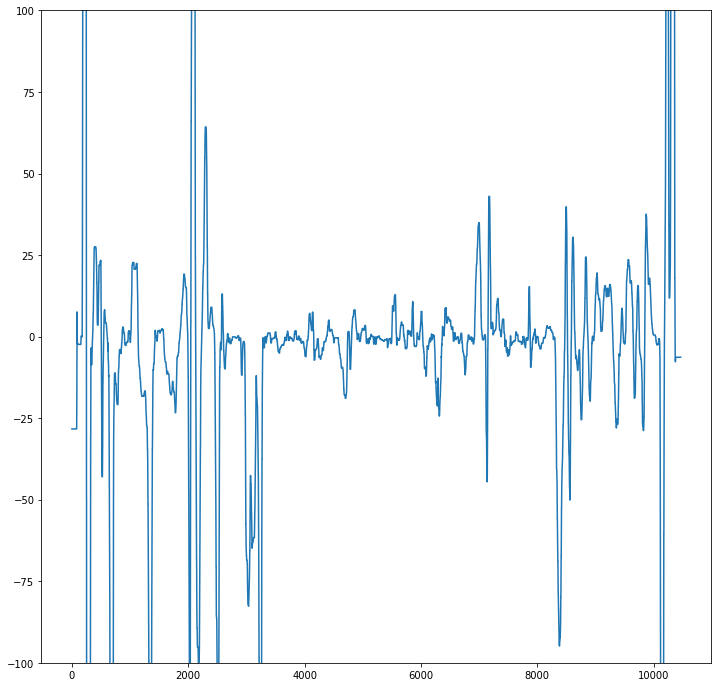

In [102]:
idxs = np.linspace(0, len(ground_truth), len(ground_truth))

plt.plot(idxs, ground_truth)
#plt.show()
#plt.plot(idxs, predictions_list)

plt.ylim(-100,100)
smooth_idxs = idxs[4:-4]
smooth = running_mean(predictions_list, 9)
plt.plot(smooth_idxs, smooth)

get_smoothness_score(smooth)




plt.show()

# Test Shift-Verhalten:

In [17]:
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12, 12]
mpl.rcParams['figure.dpi'] = 72

def show_crop(index, shift):
    frame = val_set.get_cropped_frame(index, shift)[0]
    frame_arr = img_to_array(frame)/255
    plt.imshow(frame_arr)
    plt.show()
    
crop_slider = widgets.IntSlider(min=0, max=val_set.get_batch_size()*len(val_set)-1, continuous_update=False)
shift_slider = widgets.IntSlider(min=-100, max=100, continuous_update=False)

interact(show_crop, index=crop_slider, shift = shift_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=10463), IntSlider(v…

In [18]:
gui = AutopilotGUI()

predictions_lists = []
render_list = []

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(model_name + '_shift_behaviour.avi',fourcc, 15.0, (848,210))

frames = range(0, val_set.get_batch_size()*len(val_set)-1, 100)

shifts = range(-100,100,1)


for frame_idx in frames:
    predictions_lists.append([])
    for shift in shifts:
        cropped_sample = val_set.get_cropped_frame(frame_idx, shift)
        cropped_frame = cropped_sample[0]
        actual_swa = cropped_sample[1]['steering_wheel_angle']*90
        test_data = np.expand_dims(cropped_frame, axis=0)
        predictions = loaded_model.predict(test_data)
        predicted_swa = predictions[0][0]*90
        predictions_lists[-1].append(predicted_swa)



        gui.set_frame(cropped_frame)
        gui.set_show_overlay(True)
        gui.set_engaged(False)
        gui.set_recording(False)

        gui.set_timestring('')

        velocity = cropped_sample[1]['speed']
        gui.set_velocity(velocity)

        gui.set_actual_swa(actual_swa)
        gui.set_predicted_swa(predicted_swa)

        print("Ground-truth: " +str(actual_swa))
        print("Prediction: " + str(predicted_swa))

        gui.render()
        frame = gui.get_rendered_gui()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        out.write(rgb_frame.astype(np.uint8))
    
out.release()

Ground-truth: -28.3
Prediction: -1.165007594972849
Ground-truth: -28.3
Prediction: -0.6759161688387394
Ground-truth: -28.3
Prediction: -1.0838477220386267
Ground-truth: -28.3
Prediction: -0.4504453204572201
Ground-truth: -28.3
Prediction: -0.2981865406036377
Ground-truth: -28.3
Prediction: -2.2460778057575226
Ground-truth: -28.3
Prediction: -3.206395134329796
Ground-truth: -28.3
Prediction: -4.013022221624851
Ground-truth: -28.3
Prediction: -3.083309233188629
Ground-truth: -28.3
Prediction: -3.076009266078472
Ground-truth: -28.3
Prediction: -4.17692095041275
Ground-truth: -28.3
Prediction: -2.173806354403496
Ground-truth: -28.3
Prediction: -1.9255647249519825
Ground-truth: -28.3
Prediction: -3.615461178123951
Ground-truth: -28.3
Prediction: -4.795972779393196
Ground-truth: -28.3
Prediction: -6.125840842723846
Ground-truth: -28.3
Prediction: -5.140386186540127
Ground-truth: -28.3
Prediction: -4.793853498995304
Ground-truth: -28.3
Prediction: -5.289442241191864
Ground-truth: -28.3
Predic

Ground-truth: -28.3
Prediction: -4.423392489552498
Ground-truth: -28.3
Prediction: -4.539926089346409
Ground-truth: -28.3
Prediction: -3.8513926416635513
Ground-truth: -28.3
Prediction: -3.5989635810256004
Ground-truth: -28.3
Prediction: -5.8892592787742615
Ground-truth: -28.3
Prediction: -6.384009495377541
Ground-truth: -28.3
Prediction: -8.958888575434685
Ground-truth: -28.3
Prediction: -6.755398213863373
Ground-truth: -28.3
Prediction: -6.936860382556915
Ground-truth: -28.3
Prediction: -8.475317806005478
Ground-truth: -28.3
Prediction: -8.182366266846657
Ground-truth: -28.3
Prediction: -7.516513243317604
Ground-truth: -28.3
Prediction: -6.487038508057594
Ground-truth: -28.3
Prediction: -6.7471108585596085
Ground-truth: -28.3
Prediction: -7.374281734228134
Ground-truth: -28.3
Prediction: -8.498783111572266
Ground-truth: -28.3
Prediction: -8.620894029736519
Ground-truth: -28.3
Prediction: -8.239250555634499
Ground-truth: -28.3
Prediction: -6.374761238694191
Ground-truth: -28.3
Predict

Ground-truth: -2.0
Prediction: -0.8377329166978598
Ground-truth: -2.0
Prediction: -1.0475325398147106
Ground-truth: -2.0
Prediction: -1.7879700846970081
Ground-truth: -2.0
Prediction: -2.0666031539440155
Ground-truth: -2.0
Prediction: -2.0010435953736305
Ground-truth: -2.0
Prediction: -1.67020870372653
Ground-truth: -2.0
Prediction: -1.3980248384177685
Ground-truth: -2.0
Prediction: -0.4469507373869419
Ground-truth: -2.0
Prediction: -0.8956404682248831
Ground-truth: -2.0
Prediction: -1.9981432892382145
Ground-truth: -2.0
Prediction: -1.6574640199542046
Ground-truth: -2.0
Prediction: -1.417479906231165
Ground-truth: -2.0
Prediction: -1.030923631042242
Ground-truth: -2.0
Prediction: -2.252319809049368
Ground-truth: -2.0
Prediction: -2.9527034237980843
Ground-truth: -2.0
Prediction: -3.935025930404663
Ground-truth: -2.0
Prediction: -4.878889583051205
Ground-truth: -2.0
Prediction: -3.7285494804382324
Ground-truth: -2.0
Prediction: -3.212631940841675
Ground-truth: -2.0
Prediction: -2.92949

Ground-truth: 376.72
Prediction: 0.9484341368079185
Ground-truth: 376.72
Prediction: 0.8414820581674576
Ground-truth: 376.72
Prediction: 0.9453365206718445
Ground-truth: 376.72
Prediction: 1.133875697851181
Ground-truth: 376.72
Prediction: 0.5975510738790035
Ground-truth: 376.72
Prediction: -0.17706787213683128
Ground-truth: 376.72
Prediction: -0.23660100996494293
Ground-truth: 376.72
Prediction: -0.7731609139591455
Ground-truth: 376.72
Prediction: -1.441454328596592
Ground-truth: 376.72
Prediction: -1.3165879435837269
Ground-truth: 376.72
Prediction: -2.028827089816332
Ground-truth: 376.72
Prediction: -1.6404187493026257
Ground-truth: 376.72
Prediction: -1.525353156030178
Ground-truth: 376.72
Prediction: -1.3952583074569702
Ground-truth: 376.72
Prediction: -1.3451977260410786
Ground-truth: 376.72
Prediction: -2.025749757885933
Ground-truth: 376.72
Prediction: -1.7528346553444862
Ground-truth: 376.72
Prediction: -1.022220030426979
Ground-truth: 376.72
Prediction: -0.7680014334619045
Gr

Ground-truth: -386.2300000000001
Prediction: 1.2714334577322006
Ground-truth: -386.2300000000001
Prediction: 1.034797579050064
Ground-truth: -386.2300000000001
Prediction: 1.4815040677785873
Ground-truth: -386.2300000000001
Prediction: 1.7527270317077637
Ground-truth: -386.2300000000001
Prediction: 1.4171753078699112
Ground-truth: -386.2300000000001
Prediction: 1.1417033895850182
Ground-truth: -386.2300000000001
Prediction: 1.037609875202179
Ground-truth: -386.2300000000001
Prediction: 1.2312187626957893
Ground-truth: -386.2300000000001
Prediction: 1.2692078948020935
Ground-truth: -386.2300000000001
Prediction: 1.8335869163274765
Ground-truth: -386.2300000000001
Prediction: 2.211148738861084
Ground-truth: -386.2300000000001
Prediction: 3.0589866265654564
Ground-truth: -386.2300000000001
Prediction: 3.888530507683754
Ground-truth: -386.2300000000001
Prediction: 3.6822277307510376
Ground-truth: -386.2300000000001
Prediction: 3.4153955429792404
Ground-truth: -386.2300000000001
Prediction:

Ground-truth: -386.2300000000001
Prediction: -11.536931991577148
Ground-truth: -386.2300000000001
Prediction: -11.556951999664307
Ground-truth: -386.2300000000001
Prediction: -11.235076189041138
Ground-truth: -386.2300000000001
Prediction: -10.634016618132591
Ground-truth: -386.2300000000001
Prediction: -10.379125624895096
Ground-truth: -386.2300000000001
Prediction: -9.67431016266346
Ground-truth: -386.2300000000001
Prediction: -9.25377331674099
Ground-truth: -386.2300000000001
Prediction: -8.904477283358574
Ground-truth: -386.2300000000001
Prediction: -8.374352753162384
Ground-truth: -386.2300000000001
Prediction: -7.730666175484657
Ground-truth: -386.2300000000001
Prediction: -7.21699632704258
Ground-truth: -386.2300000000001
Prediction: -6.973401457071304
Ground-truth: -386.2300000000001
Prediction: -6.323038190603256
Ground-truth: -386.2300000000001
Prediction: -5.701113045215607
Ground-truth: -386.2300000000001
Prediction: -5.551825985312462
Ground-truth: -386.2300000000001
Predi

Ground-truth: 27.55
Prediction: 10.4097168892622
Ground-truth: 27.55
Prediction: 9.33666966855526
Ground-truth: 27.55
Prediction: 7.624012157320976
Ground-truth: 27.55
Prediction: 7.3041218519210815
Ground-truth: 27.55
Prediction: 7.559265643358231
Ground-truth: 27.55
Prediction: 7.159044519066811
Ground-truth: 27.55
Prediction: 5.46917237341404
Ground-truth: 27.55
Prediction: 4.389719367027283
Ground-truth: 27.55
Prediction: 3.072008080780506
Ground-truth: 27.55
Prediction: 4.031490236520767
Ground-truth: 27.55
Prediction: 7.081303372979164
Ground-truth: 27.55
Prediction: 8.772531375288963
Ground-truth: 27.55
Prediction: 9.004144817590714
Ground-truth: 27.55
Prediction: 8.615422993898392
Ground-truth: 27.55
Prediction: 10.66564790904522
Ground-truth: 27.55
Prediction: 13.203149735927582
Ground-truth: 27.55
Prediction: 14.94015097618103
Ground-truth: 27.55
Prediction: 16.643613874912262
Ground-truth: 27.55
Prediction: 16.285989582538605
Ground-truth: 27.55
Prediction: 14.02611047029495

Ground-truth: 18.41
Prediction: -14.920356273651123
Ground-truth: 18.41
Prediction: -14.795486032962799
Ground-truth: 18.41
Prediction: -14.513634145259857
Ground-truth: 18.41
Prediction: -14.265430569648743
Ground-truth: 18.41
Prediction: -14.241955876350403
Ground-truth: 18.41
Prediction: -14.224567115306854
Ground-truth: 18.41
Prediction: -14.590766429901123
Ground-truth: 18.41
Prediction: -14.766950011253357
Ground-truth: 18.41
Prediction: -14.833726286888123
Ground-truth: 18.41
Prediction: -14.878698885440826
Ground-truth: 18.41
Prediction: -14.977060854434967
Ground-truth: 18.41
Prediction: -15.435742735862732
Ground-truth: 18.41
Prediction: -15.475721061229706
Ground-truth: 18.41
Prediction: -15.623255968093872
Ground-truth: 18.41
Prediction: -15.925755500793457
Ground-truth: 18.41
Prediction: -16.274587512016296
Ground-truth: 18.41
Prediction: -16.376168131828308
Ground-truth: 18.41
Prediction: -16.247827112674713
Ground-truth: 18.41
Prediction: -16.060579419136047
Ground-truth

Ground-truth: 1.8199999999999998
Prediction: -12.078798562288284
Ground-truth: 1.8199999999999998
Prediction: -12.20193475484848
Ground-truth: 1.8199999999999998
Prediction: -12.115114331245422
Ground-truth: 1.8199999999999998
Prediction: -11.960828304290771
Ground-truth: 1.8199999999999998
Prediction: -11.875190734863281
Ground-truth: 1.8199999999999998
Prediction: -11.643347293138504
Ground-truth: 1.8199999999999998
Prediction: -11.601708680391312
Ground-truth: 1.8199999999999998
Prediction: -11.275635212659836
Ground-truth: 1.8199999999999998
Prediction: -11.27994954586029
Ground-truth: 1.8199999999999998
Prediction: -11.51943325996399
Ground-truth: 1.8199999999999998
Prediction: -11.549142748117447
Ground-truth: 1.8199999999999998
Prediction: -12.42060050368309
Ground-truth: 1.8199999999999998
Prediction: -13.35163950920105
Ground-truth: 1.8199999999999998
Prediction: -13.577564656734467
Ground-truth: 1.8199999999999998
Prediction: -12.847199141979218
Ground-truth: 1.81999999999999

Ground-truth: 1.8199999999999998
Prediction: -2.619793340563774
Ground-truth: 1.8199999999999998
Prediction: -2.8958610445261
Ground-truth: 1.8199999999999998
Prediction: -2.39710696041584
Ground-truth: 1.8199999999999998
Prediction: -3.1079131364822388
Ground-truth: 1.8199999999999998
Prediction: -3.728415369987488
Ground-truth: 1.8199999999999998
Prediction: -4.246367029845715
Ground-truth: 1.8199999999999998
Prediction: -4.766816832125187
Ground-truth: 1.8199999999999998
Prediction: -4.810797348618507
Ground-truth: 1.8199999999999998
Prediction: -5.335661061108112
Ground-truth: 1.8199999999999998
Prediction: -5.641384273767471
Ground-truth: 1.8199999999999998
Prediction: -5.958151817321777
Ground-truth: 1.8199999999999998
Prediction: -5.560696050524712
Ground-truth: 1.8199999999999998
Prediction: -5.3826456516981125
Ground-truth: 1.8199999999999998
Prediction: -5.338193736970425
Ground-truth: 1.8199999999999998
Prediction: -4.697563536465168
Ground-truth: 1.8199999999999998
Predicti

Ground-truth: -251.25
Prediction: -20.53608924150467
Ground-truth: -251.25
Prediction: -19.953832626342773
Ground-truth: -251.25
Prediction: -19.257236123085022
Ground-truth: -251.25
Prediction: -19.40301150083542
Ground-truth: -251.25
Prediction: -19.189714193344116
Ground-truth: -251.25
Prediction: -18.900521099567413
Ground-truth: -251.25
Prediction: -18.186817467212677
Ground-truth: -251.25
Prediction: -17.483287453651428
Ground-truth: -251.25
Prediction: -16.96739673614502
Ground-truth: -251.25
Prediction: -17.26423680782318
Ground-truth: -251.25
Prediction: -17.017961740493774
Ground-truth: -251.25
Prediction: -16.72320306301117
Ground-truth: -251.25
Prediction: -16.416639983654022
Ground-truth: -251.25
Prediction: -16.355914771556854
Ground-truth: -251.25
Prediction: -16.698009073734283
Ground-truth: -251.25
Prediction: -16.82264596223831
Ground-truth: -251.25
Prediction: -16.94864273071289
Ground-truth: -251.25
Prediction: -16.49868071079254
Ground-truth: -251.25
Prediction: -1

Ground-truth: -10.89
Prediction: -12.254291474819183
Ground-truth: -10.89
Prediction: -11.41415923833847
Ground-truth: -10.89
Prediction: -10.78578606247902
Ground-truth: -10.89
Prediction: -10.373813509941101
Ground-truth: -10.89
Prediction: -10.430420190095901
Ground-truth: -10.89
Prediction: -10.394477918744087
Ground-truth: -10.89
Prediction: -10.670396760106087
Ground-truth: -10.89
Prediction: -10.623104721307755
Ground-truth: -10.89
Prediction: -10.791914910078049
Ground-truth: -10.89
Prediction: -10.51073357462883
Ground-truth: -10.89
Prediction: -11.053218394517899
Ground-truth: -10.89
Prediction: -11.308788657188416
Ground-truth: -10.89
Prediction: -11.04385681450367
Ground-truth: -10.89
Prediction: -10.785985216498375
Ground-truth: -10.89
Prediction: -10.920902341604233
Ground-truth: -10.89
Prediction: -10.062978342175484
Ground-truth: -10.89
Prediction: -9.62535247206688
Ground-truth: -10.89
Prediction: -9.65235024690628
Ground-truth: -10.89
Prediction: -9.931931644678116
Gr

Ground-truth: 0.94
Prediction: -17.947878241539
Ground-truth: 0.94
Prediction: -18.215130865573883
Ground-truth: 0.94
Prediction: -18.142416179180145
Ground-truth: 0.94
Prediction: -18.39663863182068
Ground-truth: 0.94
Prediction: -18.72631698846817
Ground-truth: 0.94
Prediction: -18.523807525634766
Ground-truth: 0.94
Prediction: -17.741305232048035
Ground-truth: 0.94
Prediction: -17.374287843704224
Ground-truth: 0.94
Prediction: -17.047739624977112
Ground-truth: 0.94
Prediction: -16.812550127506256
Ground-truth: 0.94
Prediction: -16.734449565410614
Ground-truth: 0.94
Prediction: -16.842987835407257
Ground-truth: 0.94
Prediction: -17.046183943748474
Ground-truth: 0.94
Prediction: -17.080639600753784
Ground-truth: 0.94
Prediction: -16.99095457792282
Ground-truth: 0.94
Prediction: -16.664350032806396
Ground-truth: 0.94
Prediction: -16.183105409145355
Ground-truth: 0.94
Prediction: -15.76849490404129
Ground-truth: 0.94
Prediction: -15.339153707027435
Ground-truth: 0.94
Prediction: -14.692

Ground-truth: 0.94
Prediction: -3.7947557866573334
Ground-truth: 0.94
Prediction: -3.7264305353164673
Ground-truth: 0.94
Prediction: -3.39939683675766
Ground-truth: 0.94
Prediction: -3.220268189907074
Ground-truth: 0.94
Prediction: -3.1329917907714844
Ground-truth: -0.19000000000000003
Prediction: -1.7772509716451168
Ground-truth: -0.19000000000000003
Prediction: -1.9676189124584198
Ground-truth: -0.19000000000000003
Prediction: -2.230543624609709
Ground-truth: -0.19000000000000003
Prediction: -2.0085158944129944
Ground-truth: -0.19000000000000003
Prediction: -1.7582279071211815
Ground-truth: -0.19000000000000003
Prediction: -1.850108653306961
Ground-truth: -0.19000000000000003
Prediction: -1.7569798417389393
Ground-truth: -0.19000000000000003
Prediction: -1.8320895731449127
Ground-truth: -0.19000000000000003
Prediction: -1.5688827261328697
Ground-truth: -0.19000000000000003
Prediction: -1.7817116528749466
Ground-truth: -0.19000000000000003
Prediction: -1.753462627530098
Ground-truth: 

Ground-truth: -0.19000000000000003
Prediction: 7.688033804297447
Ground-truth: -0.19000000000000003
Prediction: 7.383894771337509
Ground-truth: -0.19000000000000003
Prediction: 7.205853089690208
Ground-truth: -0.19000000000000003
Prediction: 7.703948691487312
Ground-truth: -0.19000000000000003
Prediction: 8.099121898412704
Ground-truth: -0.19000000000000003
Prediction: 8.507950231432915
Ground-truth: -0.19000000000000003
Prediction: 8.769901469349861
Ground-truth: -0.19000000000000003
Prediction: 9.098218604922295
Ground-truth: -0.19000000000000003
Prediction: 9.498441740870476
Ground-truth: -0.19000000000000003
Prediction: 9.583797678351402
Ground-truth: -0.19000000000000003
Prediction: 9.75627176463604
Ground-truth: -0.19000000000000003
Prediction: 9.90382544696331
Ground-truth: -0.19000000000000003
Prediction: 10.049736276268959
Ground-truth: -0.19000000000000003
Prediction: 9.902147725224495
Ground-truth: -0.19000000000000003
Prediction: 9.557254537940025
Ground-truth: -0.190000000

Ground-truth: 21.22
Prediction: 44.06099081039429
Ground-truth: 21.22
Prediction: 44.54585909843445
Ground-truth: 21.22
Prediction: 44.626851081848145
Ground-truth: 21.22
Prediction: 45.31162440776825
Ground-truth: 21.22
Prediction: 45.63770055770874
Ground-truth: 21.22
Prediction: 45.67133009433746
Ground-truth: 21.22
Prediction: 44.933422207832336
Ground-truth: 21.22
Prediction: 44.82354819774628
Ground-truth: 21.22
Prediction: 44.971691966056824
Ground-truth: 21.22
Prediction: 44.7612190246582
Ground-truth: 21.22
Prediction: 44.42441940307617
Ground-truth: 21.22
Prediction: 44.34556245803833
Ground-truth: 21.22
Prediction: 43.78994822502136
Ground-truth: 21.22
Prediction: 44.40672755241394
Ground-truth: 21.22
Prediction: 44.90231931209564
Ground-truth: 21.22
Prediction: 44.67343032360077
Ground-truth: 21.22
Prediction: 44.37835514545441
Ground-truth: 21.22
Prediction: 43.467997312545776
Ground-truth: 21.22
Prediction: 42.96296954154968
Ground-truth: 21.22
Prediction: 42.426280975341

Ground-truth: -18.22
Prediction: -39.14598762989044
Ground-truth: -18.22
Prediction: -39.22670602798462
Ground-truth: -18.22
Prediction: -39.489586651325226
Ground-truth: -18.22
Prediction: -40.038310289382935
Ground-truth: -18.22
Prediction: -40.15002429485321
Ground-truth: -18.22
Prediction: -40.251918733119965
Ground-truth: -18.22
Prediction: -39.800449311733246
Ground-truth: -18.22
Prediction: -39.15095508098602
Ground-truth: -18.22
Prediction: -38.92677068710327
Ground-truth: -18.22
Prediction: -38.68076652288437
Ground-truth: -18.22
Prediction: -38.784509003162384
Ground-truth: -18.22
Prediction: -38.460122644901276
Ground-truth: -18.22
Prediction: -38.56717497110367
Ground-truth: -18.22
Prediction: -38.6629593372345
Ground-truth: -18.22
Prediction: -38.58149528503418
Ground-truth: -18.22
Prediction: -38.48438322544098
Ground-truth: -18.22
Prediction: -38.266359865665436
Ground-truth: -18.22
Prediction: -38.59246551990509
Ground-truth: -18.22
Prediction: -38.782234489917755
Groun

Ground-truth: -18.22
Prediction: -13.856350779533386
Ground-truth: -18.22
Prediction: -12.991029918193817
Ground-truth: -18.22
Prediction: -12.0087231695652
Ground-truth: -18.22
Prediction: -10.895749926567078
Ground-truth: -18.22
Prediction: -10.522776022553444
Ground-truth: -18.22
Prediction: -10.300626754760742
Ground-truth: -18.22
Prediction: -10.200219601392746
Ground-truth: -18.22
Prediction: -9.660949409008026
Ground-truth: -18.22
Prediction: -9.603672176599503
Ground-truth: -18.22
Prediction: -9.337998703122139
Ground-truth: -18.22
Prediction: -8.938024342060089
Ground-truth: -34.37
Prediction: -25.007830560207367
Ground-truth: -34.37
Prediction: -25.074647068977356
Ground-truth: -34.37
Prediction: -24.196025133132935
Ground-truth: -34.37
Prediction: -23.785979747772217
Ground-truth: -34.37
Prediction: -23.846503794193268
Ground-truth: -34.37
Prediction: -24.863495528697968
Ground-truth: -34.37
Prediction: -25.52649199962616
Ground-truth: -34.37
Prediction: -25.621820390224457


Ground-truth: -34.37
Prediction: -22.400549054145813
Ground-truth: -34.37
Prediction: -22.575351297855377
Ground-truth: -34.37
Prediction: -22.620474100112915
Ground-truth: -34.37
Prediction: -22.071828246116638
Ground-truth: -34.37
Prediction: -21.69763594865799
Ground-truth: -34.37
Prediction: -21.965433061122894
Ground-truth: -34.37
Prediction: -23.047248423099518
Ground-truth: -34.37
Prediction: -22.643538415431976
Ground-truth: -34.37
Prediction: -22.16828852891922
Ground-truth: -34.37
Prediction: -21.759114861488342
Ground-truth: -34.37
Prediction: -21.806345880031586
Ground-truth: -34.37
Prediction: -21.56937539577484
Ground-truth: -34.37
Prediction: -21.123691499233246
Ground-truth: -34.37
Prediction: -21.65945738554001
Ground-truth: -34.37
Prediction: -22.262809574604034
Ground-truth: -34.37
Prediction: -22.76446044445038
Ground-truth: -34.37
Prediction: -23.714182376861572
Ground-truth: -34.37
Prediction: -24.837124049663544
Ground-truth: -34.37
Prediction: -26.27973139286041

Ground-truth: -10.21
Prediction: -12.88782924413681
Ground-truth: -10.21
Prediction: -12.291288524866104
Ground-truth: -10.21
Prediction: -11.531771421432495
Ground-truth: -10.21
Prediction: -11.071100011467934
Ground-truth: -10.21
Prediction: -10.721287652850151
Ground-truth: -10.21
Prediction: -10.655031725764275
Ground-truth: -10.21
Prediction: -10.684287250041962
Ground-truth: -10.21
Prediction: -10.445498898625374
Ground-truth: -10.21
Prediction: -10.418447479605675
Ground-truth: -10.21
Prediction: -10.469102337956429
Ground-truth: -10.21
Prediction: -10.445879772305489
Ground-truth: -10.21
Prediction: -10.068745762109756
Ground-truth: -10.21
Prediction: -10.018668249249458
Ground-truth: -10.21
Prediction: -9.894412234425545
Ground-truth: -10.21
Prediction: -9.434018433094025
Ground-truth: -10.21
Prediction: -8.704261779785156
Ground-truth: -10.21
Prediction: -8.041770905256271
Ground-truth: -10.21
Prediction: -7.684783637523651
Ground-truth: -10.21
Prediction: -7.50984862446785
G

Ground-truth: 1.9399999999999997
Prediction: -14.040114283561707
Ground-truth: 1.9399999999999997
Prediction: -13.887078166007996
Ground-truth: 1.9399999999999997
Prediction: -13.444966971874237
Ground-truth: 1.9399999999999997
Prediction: -13.029064983129501
Ground-truth: 1.9399999999999997
Prediction: -13.176501989364624
Ground-truth: 1.9399999999999997
Prediction: -13.614147305488586
Ground-truth: 1.9399999999999997
Prediction: -14.05100405216217
Ground-truth: 1.9399999999999997
Prediction: -14.682176113128662
Ground-truth: 1.9399999999999997
Prediction: -15.138586163520813
Ground-truth: 1.9399999999999997
Prediction: -14.88547682762146
Ground-truth: 1.9399999999999997
Prediction: -14.751580953598022
Ground-truth: 1.9399999999999997
Prediction: -14.172009229660034
Ground-truth: 1.9399999999999997
Prediction: -13.830360174179077
Ground-truth: 1.9399999999999997
Prediction: -13.902283608913422
Ground-truth: 1.9399999999999997
Prediction: -14.110224545001984
Ground-truth: 1.93999999999

Ground-truth: 1.9399999999999997
Prediction: -5.270247682929039
Ground-truth: 1.9399999999999997
Prediction: -5.510751307010651
Ground-truth: 1.9399999999999997
Prediction: -5.529643781483173
Ground-truth: 1.9399999999999997
Prediction: -5.730184838175774
Ground-truth: 1.9399999999999997
Prediction: -5.3987254947423935
Ground-truth: 1.9399999999999997
Prediction: -5.343532003462315
Ground-truth: 1.9399999999999997
Prediction: -5.5149077251553535
Ground-truth: 1.9399999999999997
Prediction: -5.0934891030192375
Ground-truth: 1.9399999999999997
Prediction: -5.2005209773778915
Ground-truth: 1.9399999999999997
Prediction: -5.012850500643253
Ground-truth: 1.9399999999999997
Prediction: -5.306050814688206
Ground-truth: 1.9399999999999997
Prediction: -5.321023911237717
Ground-truth: 1.9399999999999997
Prediction: -6.009436994791031
Ground-truth: 1.9399999999999997
Prediction: -5.754397809505463
Ground-truth: 1.9399999999999997
Prediction: -5.61396237462759
Ground-truth: 1.9399999999999997
Pred

Ground-truth: -7.26
Prediction: -0.3279392793774605
Ground-truth: -7.26
Prediction: 0.1884278655052185
Ground-truth: -7.26
Prediction: -0.2832595445215702
Ground-truth: -7.26
Prediction: -1.2610415741801262
Ground-truth: -7.26
Prediction: -2.3518619500100613
Ground-truth: -7.26
Prediction: -1.7104711756110191
Ground-truth: -7.26
Prediction: -1.4813032373785973
Ground-truth: -7.26
Prediction: -1.4063016325235367
Ground-truth: -7.26
Prediction: -1.2903670873492956
Ground-truth: -7.26
Prediction: -1.302363183349371
Ground-truth: -7.26
Prediction: -1.0933792032301426
Ground-truth: -7.26
Prediction: -0.7643480971455574
Ground-truth: -7.26
Prediction: -0.506591834127903
Ground-truth: -7.26
Prediction: -0.6619309633970261
Ground-truth: -7.26
Prediction: -0.2674226090312004
Ground-truth: -7.26
Prediction: -0.30463842675089836
Ground-truth: -7.26
Prediction: 0.5300641804933548
Ground-truth: -7.26
Prediction: 1.020185574889183
Ground-truth: -7.26
Prediction: 1.3142156973481178
Ground-truth: -7.2

Ground-truth: -17.84
Prediction: -25.51238089799881
Ground-truth: -17.84
Prediction: -25.769508183002472
Ground-truth: -17.84
Prediction: -27.096716165542603
Ground-truth: -17.84
Prediction: -27.77790069580078
Ground-truth: -17.84
Prediction: -27.679195404052734
Ground-truth: -17.84
Prediction: -27.456161677837372
Ground-truth: -17.84
Prediction: -27.49016135931015
Ground-truth: -17.84
Prediction: -26.63581609725952
Ground-truth: -17.84
Prediction: -26.27055287361145
Ground-truth: -17.84
Prediction: -25.89462250471115
Ground-truth: -17.84
Prediction: -25.29924988746643
Ground-truth: -17.84
Prediction: -24.846428632736206
Ground-truth: -17.84
Prediction: -24.324535131454468
Ground-truth: -17.84
Prediction: -23.836869299411774
Ground-truth: -17.84
Prediction: -23.42049390077591
Ground-truth: -17.84
Prediction: -22.73035079240799
Ground-truth: -17.84
Prediction: -22.551149725914
Ground-truth: -17.84
Prediction: -23.145092725753784
Ground-truth: -17.84
Prediction: -22.259985208511353
Groun

Ground-truth: -10.96
Prediction: -11.096564903855324
Ground-truth: -10.96
Prediction: -10.689155459403992
Ground-truth: -10.96
Prediction: -11.131113767623901
Ground-truth: -10.96
Prediction: -10.403667837381363
Ground-truth: -10.96
Prediction: -10.790709927678108
Ground-truth: -10.96
Prediction: -11.89656525850296
Ground-truth: -10.96
Prediction: -11.771302074193954
Ground-truth: -10.96
Prediction: -11.457974463701248
Ground-truth: -10.96
Prediction: -11.65979191660881
Ground-truth: -10.96
Prediction: -11.96473628282547
Ground-truth: -10.96
Prediction: -12.385224848985672
Ground-truth: -10.96
Prediction: -12.906100451946259
Ground-truth: -10.96
Prediction: -13.235078752040863
Ground-truth: -10.96
Prediction: -14.083523154258728
Ground-truth: -10.96
Prediction: -14.833699464797974
Ground-truth: -10.96
Prediction: -15.135855674743652
Ground-truth: -10.96
Prediction: -14.66663271188736
Ground-truth: -10.96
Prediction: -14.649807214736938
Ground-truth: -10.96
Prediction: -15.5064538121223

Ground-truth: 11.65
Prediction: 8.098030239343643
Ground-truth: 11.65
Prediction: 8.214654698967934
Ground-truth: 11.65
Prediction: 8.572079837322235
Ground-truth: 11.65
Prediction: 8.943900391459465
Ground-truth: 11.65
Prediction: 9.051090851426125
Ground-truth: 11.65
Prediction: 9.033580720424652
Ground-truth: 11.65
Prediction: 9.012198820710182
Ground-truth: 11.65
Prediction: 9.233735874295235
Ground-truth: 11.65
Prediction: 9.608094468712807
Ground-truth: 11.65
Prediction: 8.829800561070442
Ground-truth: 11.65
Prediction: 8.02531622350216
Ground-truth: 11.65
Prediction: 7.78262659907341
Ground-truth: 11.65
Prediction: 7.6657553762197495
Ground-truth: 11.65
Prediction: 9.119288697838783
Ground-truth: 11.65
Prediction: 8.76317784190178
Ground-truth: 11.65
Prediction: 8.77299003303051
Ground-truth: 11.65
Prediction: 9.73662056028843
Ground-truth: 11.65
Prediction: 9.772043153643608
Ground-truth: 11.65
Prediction: 10.208772495388985
Ground-truth: 11.65
Prediction: 10.298303291201591
Gr

Ground-truth: 11.65
Prediction: 22.952107787132263
Ground-truth: 11.65
Prediction: 22.585551738739014
Ground-truth: 11.65
Prediction: 22.913502752780914
Ground-truth: 11.65
Prediction: 23.648387789726257
Ground-truth: 11.65
Prediction: 24.74458247423172
Ground-truth: 11.65
Prediction: 24.46015030145645
Ground-truth: 11.65
Prediction: 23.469892144203186
Ground-truth: 11.65
Prediction: 23.06145340204239
Ground-truth: 11.65
Prediction: 22.57186710834503
Ground-truth: 11.65
Prediction: 22.98292100429535
Ground-truth: 11.65
Prediction: 22.77716338634491
Ground-truth: 11.65
Prediction: 22.419463992118835
Ground-truth: 11.65
Prediction: 21.881402134895325
Ground-truth: 11.65
Prediction: 21.557568311691284
Ground-truth: 11.65
Prediction: 20.966581106185913
Ground-truth: 11.65
Prediction: 21.394565105438232
Ground-truth: 11.65
Prediction: 21.67855203151703
Ground-truth: -12.08
Prediction: -10.891151279211044
Ground-truth: -12.08
Prediction: -10.226802304387093
Ground-truth: -12.08
Prediction: -

Ground-truth: -12.08
Prediction: 0.31741194427013397
Ground-truth: -12.08
Prediction: 0.1623450592160225
Ground-truth: -12.08
Prediction: -0.4764937609434128
Ground-truth: -12.08
Prediction: -1.4894011616706848
Ground-truth: -12.08
Prediction: -1.3847574591636658
Ground-truth: -12.08
Prediction: -0.5218217521905899
Ground-truth: -12.08
Prediction: 0.2440330758690834
Ground-truth: -12.08
Prediction: 0.6619520857930183
Ground-truth: -12.08
Prediction: 0.8276331424713135
Ground-truth: -12.08
Prediction: 0.8300462923943996
Ground-truth: -12.08
Prediction: 0.42739927768707275
Ground-truth: -12.08
Prediction: 0.5582687817513943
Ground-truth: -12.08
Prediction: 1.5087486058473587
Ground-truth: -12.08
Prediction: 2.246592789888382
Ground-truth: -12.08
Prediction: 2.639351338148117
Ground-truth: -12.08
Prediction: 3.0720164626836777
Ground-truth: -12.08
Prediction: 2.8627344220876694
Ground-truth: -12.08
Prediction: 2.8958989307284355
Ground-truth: -12.08
Prediction: 3.164633810520172
Ground-tr

Ground-truth: 153.89
Prediction: -10.12445256114006
Ground-truth: 153.89
Prediction: -10.073206946253777
Ground-truth: 153.89
Prediction: -9.850387126207352
Ground-truth: 153.89
Prediction: -9.79457437992096
Ground-truth: 153.89
Prediction: -10.042016878724098
Ground-truth: 153.89
Prediction: -10.32716989517212
Ground-truth: 153.89
Prediction: -11.151715144515038
Ground-truth: 153.89
Prediction: -11.234847530722618
Ground-truth: 153.89
Prediction: -10.591021478176117
Ground-truth: 153.89
Prediction: -10.770124644041061
Ground-truth: 153.89
Prediction: -10.800418183207512
Ground-truth: 153.89
Prediction: -10.481942743062973
Ground-truth: 153.89
Prediction: -10.214865803718567
Ground-truth: 153.89
Prediction: -10.195229351520538
Ground-truth: 153.89
Prediction: -10.24033136665821
Ground-truth: 153.89
Prediction: -9.563492015004158
Ground-truth: 153.89
Prediction: -9.16173130273819
Ground-truth: 153.89
Prediction: -8.954601064324379
Ground-truth: 153.89
Prediction: -9.107794091105461
Grou

Ground-truth: -62.48
Prediction: -13.697888553142548
Ground-truth: -62.48
Prediction: -14.350636303424835
Ground-truth: -62.48
Prediction: -14.359315931797028
Ground-truth: -62.48
Prediction: -13.308531045913696
Ground-truth: -62.48
Prediction: -12.78996616601944
Ground-truth: -62.48
Prediction: -12.039384841918945
Ground-truth: -62.48
Prediction: -10.785561427474022
Ground-truth: -62.48
Prediction: -9.96033288538456
Ground-truth: -62.48
Prediction: -9.63233157992363
Ground-truth: -62.48
Prediction: -9.900834783911705
Ground-truth: -62.48
Prediction: -9.896230101585388
Ground-truth: -62.48
Prediction: -9.431347623467445
Ground-truth: -62.48
Prediction: -8.998247981071472
Ground-truth: -62.48
Prediction: -8.951101452112198
Ground-truth: -62.48
Prediction: -9.424706473946571
Ground-truth: -62.48
Prediction: -10.337393805384636
Ground-truth: -62.48
Prediction: -10.961663201451302
Ground-truth: -62.48
Prediction: -11.891123056411743
Ground-truth: -62.48
Prediction: -12.760936617851257
Grou

Ground-truth: 64.3
Prediction: 18.33951026201248
Ground-truth: 64.3
Prediction: 18.11619222164154
Ground-truth: 64.3
Prediction: 18.440044820308685
Ground-truth: 64.3
Prediction: 18.018903136253357
Ground-truth: 64.3
Prediction: 17.57310926914215
Ground-truth: 64.3
Prediction: 17.79945284128189
Ground-truth: 64.3
Prediction: 17.61067360639572
Ground-truth: 64.3
Prediction: 18.043171763420105
Ground-truth: 64.3
Prediction: 18.448351621627808
Ground-truth: 64.3
Prediction: 19.018109142780304
Ground-truth: 64.3
Prediction: 20.30038207769394
Ground-truth: 64.3
Prediction: 20.097185969352722
Ground-truth: 64.3
Prediction: 20.089160799980164
Ground-truth: 64.3
Prediction: 20.254620909690857
Ground-truth: 64.3
Prediction: 19.51261729001999
Ground-truth: 64.3
Prediction: 18.9756041765213
Ground-truth: 64.3
Prediction: 18.647277653217316
Ground-truth: 64.3
Prediction: 18.813925981521606
Ground-truth: 64.3
Prediction: 18.791483938694
Ground-truth: 64.3
Prediction: 18.785242438316345
Ground-truth

Ground-truth: 64.3
Prediction: 11.060726568102837
Ground-truth: 64.3
Prediction: 10.392011627554893
Ground-truth: 64.3
Prediction: 9.83768217265606
Ground-truth: 64.3
Prediction: 9.747106656432152
Ground-truth: 64.3
Prediction: 9.347161129117012
Ground-truth: 64.3
Prediction: 9.222559109330177
Ground-truth: 64.3
Prediction: 9.416002705693245
Ground-truth: 64.3
Prediction: 9.877271577715874
Ground-truth: 64.3
Prediction: 8.719349205493927
Ground-truth: 64.3
Prediction: 8.203690499067307
Ground-truth: 64.3
Prediction: 8.431170657277107
Ground-truth: 64.3
Prediction: 8.90389122068882
Ground-truth: 64.3
Prediction: 9.56514559686184
Ground-truth: 64.3
Prediction: 9.205735623836517
Ground-truth: 9.02
Prediction: -2.7148451283574104
Ground-truth: 9.02
Prediction: -3.376028761267662
Ground-truth: 9.02
Prediction: -3.97480309009552
Ground-truth: 9.02
Prediction: -3.9574284106492996
Ground-truth: 9.02
Prediction: -3.0606284737586975
Ground-truth: 9.02
Prediction: -2.633925899863243
Ground-truth:

Ground-truth: 9.02
Prediction: 2.8096307069063187
Ground-truth: 9.02
Prediction: 2.6934877038002014
Ground-truth: 9.02
Prediction: 3.785797208547592
Ground-truth: 9.02
Prediction: 5.655296221375465
Ground-truth: 9.02
Prediction: 6.588461548089981
Ground-truth: 9.02
Prediction: 7.203496769070625
Ground-truth: 9.02
Prediction: 7.874366194009781
Ground-truth: 9.02
Prediction: 7.36262284219265
Ground-truth: 9.02
Prediction: 6.528471261262894
Ground-truth: 9.02
Prediction: 6.020344868302345
Ground-truth: 9.02
Prediction: 5.868101343512535
Ground-truth: 9.02
Prediction: 6.465149000287056
Ground-truth: 9.02
Prediction: 6.384695470333099
Ground-truth: 9.02
Prediction: 5.77326312661171
Ground-truth: 9.02
Prediction: 5.547207891941071
Ground-truth: 9.02
Prediction: 6.101333498954773
Ground-truth: 9.02
Prediction: 6.307985633611679
Ground-truth: 9.02
Prediction: 6.291682496666908
Ground-truth: 9.02
Prediction: 5.788135305047035
Ground-truth: 9.02
Prediction: 6.7076220363378525
Ground-truth: 9.02


Ground-truth: -105.18
Prediction: -23.169433772563934
Ground-truth: -105.18
Prediction: -22.869699597358704
Ground-truth: -105.18
Prediction: -22.943495213985443
Ground-truth: -105.18
Prediction: -23.015399873256683
Ground-truth: -105.18
Prediction: -22.554877996444702
Ground-truth: -105.18
Prediction: -22.328628301620483
Ground-truth: -105.18
Prediction: -22.71334022283554
Ground-truth: -105.18
Prediction: -23.29222798347473
Ground-truth: -105.18
Prediction: -23.61852675676346
Ground-truth: -105.18
Prediction: -23.23408842086792
Ground-truth: -105.18
Prediction: -22.922949492931366
Ground-truth: -105.18
Prediction: -22.86905586719513
Ground-truth: -105.18
Prediction: -23.288775980472565
Ground-truth: -105.18
Prediction: -23.688317835330963
Ground-truth: -105.18
Prediction: -23.73021125793457
Ground-truth: -105.18
Prediction: -23.754461109638214
Ground-truth: -105.18
Prediction: -23.60489845275879
Ground-truth: -105.18
Prediction: -23.263131380081177
Ground-truth: -105.18
Prediction: -

Ground-truth: 1.63
Prediction: -15.905671119689941
Ground-truth: 1.63
Prediction: -16.181941330432892
Ground-truth: 1.63
Prediction: -16.689501106739044
Ground-truth: 1.63
Prediction: -16.98496252298355
Ground-truth: 1.63
Prediction: -16.98809802532196
Ground-truth: 1.63
Prediction: -16.791634261608124
Ground-truth: 1.63
Prediction: -16.55838131904602
Ground-truth: 1.63
Prediction: -16.766416132450104
Ground-truth: 1.63
Prediction: -17.575660049915314
Ground-truth: 1.63
Prediction: -17.989790439605713
Ground-truth: 1.63
Prediction: -18.051100373268127
Ground-truth: 1.63
Prediction: -17.666940987110138
Ground-truth: 1.63
Prediction: -18.174074292182922
Ground-truth: 1.63
Prediction: -18.34755152463913
Ground-truth: 1.63
Prediction: -18.20872575044632
Ground-truth: 1.63
Prediction: -17.955670058727264
Ground-truth: 1.63
Prediction: -18.318878710269928
Ground-truth: 1.63
Prediction: -18.486058115959167
Ground-truth: 1.63
Prediction: -18.722476065158844
Ground-truth: 1.63
Prediction: -18.7

Ground-truth: -1.75
Prediction: -5.033676847815514
Ground-truth: -1.75
Prediction: -4.800026603043079
Ground-truth: -1.75
Prediction: -4.936179891228676
Ground-truth: -1.75
Prediction: -5.478612408041954
Ground-truth: -1.75
Prediction: -5.3693754225969315
Ground-truth: -1.75
Prediction: -5.489805266261101
Ground-truth: -1.75
Prediction: -5.729343965649605
Ground-truth: -1.75
Prediction: -6.133321523666382
Ground-truth: -1.75
Prediction: -6.182092130184174
Ground-truth: -1.75
Prediction: -5.545991510152817
Ground-truth: -1.75
Prediction: -5.0966812670230865
Ground-truth: -1.75
Prediction: -4.746611751616001
Ground-truth: -1.75
Prediction: -4.316981881856918
Ground-truth: -1.75
Prediction: -3.6248713731765747
Ground-truth: -1.75
Prediction: -3.3418969810009003
Ground-truth: -1.75
Prediction: -2.4674913100898266
Ground-truth: -1.75
Prediction: -1.8564076535403728
Ground-truth: -1.75
Prediction: -1.574953906238079
Ground-truth: -1.75
Prediction: -1.1958174593746662
Ground-truth: -1.75
Pred

Ground-truth: -0.06
Prediction: -18.2229146361351
Ground-truth: -0.06
Prediction: -18.696807324886322
Ground-truth: -0.06
Prediction: -19.2264524102211
Ground-truth: -0.06
Prediction: -19.32010442018509
Ground-truth: -0.06
Prediction: -19.20537292957306
Ground-truth: -0.06
Prediction: -18.89384239912033
Ground-truth: -0.06
Prediction: -18.966774344444275
Ground-truth: -0.06
Prediction: -19.524850845336914
Ground-truth: -0.06
Prediction: -19.74903792142868
Ground-truth: -0.06
Prediction: -20.029838383197784
Ground-truth: -0.06
Prediction: -19.861859679222107
Ground-truth: -0.06
Prediction: -19.94679182767868
Ground-truth: -0.06
Prediction: -20.035755336284637
Ground-truth: -0.06
Prediction: -19.709528982639313
Ground-truth: -0.06
Prediction: -19.110205471515656
Ground-truth: -0.06
Prediction: -18.807818591594696
Ground-truth: -0.06
Prediction: -18.559545278549194
Ground-truth: -0.06
Prediction: -18.820505440235138
Ground-truth: -0.06
Prediction: -18.94692063331604
Ground-truth: -0.06
Pr

Ground-truth: -0.06
Prediction: -7.404604107141495
Ground-truth: -0.06
Prediction: -7.19379723072052
Ground-truth: -0.06
Prediction: -6.594969928264618
Ground-truth: -0.06
Prediction: -5.875015407800674
Ground-truth: -0.06
Prediction: -6.296024322509766
Ground-truth: -0.06
Prediction: -6.1848896741867065
Ground-truth: -0.06
Prediction: -6.100008487701416
Ground-truth: -0.06
Prediction: -6.3718631118535995
Ground-truth: -0.06
Prediction: -6.605401039123535
Ground-truth: -0.06
Prediction: -6.567892357707024
Ground-truth: -0.06
Prediction: -6.164132729172707
Ground-truth: -0.06
Prediction: -5.623418167233467
Ground-truth: -0.06
Prediction: -5.233241245150566
Ground-truth: -0.06
Prediction: -5.060238093137741
Ground-truth: -0.06
Prediction: -4.912954978644848
Ground-truth: -0.06
Prediction: -4.725527912378311
Ground-truth: -0.06
Prediction: -4.454937614500523
Ground-truth: -0.06
Prediction: -4.300025291740894
Ground-truth: -0.06
Prediction: -4.522073641419411
Ground-truth: -0.06
Prediction

Ground-truth: -0.56
Prediction: 13.104581236839294
Ground-truth: -0.56
Prediction: 13.258207440376282
Ground-truth: -0.56
Prediction: 13.141617178916931
Ground-truth: -0.56
Prediction: 13.503170907497406
Ground-truth: -0.56
Prediction: 13.82265418767929
Ground-truth: -0.56
Prediction: 13.781222105026245
Ground-truth: -0.56
Prediction: 13.928775787353516
Ground-truth: -0.56
Prediction: 13.604241907596588
Ground-truth: -0.56
Prediction: 13.419354557991028
Ground-truth: -0.56
Prediction: 13.328902423381805
Ground-truth: -0.56
Prediction: 13.200180530548096
Ground-truth: -0.56
Prediction: 12.90468156337738
Ground-truth: -0.56
Prediction: 12.407743334770203
Ground-truth: -0.56
Prediction: 12.183419466018677
Ground-truth: -0.56
Prediction: 12.066909670829773
Ground-truth: -0.56
Prediction: 12.221777737140656
Ground-truth: -0.56
Prediction: 12.746187150478363
Ground-truth: -0.56
Prediction: 12.807405889034271
Ground-truth: -0.56
Prediction: 12.600049674510956
Ground-truth: -0.56
Prediction: 1

Ground-truth: -66.99
Prediction: -20.08051872253418
Ground-truth: -66.99
Prediction: -20.044877529144287
Ground-truth: -66.99
Prediction: -19.757103323936462
Ground-truth: -66.99
Prediction: -19.605794548988342
Ground-truth: -66.99
Prediction: -19.415792226791382
Ground-truth: -66.99
Prediction: -19.47201669216156
Ground-truth: -66.99
Prediction: -19.850752651691437
Ground-truth: -66.99
Prediction: -20.047425627708435
Ground-truth: -66.99
Prediction: -20.046910643577576
Ground-truth: -66.99
Prediction: -20.08537083864212
Ground-truth: -66.99
Prediction: -20.003029704093933
Ground-truth: -66.99
Prediction: -19.812531173229218
Ground-truth: -66.99
Prediction: -20.00357687473297
Ground-truth: -66.99
Prediction: -19.91263657808304
Ground-truth: -66.99
Prediction: -19.68753218650818
Ground-truth: -66.99
Prediction: -19.62184488773346
Ground-truth: -66.99
Prediction: -19.32367444038391
Ground-truth: -66.99
Prediction: -19.156151711940765
Ground-truth: -66.99
Prediction: -19.17097896337509
Gr

Ground-truth: -64.86
Prediction: -17.34915018081665
Ground-truth: -64.86
Prediction: -17.302318811416626
Ground-truth: -64.86
Prediction: -16.995699405670166
Ground-truth: -64.86
Prediction: -17.020362317562103
Ground-truth: -64.86
Prediction: -17.173020243644714
Ground-truth: -64.86
Prediction: -17.131963670253754
Ground-truth: -64.86
Prediction: -17.62095183134079
Ground-truth: -64.86
Prediction: -17.999398112297058
Ground-truth: -64.86
Prediction: -18.11097264289856
Ground-truth: -64.86
Prediction: -17.8067484498024
Ground-truth: -64.86
Prediction: -17.919849157333374
Ground-truth: -64.86
Prediction: -18.053833544254303
Ground-truth: -64.86
Prediction: -18.161481320858
Ground-truth: -64.86
Prediction: -18.113727271556854
Ground-truth: -64.86
Prediction: -18.084375858306885
Ground-truth: -64.86
Prediction: -18.73103767633438
Ground-truth: -64.86
Prediction: -19.09314125776291
Ground-truth: -64.86
Prediction: -19.218314588069916
Ground-truth: -64.86
Prediction: -19.916944205760956
Gro

Ground-truth: -33.43
Prediction: -7.180198431015015
Ground-truth: -33.43
Prediction: -6.85213677585125
Ground-truth: -33.43
Prediction: -7.450534254312515
Ground-truth: -33.43
Prediction: -7.960568368434906
Ground-truth: -33.43
Prediction: -8.457975313067436
Ground-truth: -33.43
Prediction: -8.37241217494011
Ground-truth: -33.43
Prediction: -8.867659270763397
Ground-truth: -33.43
Prediction: -9.894866198301315
Ground-truth: -33.43
Prediction: -10.014919191598892
Ground-truth: -33.43
Prediction: -9.224824234843254
Ground-truth: -33.43
Prediction: -8.62088330090046
Ground-truth: -33.43
Prediction: -8.571804910898209
Ground-truth: -33.43
Prediction: -8.306896537542343
Ground-truth: -33.43
Prediction: -8.236312866210938
Ground-truth: -33.43
Prediction: -8.912250995635986
Ground-truth: -33.43
Prediction: -9.027461260557175
Ground-truth: -33.43
Prediction: -7.839746251702309
Ground-truth: -33.43
Prediction: -7.199683338403702
Ground-truth: -33.43
Prediction: -7.0047477632761
Ground-truth: -3

Ground-truth: -33.43
Prediction: -14.239230751991272
Ground-truth: -33.43
Prediction: -14.293186068534851
Ground-truth: -33.43
Prediction: -14.646052122116089
Ground-truth: -33.43
Prediction: -14.257483184337616
Ground-truth: -33.43
Prediction: -14.204185009002686
Ground-truth: -33.43
Prediction: -14.374188780784607
Ground-truth: -33.43
Prediction: -13.781852424144745
Ground-truth: -33.43
Prediction: -13.133038133382797
Ground-truth: -33.43
Prediction: -12.721808552742004
Ground-truth: -33.43
Prediction: -13.253347277641296
Ground-truth: -33.43
Prediction: -14.046109020709991
Ground-truth: -33.43
Prediction: -13.955844640731812
Ground-truth: -33.43
Prediction: -13.81830096244812
Ground-truth: -33.43
Prediction: -14.3805992603302
Ground-truth: -33.43
Prediction: -13.87574851512909
Ground-truth: -33.43
Prediction: -13.266213834285736
Ground-truth: -33.43
Prediction: -13.019458651542664
Ground-truth: -33.43
Prediction: -12.430559545755386
Ground-truth: -33.43
Prediction: -11.9782385230064

Ground-truth: -3.3800000000000003
Prediction: -15.849524438381195
Ground-truth: -3.3800000000000003
Prediction: -16.569171845912933
Ground-truth: -3.3800000000000003
Prediction: -16.292810440063477
Ground-truth: -3.3800000000000003
Prediction: -16.10573172569275
Ground-truth: -3.3800000000000003
Prediction: -15.143470466136932
Ground-truth: -3.3800000000000003
Prediction: -14.53717589378357
Ground-truth: -3.3800000000000003
Prediction: -14.356008768081665
Ground-truth: -3.3800000000000003
Prediction: -13.842945098876953
Ground-truth: -3.3800000000000003
Prediction: -13.688557147979736
Ground-truth: -3.3800000000000003
Prediction: -13.261554837226868
Ground-truth: -3.3800000000000003
Prediction: -13.18679228425026
Ground-truth: -3.3800000000000003
Prediction: -12.396008670330048
Ground-truth: -3.3800000000000003
Prediction: -11.809979528188705
Ground-truth: -3.3800000000000003
Prediction: -11.537998169660568
Ground-truth: -3.3800000000000003
Prediction: -10.914131104946136
Ground-truth:

Ground-truth: 1.13
Prediction: -9.698435291647911
Ground-truth: 1.13
Prediction: -9.852418899536133
Ground-truth: 1.13
Prediction: -9.882802292704582
Ground-truth: 1.13
Prediction: -9.277738854289055
Ground-truth: 1.13
Prediction: -8.927386701107025
Ground-truth: 1.13
Prediction: -8.249473124742508
Ground-truth: 1.13
Prediction: -8.017205223441124
Ground-truth: 1.13
Prediction: -7.630677446722984
Ground-truth: 1.13
Prediction: -6.945505142211914
Ground-truth: 1.13
Prediction: -6.596240624785423
Ground-truth: 1.13
Prediction: -6.4389485120773315
Ground-truth: 1.13
Prediction: -6.228707581758499
Ground-truth: 1.13
Prediction: -6.387239545583725
Ground-truth: 1.13
Prediction: -6.135991662740707
Ground-truth: 1.13
Prediction: -6.070860922336578
Ground-truth: 1.13
Prediction: -5.845629796385765
Ground-truth: 1.13
Prediction: -5.864895433187485
Ground-truth: 1.13
Prediction: -6.045658886432648
Ground-truth: 1.13
Prediction: -5.927286967635155
Ground-truth: 1.13
Prediction: -5.73413573205471


Ground-truth: 1.38
Prediction: -29.319317936897278
Ground-truth: 1.38
Prediction: -29.601360261440277
Ground-truth: 1.38
Prediction: -29.33360069990158
Ground-truth: 1.38
Prediction: -28.471055924892426
Ground-truth: 1.38
Prediction: -28.304211795330048
Ground-truth: 1.38
Prediction: -28.43985378742218
Ground-truth: 1.38
Prediction: -27.603600025177002
Ground-truth: 1.38
Prediction: -26.831555664539337
Ground-truth: 1.38
Prediction: -26.086346805095673
Ground-truth: 1.38
Prediction: -26.104078888893127
Ground-truth: 1.38
Prediction: -25.96393883228302
Ground-truth: 1.38
Prediction: -26.263740062713623
Ground-truth: 1.38
Prediction: -26.181693971157074
Ground-truth: 1.38
Prediction: -26.064001321792603
Ground-truth: 1.38
Prediction: -25.332957208156586
Ground-truth: 1.38
Prediction: -24.561950862407684
Ground-truth: 1.38
Prediction: -23.959373831748962
Ground-truth: 1.38
Prediction: -23.59351247549057
Ground-truth: 1.38
Prediction: -23.29628348350525
Ground-truth: 1.38
Prediction: -23.4

Ground-truth: 1.38
Prediction: -1.531184446066618
Ground-truth: 1.38
Prediction: -1.8762581795454025
Ground-truth: 1.38
Prediction: -1.9235114939510822
Ground-truth: 1.38
Prediction: -1.6284049674868584
Ground-truth: 1.38
Prediction: -1.5273966640233994
Ground-truth: 1.38
Prediction: -1.8439417518675327
Ground-truth: 1.38
Prediction: -1.4055146556347609
Ground-truth: 1.38
Prediction: -1.1490062065422535
Ground-truth: 1.38
Prediction: -0.5517786741256714
Ground-truth: 1.38
Prediction: -0.12374890968203545
Ground-truth: 1.38
Prediction: -0.2565063536167145
Ground-truth: 1.38
Prediction: -1.015049982815981
Ground-truth: 1.38
Prediction: -1.1909676063805819
Ground-truth: 1.38
Prediction: -0.9349204134196043
Ground-truth: 1.38
Prediction: -0.7659762818366289
Ground-truth: 1.38
Prediction: -1.0551382787525654
Ground-truth: 1.38
Prediction: -1.1780836153775454
Ground-truth: 1.38
Prediction: -1.527195330709219
Ground-truth: 1.38
Prediction: -1.1237424798309803
Ground-truth: 1.38
Prediction: -0

Ground-truth: -2.88
Prediction: -13.674277067184448
Ground-truth: -2.88
Prediction: -14.212269186973572
Ground-truth: -2.88
Prediction: -14.09435659646988
Ground-truth: -2.88
Prediction: -13.467465341091156
Ground-truth: -2.88
Prediction: -13.003435134887695
Ground-truth: -2.88
Prediction: -13.023060858249664
Ground-truth: -2.88
Prediction: -12.556235790252686
Ground-truth: -2.88
Prediction: -12.388872653245926
Ground-truth: -2.88
Prediction: -11.82778000831604
Ground-truth: -2.88
Prediction: -11.396657824516296
Ground-truth: -2.88
Prediction: -10.65315954387188
Ground-truth: -2.88
Prediction: -9.815901964902878
Ground-truth: -2.88
Prediction: -9.551263824105263
Ground-truth: -2.88
Prediction: -9.718979001045227
Ground-truth: -2.88
Prediction: -10.463853925466537
Ground-truth: -2.88
Prediction: -10.232832580804825
Ground-truth: -2.88
Prediction: -10.179278254508972
Ground-truth: -2.88
Prediction: -10.30955582857132
Ground-truth: -2.88
Prediction: -10.25046743452549
Ground-truth: -2.88


Ground-truth: 0.63
Prediction: 0.34008096903562546
Ground-truth: 0.63
Prediction: 0.11011339724063873
Ground-truth: 0.63
Prediction: 0.49914266914129257
Ground-truth: 0.63
Prediction: 0.843360610306263
Ground-truth: 0.63
Prediction: 0.9969609975814819
Ground-truth: 0.63
Prediction: 1.80804792791605
Ground-truth: 0.63
Prediction: 2.3748794943094254
Ground-truth: 0.63
Prediction: 2.1259503811597824
Ground-truth: 0.63
Prediction: 1.713256649672985
Ground-truth: 0.63
Prediction: 1.381814405322075
Ground-truth: 0.63
Prediction: 2.0235154777765274
Ground-truth: 0.63
Prediction: 1.7419495806097984
Ground-truth: 0.63
Prediction: 2.06202931702137
Ground-truth: 0.63
Prediction: 2.1931444108486176
Ground-truth: 0.63
Prediction: 2.3813338950276375
Ground-truth: 0.63
Prediction: 2.837410345673561
Ground-truth: 0.63
Prediction: 3.1697943806648254
Ground-truth: 0.63
Prediction: 2.7281703427433968
Ground-truth: 0.63
Prediction: 2.271280512213707
Ground-truth: 0.63
Prediction: 2.169121205806732
Ground-

Ground-truth: -1.31
Prediction: -15.302123129367828
Ground-truth: -1.31
Prediction: -14.822275936603546
Ground-truth: -1.31
Prediction: -14.084732830524445
Ground-truth: -1.31
Prediction: -13.428404331207275
Ground-truth: -1.31
Prediction: -13.087960928678513
Ground-truth: -1.31
Prediction: -13.115135729312897
Ground-truth: -1.31
Prediction: -13.042883723974228
Ground-truth: -1.31
Prediction: -13.083402514457703
Ground-truth: -1.31
Prediction: -12.365053296089172
Ground-truth: -1.31
Prediction: -12.242076694965363
Ground-truth: -1.31
Prediction: -12.622566819190979
Ground-truth: -1.31
Prediction: -13.249830901622772
Ground-truth: -1.31
Prediction: -13.153400123119354
Ground-truth: -1.31
Prediction: -12.466171234846115
Ground-truth: -1.31
Prediction: -12.941266894340515
Ground-truth: -1.31
Prediction: -12.67059177160263
Ground-truth: -1.31
Prediction: -12.191004753112793
Ground-truth: -1.31
Prediction: -10.945178344845772
Ground-truth: -1.31
Prediction: -9.973737895488739
Ground-truth: 

Ground-truth: 0.19000000000000003
Prediction: -11.668377667665482
Ground-truth: 0.19000000000000003
Prediction: -11.489637941122055
Ground-truth: 0.19000000000000003
Prediction: -11.65274441242218
Ground-truth: 0.19000000000000003
Prediction: -11.56036913394928
Ground-truth: 0.19000000000000003
Prediction: -11.422466039657593
Ground-truth: 0.19000000000000003
Prediction: -11.272181868553162
Ground-truth: 0.19000000000000003
Prediction: -11.393506228923798
Ground-truth: 0.19000000000000003
Prediction: -12.17289313673973
Ground-truth: 0.19000000000000003
Prediction: -12.246183156967163
Ground-truth: 0.19000000000000003
Prediction: -11.912269592285156
Ground-truth: 0.19000000000000003
Prediction: -11.692604720592499
Ground-truth: 0.19000000000000003
Prediction: -11.437226235866547
Ground-truth: 0.19000000000000003
Prediction: -11.549311727285385
Ground-truth: 0.19000000000000003
Prediction: -11.90988376736641
Ground-truth: 0.19000000000000003
Prediction: -11.944887936115265
Ground-truth: 

Ground-truth: 0.19000000000000003
Prediction: 3.1990941613912582
Ground-truth: 0.19000000000000003
Prediction: 2.813156805932522
Ground-truth: 0.19000000000000003
Prediction: 1.691918671131134
Ground-truth: 0.19000000000000003
Prediction: 2.0567933097481728
Ground-truth: 0.19000000000000003
Prediction: 2.1878819167613983
Ground-truth: 0.19000000000000003
Prediction: 2.255215421319008
Ground-truth: 0.19000000000000003
Prediction: 2.3762692138552666
Ground-truth: 0.19000000000000003
Prediction: 2.7038852870464325
Ground-truth: 0.19000000000000003
Prediction: 3.4978225082159042
Ground-truth: 0.19000000000000003
Prediction: 4.4350989907979965
Ground-truth: 0.19000000000000003
Prediction: 5.045135244727135
Ground-truth: 0.19000000000000003
Prediction: 5.701396688818932
Ground-truth: 0.19000000000000003
Prediction: 5.628198534250259
Ground-truth: 0.19000000000000003
Prediction: 5.660159066319466
Ground-truth: 0.19000000000000003
Prediction: 5.315231010317802
Ground-truth: 0.19000000000000003

Ground-truth: -3.82
Prediction: -15.579045116901398
Ground-truth: -3.82
Prediction: -15.455266535282135
Ground-truth: -3.82
Prediction: -15.173664093017578
Ground-truth: -3.82
Prediction: -14.394989311695099
Ground-truth: -3.82
Prediction: -14.294680058956146
Ground-truth: -3.82
Prediction: -13.863042891025543
Ground-truth: -3.82
Prediction: -13.452538847923279
Ground-truth: -3.82
Prediction: -12.981770932674408
Ground-truth: -3.82
Prediction: -12.939577102661133
Ground-truth: -3.82
Prediction: -13.214790523052216
Ground-truth: -3.82
Prediction: -13.246909976005554
Ground-truth: -3.82
Prediction: -13.457487523555756
Ground-truth: -3.82
Prediction: -13.359436690807343
Ground-truth: -3.82
Prediction: -12.734385430812836
Ground-truth: -3.82
Prediction: -12.72390067577362
Ground-truth: -3.82
Prediction: -12.022317945957184
Ground-truth: -3.82
Prediction: -11.615040600299835
Ground-truth: -3.82
Prediction: -11.243741735816002
Ground-truth: -3.82
Prediction: -11.387481987476349
Ground-truth:

Ground-truth: 4.88
Prediction: -0.3955725207924843
Ground-truth: 4.88
Prediction: -0.4040493071079254
Ground-truth: 4.88
Prediction: -0.4694683849811554
Ground-truth: 4.88
Prediction: -0.642858361825347
Ground-truth: 4.88
Prediction: 0.11761067435145378
Ground-truth: 4.88
Prediction: 0.18666481599211693
Ground-truth: 4.88
Prediction: -0.10171255096793175
Ground-truth: 4.88
Prediction: 0.27249835431575775
Ground-truth: 4.88
Prediction: 1.173090599477291
Ground-truth: 4.88
Prediction: 1.4380677044391632
Ground-truth: 4.88
Prediction: 2.056684009730816
Ground-truth: 4.88
Prediction: 2.3979461565613747
Ground-truth: 4.88
Prediction: 2.2233353555202484
Ground-truth: 4.88
Prediction: 2.106867805123329
Ground-truth: 4.88
Prediction: 1.9049309939146042
Ground-truth: 4.88
Prediction: 2.121688351035118
Ground-truth: 4.88
Prediction: 2.0045338198542595
Ground-truth: 4.88
Prediction: 2.007424905896187
Ground-truth: 4.88
Prediction: 2.7603930607438087
Ground-truth: 4.88
Prediction: 3.67525532841682

Ground-truth: -3.94
Prediction: -17.256772220134735
Ground-truth: -3.94
Prediction: -16.887904107570648
Ground-truth: -3.94
Prediction: -17.032067477703094
Ground-truth: -3.94
Prediction: -16.012412309646606
Ground-truth: -3.94
Prediction: -16.054316461086273
Ground-truth: -3.94
Prediction: -16.18850201368332
Ground-truth: -3.94
Prediction: -15.547065138816833
Ground-truth: -3.94
Prediction: -15.303619801998138
Ground-truth: -3.94
Prediction: -15.364291369915009
Ground-truth: -3.94
Prediction: -14.889881014823914
Ground-truth: -3.94
Prediction: -14.28099274635315
Ground-truth: -3.94
Prediction: -14.51279729604721
Ground-truth: -3.94
Prediction: -14.428428411483765
Ground-truth: -3.94
Prediction: -14.79706585407257
Ground-truth: -3.94
Prediction: -14.648973047733307
Ground-truth: -3.94
Prediction: -13.80267709493637
Ground-truth: -3.94
Prediction: -13.0861397087574
Ground-truth: -3.94
Prediction: -11.818231344223022
Ground-truth: -3.94
Prediction: -10.96534051001072
Ground-truth: -3.94


Ground-truth: -3.94
Prediction: -0.11003527790307999
Ground-truth: -3.94
Prediction: -0.7437659148126841
Ground-truth: -3.94
Prediction: -1.5285384468734264
Ground-truth: -3.94
Prediction: -1.8413271009922028
Ground-truth: -3.94
Prediction: -1.4380811154842377
Ground-truth: -3.94
Prediction: -1.8278614059090614
Ground-truth: -3.94
Prediction: -1.6425415500998497
Ground-truth: -3.94
Prediction: -1.526361834257841
Ground-truth: -3.94
Prediction: -1.06727946549654
Ground-truth: -3.94
Prediction: -0.1140669733285904
Ground-truth: -3.94
Prediction: -0.3214496746659279
Ground-truth: -3.94
Prediction: -0.25022294372320175
Ground-truth: -3.94
Prediction: -0.09478624910116196
Ground-truth: -3.94
Prediction: 0.15037771314382553
Ground-truth: -3.94
Prediction: 0.40398677811026573
Ground-truth: -3.94
Prediction: 1.308523714542389
Ground-truth: -3.94
Prediction: 2.395062781870365
Ground-truth: -3.94
Prediction: 3.116641715168953
Ground-truth: -3.94
Prediction: 3.6653948575258255
Ground-truth: -3.94

Ground-truth: -5.01
Prediction: 1.3474636897444725
Ground-truth: -5.01
Prediction: 1.7662262544035912
Ground-truth: -5.01
Prediction: 3.395173028111458
Ground-truth: -5.01
Prediction: 4.135263562202454
Ground-truth: -5.01
Prediction: 4.972888603806496
Ground-truth: -5.01
Prediction: 6.558320224285126
Ground-truth: -5.01
Prediction: 5.82112044095993
Ground-truth: -5.01
Prediction: 4.297572746872902
Ground-truth: -5.01
Prediction: 3.9805450290441513
Ground-truth: -5.01
Prediction: 5.062958523631096
Ground-truth: -5.01
Prediction: 5.784728229045868
Ground-truth: -5.01
Prediction: 4.387807622551918
Ground-truth: -5.01
Prediction: 4.173792153596878
Ground-truth: -5.01
Prediction: 4.669984728097916
Ground-truth: -5.01
Prediction: 4.6897707134485245
Ground-truth: -5.01
Prediction: 3.8247160613536835
Ground-truth: -5.01
Prediction: 4.039926454424858
Ground-truth: -5.01
Prediction: 3.6458472535014153
Ground-truth: -5.01
Prediction: 4.318514093756676
Ground-truth: -5.01
Prediction: 3.78456674516

Ground-truth: 3.0699999999999994
Prediction: -9.600435420870781
Ground-truth: 3.0699999999999994
Prediction: -9.396207332611084
Ground-truth: 3.0699999999999994
Prediction: -9.497212618589401
Ground-truth: 3.0699999999999994
Prediction: -8.926370814442635
Ground-truth: 3.0699999999999994
Prediction: -8.436474725604057
Ground-truth: 3.0699999999999994
Prediction: -8.561620563268661
Ground-truth: 3.0699999999999994
Prediction: -8.456044122576714
Ground-truth: 3.0699999999999994
Prediction: -9.260339364409447
Ground-truth: 3.0699999999999994
Prediction: -10.052586123347282
Ground-truth: 3.0699999999999994
Prediction: -10.171760693192482
Ground-truth: 3.0699999999999994
Prediction: -9.43867139518261
Ground-truth: 3.0699999999999994
Prediction: -8.802965059876442
Ground-truth: 3.0699999999999994
Prediction: -8.293997123837471
Ground-truth: 3.0699999999999994
Prediction: -7.666270360350609
Ground-truth: 3.0699999999999994
Prediction: -6.069479584693909
Ground-truth: 3.0699999999999994
Predic

Ground-truth: -1.88
Prediction: -25.430715680122375
Ground-truth: -1.88
Prediction: -25.44306457042694
Ground-truth: -1.88
Prediction: -25.3100323677063
Ground-truth: -1.88
Prediction: -25.190601646900177
Ground-truth: -1.88
Prediction: -24.941539764404297
Ground-truth: -1.88
Prediction: -25.075089633464813
Ground-truth: -1.88
Prediction: -24.74995493888855
Ground-truth: -1.88
Prediction: -24.40264105796814
Ground-truth: -1.88
Prediction: -24.13649082183838
Ground-truth: -1.88
Prediction: -24.110792577266693
Ground-truth: -1.88
Prediction: -23.452133238315582
Ground-truth: -1.88
Prediction: -22.72119641304016
Ground-truth: -1.88
Prediction: -21.385949850082397
Ground-truth: -1.88
Prediction: -20.44839173555374
Ground-truth: -1.88
Prediction: -19.63628590106964
Ground-truth: -1.88
Prediction: -18.928064703941345
Ground-truth: -1.88
Prediction: -18.199772536754608
Ground-truth: -1.88
Prediction: -18.31942319869995
Ground-truth: -1.88
Prediction: -18.67085427045822
Ground-truth: -1.88
Pre

Ground-truth: -1.88
Prediction: -4.074048176407814
Ground-truth: -1.88
Prediction: -4.072816036641598
Ground-truth: -1.88
Prediction: -4.061254039406776
Ground-truth: -1.88
Prediction: -3.382464721798897
Ground-truth: -1.88
Prediction: -2.962256446480751
Ground-truth: -1.88
Prediction: -2.2255071066319942
Ground-truth: -1.88
Prediction: -1.8324592150747776
Ground-truth: -1.88
Prediction: -1.7282334342598915
Ground-truth: -1.88
Prediction: -2.5064167007803917
Ground-truth: -1.88
Prediction: -1.8572827242314816
Ground-truth: -1.88
Prediction: -1.7492542415857315
Ground-truth: -1.88
Prediction: -1.8030546605587006
Ground-truth: -1.88
Prediction: -1.8398289196193218
Ground-truth: -1.88
Prediction: -2.1205175668001175
Ground-truth: -1.88
Prediction: -2.5796426832675934
Ground-truth: -1.88
Prediction: -2.522892504930496
Ground-truth: -1.88
Prediction: -2.859506383538246
Ground-truth: -1.88
Prediction: -2.970314808189869
Ground-truth: -1.88
Prediction: -2.9266397282481194
Ground-truth: -1.88


Ground-truth: -5.2
Prediction: 4.770572930574417
Ground-truth: -5.2
Prediction: 5.007802918553352
Ground-truth: -5.2
Prediction: 4.582875296473503
Ground-truth: -5.2
Prediction: 4.089469537138939
Ground-truth: -5.2
Prediction: 3.6900752037763596
Ground-truth: -5.2
Prediction: 3.524978868663311
Ground-truth: -5.2
Prediction: 3.0284959450364113
Ground-truth: -5.2
Prediction: 2.212158255279064
Ground-truth: -5.2
Prediction: 1.6592537239193916
Ground-truth: -5.2
Prediction: 1.4003538340330124
Ground-truth: -5.2
Prediction: 1.8397969007492065
Ground-truth: -5.2
Prediction: 2.291269339621067
Ground-truth: -5.2
Prediction: 3.211284801363945
Ground-truth: -5.2
Prediction: 3.4228038042783737
Ground-truth: -5.2
Prediction: 3.125053122639656
Ground-truth: -5.2
Prediction: 3.2406174391508102
Ground-truth: -5.2
Prediction: 3.391888327896595
Ground-truth: -5.2
Prediction: 3.4377484023571014
Ground-truth: -5.2
Prediction: 3.249516673386097
Ground-truth: -5.2
Prediction: 3.806392550468445
Ground-truth

Ground-truth: -18.91
Prediction: -15.080441236495972
Ground-truth: -18.91
Prediction: -16.404025554656982
Ground-truth: -18.91
Prediction: -16.111871302127838
Ground-truth: -18.91
Prediction: -16.19688391685486
Ground-truth: -18.91
Prediction: -16.920010149478912
Ground-truth: -18.91
Prediction: -16.581019163131714
Ground-truth: -18.91
Prediction: -16.103559136390686
Ground-truth: -18.91
Prediction: -16.46747589111328
Ground-truth: -18.91
Prediction: -16.621035039424896
Ground-truth: -18.91
Prediction: -16.12731009721756
Ground-truth: -18.91
Prediction: -15.534517765045166
Ground-truth: -18.91
Prediction: -15.211252570152283
Ground-truth: -18.91
Prediction: -16.373086273670197
Ground-truth: -18.91
Prediction: -16.990061402320862
Ground-truth: -18.91
Prediction: -16.130743324756622
Ground-truth: -18.91
Prediction: -15.720046162605286
Ground-truth: -18.91
Prediction: -15.490011870861053
Ground-truth: -18.91
Prediction: -14.619313180446625
Ground-truth: -18.91
Prediction: -14.747369885444

Ground-truth: -3.82
Prediction: -11.88482791185379
Ground-truth: -3.82
Prediction: -12.05274224281311
Ground-truth: -3.82
Prediction: -11.960074603557587
Ground-truth: -3.82
Prediction: -11.381300836801529
Ground-truth: -3.82
Prediction: -11.563181430101395
Ground-truth: -3.82
Prediction: -11.53953641653061
Ground-truth: -3.82
Prediction: -11.873246133327484
Ground-truth: -3.82
Prediction: -11.147105768322945
Ground-truth: -3.82
Prediction: -10.856715738773346
Ground-truth: -3.82
Prediction: -11.47427424788475
Ground-truth: -3.82
Prediction: -11.566658914089203
Ground-truth: -3.82
Prediction: -11.605419516563416
Ground-truth: -3.82
Prediction: -12.039768397808075
Ground-truth: -3.82
Prediction: -12.01353907585144
Ground-truth: -3.82
Prediction: -12.302826046943665
Ground-truth: -3.82
Prediction: -11.902881860733032
Ground-truth: -3.82
Prediction: -11.419546455144882
Ground-truth: -3.82
Prediction: -11.69337049126625
Ground-truth: -3.82
Prediction: -12.032338678836823
Ground-truth: -3.8

Ground-truth: 1.0
Prediction: -18.23795109987259
Ground-truth: 1.0
Prediction: -18.77550333738327
Ground-truth: 1.0
Prediction: -19.7870072722435
Ground-truth: 1.0
Prediction: -19.858418405056
Ground-truth: 1.0
Prediction: -20.61986267566681
Ground-truth: 1.0
Prediction: -21.625041961669922
Ground-truth: 1.0
Prediction: -22.0977383852005
Ground-truth: 1.0
Prediction: -22.555170357227325
Ground-truth: 1.0
Prediction: -22.437818348407745
Ground-truth: 1.0
Prediction: -22.83280313014984
Ground-truth: 1.0
Prediction: -22.69501805305481
Ground-truth: 1.0
Prediction: -22.632761299610138
Ground-truth: 1.0
Prediction: -22.47182607650757
Ground-truth: 1.0
Prediction: -23.115159273147583
Ground-truth: 1.0
Prediction: -23.335634171962738
Ground-truth: 1.0
Prediction: -23.020635545253754
Ground-truth: 1.0
Prediction: -23.28264981508255
Ground-truth: 1.0
Prediction: -22.912668585777283
Ground-truth: 1.0
Prediction: -23.369478285312653
Ground-truth: 1.0
Prediction: -23.267731368541718
Ground-truth: 

Ground-truth: 1.0
Prediction: 1.2319828569889069
Ground-truth: 1.0
Prediction: 0.5759017914533615
Ground-truth: 1.0
Prediction: 0.035591237246990204
Ground-truth: 1.0
Prediction: 0.13700053095817566
Ground-truth: 1.0
Prediction: -0.9064068552106619
Ground-truth: 1.0
Prediction: -0.9911357425153255
Ground-truth: 1.0
Prediction: -1.004763375967741
Ground-truth: 1.0
Prediction: -0.1662270538508892
Ground-truth: 1.0
Prediction: -0.37268808111548424
Ground-truth: 2.5
Prediction: -10.53197130560875
Ground-truth: 2.5
Prediction: -10.234158262610435
Ground-truth: 2.5
Prediction: -10.187037214636803
Ground-truth: 2.5
Prediction: -10.523684620857239
Ground-truth: 2.5
Prediction: -10.849074125289917
Ground-truth: 2.5
Prediction: -11.102421507239342
Ground-truth: 2.5
Prediction: -11.10156923532486
Ground-truth: 2.5
Prediction: -11.325437128543854
Ground-truth: 2.5
Prediction: -11.418831646442413
Ground-truth: 2.5
Prediction: -11.405350863933563
Ground-truth: 2.5
Prediction: -11.17317482829094
Grou

Ground-truth: 2.5
Prediction: -5.651128739118576
Ground-truth: 2.5
Prediction: -5.885750949382782
Ground-truth: 2.5
Prediction: -5.926011577248573
Ground-truth: 2.5
Prediction: -6.082838326692581
Ground-truth: 2.5
Prediction: -5.785082280635834
Ground-truth: 2.5
Prediction: -5.392995625734329
Ground-truth: 2.5
Prediction: -5.456919372081757
Ground-truth: 2.5
Prediction: -5.294200144708157
Ground-truth: 2.5
Prediction: -5.023591071367264
Ground-truth: 2.5
Prediction: -4.713694676756859
Ground-truth: 2.5
Prediction: -4.741602391004562
Ground-truth: 2.5
Prediction: -5.016075186431408
Ground-truth: 2.5
Prediction: -5.070398300886154
Ground-truth: 2.5
Prediction: -5.1310547813773155
Ground-truth: 2.5
Prediction: -5.156954862177372
Ground-truth: 2.5
Prediction: -4.520194083452225
Ground-truth: 2.5
Prediction: -3.7167638540267944
Ground-truth: 2.5
Prediction: -3.3168766647577286
Ground-truth: 2.5
Prediction: -3.4667112305760384
Ground-truth: 2.5
Prediction: -3.7552911043167114
Ground-truth: 2

Ground-truth: -2.13
Prediction: -2.0985787734389305
Ground-truth: -2.13
Prediction: -2.5965280272066593
Ground-truth: -2.13
Prediction: -3.1727267056703568
Ground-truth: -2.13
Prediction: -3.7584996968507767
Ground-truth: -2.13
Prediction: -4.19471874833107
Ground-truth: -2.13
Prediction: -4.753797724843025
Ground-truth: -2.13
Prediction: -4.969663918018341
Ground-truth: -2.13
Prediction: -4.399925172328949
Ground-truth: -2.13
Prediction: -4.153005369007587
Ground-truth: -2.13
Prediction: -4.061893746256828
Ground-truth: -2.13
Prediction: -4.3503861129283905
Ground-truth: -2.13
Prediction: -3.855978548526764
Ground-truth: -2.13
Prediction: -3.494274280965328
Ground-truth: -2.13
Prediction: -2.7762214466929436
Ground-truth: -2.13
Prediction: -2.203831672668457
Ground-truth: -2.13
Prediction: -1.9462738931179047
Ground-truth: -2.13
Prediction: -1.6623087599873543
Ground-truth: -2.13
Prediction: -1.1546926572918892
Ground-truth: -2.13
Prediction: -1.2052983976900578
Ground-truth: -2.13
Pr

Ground-truth: -1.75
Prediction: -9.139923602342606
Ground-truth: -1.75
Prediction: -9.270149543881416
Ground-truth: -1.75
Prediction: -8.667660355567932
Ground-truth: -1.75
Prediction: -8.299136906862259
Ground-truth: -1.75
Prediction: -8.390866443514824
Ground-truth: -1.75
Prediction: -8.270270973443985
Ground-truth: -1.75
Prediction: -8.026981875300407
Ground-truth: -1.75
Prediction: -7.999238446354866
Ground-truth: -1.75
Prediction: -7.28051170706749
Ground-truth: -1.75
Prediction: -6.728049740195274
Ground-truth: -1.75
Prediction: -6.981621757149696
Ground-truth: -1.75
Prediction: -7.106583192944527
Ground-truth: -1.75
Prediction: -7.361134886741638
Ground-truth: -1.75
Prediction: -7.515861466526985
Ground-truth: -1.75
Prediction: -8.007291778922081
Ground-truth: -1.75
Prediction: -7.927379384636879
Ground-truth: -1.75
Prediction: -7.353317588567734
Ground-truth: -1.75
Prediction: -7.888370677828789
Ground-truth: -1.75
Prediction: -8.00318330526352
Ground-truth: -1.75
Prediction: -

Ground-truth: -0.63
Prediction: -7.03222431242466
Ground-truth: -0.63
Prediction: -7.252807840704918
Ground-truth: -0.63
Prediction: -7.750431373715401
Ground-truth: -0.63
Prediction: -8.236236423254013
Ground-truth: -0.63
Prediction: -8.129414096474648
Ground-truth: -0.63
Prediction: -8.298913612961769
Ground-truth: -0.63
Prediction: -7.9585640877485275
Ground-truth: -0.63
Prediction: -7.825813516974449
Ground-truth: -0.63
Prediction: -8.362514153122902
Ground-truth: -0.63
Prediction: -9.081634506583214
Ground-truth: -0.63
Prediction: -9.219724014401436
Ground-truth: -0.63
Prediction: -9.471515715122223
Ground-truth: -0.63
Prediction: -9.855313673615456
Ground-truth: -0.63
Prediction: -10.130683332681656
Ground-truth: -0.63
Prediction: -10.270487442612648
Ground-truth: -0.63
Prediction: -10.105842724442482
Ground-truth: -0.63
Prediction: -10.024114474654198
Ground-truth: -0.63
Prediction: -10.004970878362656
Ground-truth: -0.63
Prediction: -10.069258064031601
Ground-truth: -0.63
Predi

Ground-truth: -1.0
Prediction: -16.376562416553497
Ground-truth: -1.0
Prediction: -16.201811134815216
Ground-truth: -1.0
Prediction: -15.584701895713806
Ground-truth: -1.0
Prediction: -15.223998427391052
Ground-truth: -1.0
Prediction: -15.326828956604004
Ground-truth: -1.0
Prediction: -15.832430720329285
Ground-truth: -1.0
Prediction: -16.140463650226593
Ground-truth: -1.0
Prediction: -15.744336247444153
Ground-truth: -1.0
Prediction: -15.602611005306244
Ground-truth: -1.0
Prediction: -15.0501349568367
Ground-truth: -1.0
Prediction: -14.881700277328491
Ground-truth: -1.0
Prediction: -14.765705466270447
Ground-truth: -1.0
Prediction: -14.521133601665497
Ground-truth: -1.0
Prediction: -14.223341345787048
Ground-truth: -1.0
Prediction: -13.987135291099548
Ground-truth: -1.0
Prediction: -14.145629703998566
Ground-truth: -1.0
Prediction: -14.083890616893768
Ground-truth: -1.0
Prediction: -13.78860890865326
Ground-truth: -1.0
Prediction: -13.705860078334808
Ground-truth: -1.0
Prediction: -12

Ground-truth: -1.0
Prediction: 4.2729876190423965
Ground-truth: -1.0
Prediction: 3.6092914268374443
Ground-truth: -1.0
Prediction: 3.341812491416931
Ground-truth: -1.0
Prediction: 3.3841991052031517
Ground-truth: -1.0
Prediction: 2.776503749191761
Ground-truth: -1.0
Prediction: 2.5783582404255867
Ground-truth: -1.0
Prediction: 2.590228356420994
Ground-truth: -1.0
Prediction: 2.801601178944111
Ground-truth: -1.0
Prediction: 2.859089970588684
Ground-truth: -1.0
Prediction: 2.9255209118127823
Ground-truth: -1.0
Prediction: 3.020537495613098
Ground-truth: -1.0
Prediction: 3.029988594353199
Ground-truth: -1.0
Prediction: 3.094266392290592
Ground-truth: -1.0
Prediction: 3.3182214573025703
Ground-truth: -1.0
Prediction: 2.9757727682590485
Ground-truth: -1.0
Prediction: 3.321215808391571
Ground-truth: -1.0
Prediction: 3.6640919744968414
Ground-truth: -1.0
Prediction: 4.127254486083984
Ground-truth: -1.0
Prediction: 4.342100098729134
Ground-truth: -1.0
Prediction: 5.35286508500576
Ground-truth:

Ground-truth: 1.0
Prediction: 13.600320518016815
Ground-truth: 1.0
Prediction: 14.425877630710602
Ground-truth: 1.0
Prediction: 15.128093361854553
Ground-truth: 1.0
Prediction: 15.783048570156097
Ground-truth: 1.0
Prediction: 16.626482605934143
Ground-truth: 1.0
Prediction: 18.12679499387741
Ground-truth: 1.0
Prediction: 19.174763560295105
Ground-truth: 1.0
Prediction: 20.04152476787567
Ground-truth: 1.0
Prediction: 21.263657212257385
Ground-truth: 1.0
Prediction: 21.97875291109085
Ground-truth: 1.0
Prediction: 20.80347865819931
Ground-truth: 1.0
Prediction: 19.806050956249237
Ground-truth: 1.0
Prediction: 19.49072778224945
Ground-truth: 1.0
Prediction: 19.165295362472534
Ground-truth: 1.0
Prediction: 18.052095472812653
Ground-truth: 1.0
Prediction: 17.004864513874054
Ground-truth: 1.0
Prediction: 15.329071283340454
Ground-truth: 1.0
Prediction: 13.628548085689545
Ground-truth: 1.0
Prediction: 12.745473682880402
Ground-truth: 1.0
Prediction: 12.95025497674942
Ground-truth: 1.0
Predicti

Ground-truth: -0.63
Prediction: -1.0687412694096565
Ground-truth: -0.63
Prediction: -1.0554992035031319
Ground-truth: -0.63
Prediction: -0.9787010215222836
Ground-truth: -0.63
Prediction: -1.5975811891257763
Ground-truth: -0.63
Prediction: -1.5259643644094467
Ground-truth: -0.63
Prediction: -1.5262713097035885
Ground-truth: -0.63
Prediction: -1.3487865217030048
Ground-truth: -0.63
Prediction: -1.1212267354130745
Ground-truth: -0.63
Prediction: -0.2944716811180115
Ground-truth: -0.63
Prediction: 0.062248874455690384
Ground-truth: -0.63
Prediction: 0.46746108680963516
Ground-truth: -0.63
Prediction: 1.5525510907173157
Ground-truth: -0.63
Prediction: 2.1115268021821976
Ground-truth: -0.63
Prediction: 2.5087780505418777
Ground-truth: -0.63
Prediction: 2.6306921616196632
Ground-truth: -0.63
Prediction: 3.0956514179706573
Ground-truth: -0.63
Prediction: 3.5697325319051743
Ground-truth: -0.63
Prediction: 4.217166155576706
Ground-truth: -0.63
Prediction: 4.009667783975601
Ground-truth: -0.63
P

Ground-truth: 1.19
Prediction: 0.8892907574772835
Ground-truth: 1.19
Prediction: 0.5759237520396709
Ground-truth: 1.19
Prediction: -0.08221155032515526
Ground-truth: 1.19
Prediction: -0.7072892133146524
Ground-truth: 1.19
Prediction: -1.202777037397027
Ground-truth: 1.19
Prediction: -1.4492930844426155
Ground-truth: 1.19
Prediction: -2.531619071960449
Ground-truth: 1.19
Prediction: -2.8070933371782303
Ground-truth: 1.19
Prediction: -3.18004310131073
Ground-truth: 1.19
Prediction: -2.3393509536981583
Ground-truth: 1.19
Prediction: -1.4996284246444702
Ground-truth: 1.19
Prediction: -0.7700575143098831
Ground-truth: 1.19
Prediction: -0.17548838630318642
Ground-truth: 1.19
Prediction: 0.31706560403108597
Ground-truth: 1.19
Prediction: 0.896272212266922
Ground-truth: 1.19
Prediction: 1.149999462068081
Ground-truth: 1.19
Prediction: 1.0223454236984253
Ground-truth: 1.19
Prediction: 0.7280725613236427
Ground-truth: 1.19
Prediction: 0.469515323638916
Ground-truth: 1.19
Prediction: 0.0305550545

Ground-truth: 1.19
Prediction: -15.913293957710266
Ground-truth: 1.19
Prediction: -15.526774227619171
Ground-truth: 1.19
Prediction: -15.672538876533508
Ground-truth: 1.19
Prediction: -15.620828568935394
Ground-truth: 1.19
Prediction: -15.803500413894653
Ground-truth: 1.19
Prediction: -16.545560359954834
Ground-truth: 1.19
Prediction: -16.055035293102264
Ground-truth: 1.19
Prediction: -16.395804584026337
Ground-truth: 1.19
Prediction: -16.319552063941956
Ground-truth: 1.19
Prediction: -16.020316779613495
Ground-truth: 1.19
Prediction: -16.259210407733917
Ground-truth: 1.19
Prediction: -16.173637211322784
Ground-truth: 1.19
Prediction: -15.359938144683838
Ground-truth: 1.19
Prediction: -15.569158494472504
Ground-truth: 1.19
Prediction: -15.556299984455109
Ground-truth: 1.19
Prediction: -15.63366562128067
Ground-truth: 1.19
Prediction: -15.69184809923172
Ground-truth: 1.19
Prediction: -15.178948044776917
Ground-truth: 1.19
Prediction: -15.109623670578003
Ground-truth: 1.19
Prediction: -1

Ground-truth: -2.9399999999999995
Prediction: -16.276017129421234
Ground-truth: -2.9399999999999995
Prediction: -15.762374103069305
Ground-truth: -2.9399999999999995
Prediction: -15.732470154762268
Ground-truth: -2.9399999999999995
Prediction: -15.421073734760284
Ground-truth: -2.9399999999999995
Prediction: -14.879189729690552
Ground-truth: -2.9399999999999995
Prediction: -14.308536350727081
Ground-truth: -2.9399999999999995
Prediction: -14.005248248577118
Ground-truth: -2.9399999999999995
Prediction: -13.832449615001678
Ground-truth: -2.9399999999999995
Prediction: -13.669373989105225
Ground-truth: -2.9399999999999995
Prediction: -13.18504348397255
Ground-truth: -2.9399999999999995
Prediction: -13.308158218860626
Ground-truth: -2.9399999999999995
Prediction: -13.094383478164673
Ground-truth: -2.9399999999999995
Prediction: -13.474350571632385
Ground-truth: -2.9399999999999995
Prediction: -13.435734808444977
Ground-truth: -2.9399999999999995
Prediction: -13.116880506277084
Ground-trut

Ground-truth: -2.9399999999999995
Prediction: -2.543317526578903
Ground-truth: -2.9399999999999995
Prediction: -1.9981655851006508
Ground-truth: -2.9399999999999995
Prediction: -1.9574905559420586
Ground-truth: -2.9399999999999995
Prediction: -1.0862248297780752
Ground-truth: -2.9399999999999995
Prediction: -1.2289130687713623
Ground-truth: -2.9399999999999995
Prediction: -1.5901761129498482
Ground-truth: -2.9399999999999995
Prediction: -1.1392164789140224
Ground-truth: -2.9399999999999995
Prediction: -0.925305113196373
Ground-truth: -2.9399999999999995
Prediction: -1.2887955643236637
Ground-truth: -2.9399999999999995
Prediction: -1.8524575978517532
Ground-truth: -2.9399999999999995
Prediction: -3.3806733414530754
Ground-truth: -2.9399999999999995
Prediction: -4.3711889907717705
Ground-truth: -2.9399999999999995
Prediction: -4.947281554341316
Ground-truth: -2.9399999999999995
Prediction: -5.191579163074493
Ground-truth: -2.9399999999999995
Prediction: -4.757312759757042
Ground-truth: -

Ground-truth: 5.51
Prediction: -0.7401309348642826
Ground-truth: 5.51
Prediction: -0.8297123573720455
Ground-truth: 5.51
Prediction: -0.6723533570766449
Ground-truth: 5.51
Prediction: -0.048121847212314606
Ground-truth: 5.51
Prediction: 0.6333882361650467
Ground-truth: 5.51
Prediction: 0.42925670742988586
Ground-truth: 5.51
Prediction: 1.1230070516467094
Ground-truth: 5.51
Prediction: 0.7599658705294132
Ground-truth: 5.51
Prediction: 1.1903781071305275
Ground-truth: 5.51
Prediction: 1.887740045785904
Ground-truth: 5.51
Prediction: 1.9456881657242775
Ground-truth: 5.51
Prediction: 2.2559892386198044
Ground-truth: 5.51
Prediction: 2.8200168907642365
Ground-truth: 5.51
Prediction: 3.0007776618003845
Ground-truth: 5.51
Prediction: 3.514603078365326
Ground-truth: 5.51
Prediction: 4.179050624370575
Ground-truth: 5.51
Prediction: 4.63537685573101
Ground-truth: 5.51
Prediction: 4.461756125092506
Ground-truth: 5.51
Prediction: 4.094012528657913
Ground-truth: 5.51
Prediction: 3.489091582596302
G

Ground-truth: -7.26
Prediction: -12.594399601221085
Ground-truth: -7.26
Prediction: -12.745654731988907
Ground-truth: -7.26
Prediction: -12.867932617664337
Ground-truth: -7.26
Prediction: -13.047599047422409
Ground-truth: -7.26
Prediction: -13.03995206952095
Ground-truth: -7.26
Prediction: -13.064152300357819
Ground-truth: -7.26
Prediction: -13.692159354686737
Ground-truth: -7.26
Prediction: -13.58956754207611
Ground-truth: -7.26
Prediction: -13.114352524280548
Ground-truth: -7.26
Prediction: -12.714829444885254
Ground-truth: -7.26
Prediction: -12.111327052116394
Ground-truth: -7.26
Prediction: -11.962169408798218
Ground-truth: -7.26
Prediction: -11.656123995780945
Ground-truth: -7.26
Prediction: -11.4029261469841
Ground-truth: -7.26
Prediction: -11.141270622611046
Ground-truth: -7.26
Prediction: -11.392731070518494
Ground-truth: -7.26
Prediction: -11.494551748037338
Ground-truth: -7.26
Prediction: -11.290383338928223
Ground-truth: -7.26
Prediction: -11.583149135112762
Ground-truth: -7

Ground-truth: 0.13
Prediction: -5.209042020142078
Ground-truth: 0.13
Prediction: -4.921999052166939
Ground-truth: 0.13
Prediction: -5.239265821874142
Ground-truth: 0.13
Prediction: -5.606264099478722
Ground-truth: 0.13
Prediction: -6.048071533441544
Ground-truth: 0.13
Prediction: -7.032184079289436
Ground-truth: 0.13
Prediction: -7.557167485356331
Ground-truth: 0.13
Prediction: -7.587290033698082
Ground-truth: 0.13
Prediction: -8.207558915019035
Ground-truth: 0.13
Prediction: -8.845254108309746
Ground-truth: 0.13
Prediction: -9.028821811079979
Ground-truth: 0.13
Prediction: -9.401296824216843
Ground-truth: 0.13
Prediction: -9.61510643362999
Ground-truth: 0.13
Prediction: -10.088866353034973
Ground-truth: 0.13
Prediction: -10.17999105155468
Ground-truth: 0.13
Prediction: -9.830551519989967
Ground-truth: 0.13
Prediction: -9.890065044164658
Ground-truth: 0.13
Prediction: -9.446557089686394
Ground-truth: 0.13
Prediction: -9.143149629235268
Ground-truth: 0.13
Prediction: -8.889660760760307


Ground-truth: 0.13
Prediction: 5.23495115339756
Ground-truth: 0.13
Prediction: 6.231809556484222
Ground-truth: 0.13
Prediction: 7.837242409586906
Ground-truth: 0.13
Prediction: 8.874907940626144
Ground-truth: 0.13
Prediction: 9.379814341664314
Ground-truth: 0.13
Prediction: 9.63942401111126
Ground-truth: 0.13
Prediction: 9.10589374601841
Ground-truth: 0.13
Prediction: 8.085456043481827
Ground-truth: 0.13
Prediction: 7.374698147177696
Ground-truth: 0.13
Prediction: 7.295813038945198
Ground-truth: 0.13
Prediction: 7.561244443058968
Ground-truth: 0.13
Prediction: 7.3765140026807785
Ground-truth: 0.13
Prediction: 7.416379675269127
Ground-truth: 0.13
Prediction: 7.286660671234131
Ground-truth: 0.13
Prediction: 6.593022644519806
Ground-truth: 0.13
Prediction: 6.105761155486107
Ground-truth: 0.13
Prediction: 5.8092449605464935
Ground-truth: 0.13
Prediction: 5.3164661675691605
Ground-truth: 0.13
Prediction: 5.270018354058266
Ground-truth: 0.13
Prediction: 5.374761298298836
Ground-truth: 0.13
P

Ground-truth: -20.97
Prediction: -11.291496455669403
Ground-truth: -20.97
Prediction: -11.442504823207855
Ground-truth: -20.97
Prediction: -11.224955543875694
Ground-truth: -20.97
Prediction: -11.763377487659454
Ground-truth: -20.97
Prediction: -11.778118908405304
Ground-truth: -20.97
Prediction: -11.577269732952118
Ground-truth: -20.97
Prediction: -11.270005255937576
Ground-truth: -20.97
Prediction: -11.221759021282196
Ground-truth: -20.97
Prediction: -11.558848321437836
Ground-truth: -20.97
Prediction: -11.374441087245941
Ground-truth: -20.97
Prediction: -11.523452550172806
Ground-truth: -20.97
Prediction: -12.085221111774445
Ground-truth: -20.97
Prediction: -12.298845648765564
Ground-truth: -20.97
Prediction: -12.546826601028442
Ground-truth: -20.97
Prediction: -12.302042841911316
Ground-truth: -20.97
Prediction: -12.051672041416168
Ground-truth: -20.97
Prediction: -11.948288977146149
Ground-truth: -20.97
Prediction: -11.519299149513245
Ground-truth: -20.97
Prediction: -11.346639990

Ground-truth: 2.07
Prediction: 3.019064962863922
Ground-truth: 2.07
Prediction: 3.681177645921707
Ground-truth: 2.07
Prediction: 4.082856550812721
Ground-truth: 2.07
Prediction: 4.242618978023529
Ground-truth: 2.07
Prediction: 4.07883994281292
Ground-truth: 2.07
Prediction: 4.125964343547821
Ground-truth: 2.07
Prediction: 3.9210107177495956
Ground-truth: 2.07
Prediction: 4.045923873782158
Ground-truth: 2.07
Prediction: 4.292348474264145
Ground-truth: 2.07
Prediction: 3.723345994949341
Ground-truth: 2.07
Prediction: 3.519597351551056
Ground-truth: 2.07
Prediction: 3.8015082478523254
Ground-truth: 2.07
Prediction: 3.8906601816415787
Ground-truth: 2.07
Prediction: 4.405502155423164
Ground-truth: 2.07
Prediction: 4.786338284611702
Ground-truth: 2.07
Prediction: 4.481720477342606
Ground-truth: 2.07
Prediction: 4.442545473575592
Ground-truth: 2.07
Prediction: 4.5599571615457535
Ground-truth: 2.07
Prediction: 4.69412125647068
Ground-truth: 2.07
Prediction: 4.985610321164131
Ground-truth: 2.07

Ground-truth: 4.88
Prediction: -5.961636006832123
Ground-truth: 4.88
Prediction: -6.209706813097
Ground-truth: 4.88
Prediction: -6.130194067955017
Ground-truth: 4.88
Prediction: -5.2380165830254555
Ground-truth: 4.88
Prediction: -5.2039759978652
Ground-truth: 4.88
Prediction: -5.846333876252174
Ground-truth: 4.88
Prediction: -6.198658794164658
Ground-truth: 4.88
Prediction: -6.431903690099716
Ground-truth: 4.88
Prediction: -7.207712531089783
Ground-truth: 4.88
Prediction: -7.8719280660152435
Ground-truth: 4.88
Prediction: -8.126320838928223
Ground-truth: 4.88
Prediction: -7.464326173067093
Ground-truth: 4.88
Prediction: -6.826394945383072
Ground-truth: 4.88
Prediction: -6.53614841401577
Ground-truth: 4.88
Prediction: -6.457981467247009
Ground-truth: 4.88
Prediction: -6.44845224916935
Ground-truth: 4.88
Prediction: -6.22179351747036
Ground-truth: 4.88
Prediction: -6.158850118517876
Ground-truth: 4.88
Prediction: -6.0993171483278275
Ground-truth: 4.88
Prediction: -5.941173434257507
Groun

Ground-truth: -0.88
Prediction: -13.474602699279785
Ground-truth: -0.88
Prediction: -13.524470329284668
Ground-truth: -0.88
Prediction: -13.689176738262177
Ground-truth: -0.88
Prediction: -13.4713813662529
Ground-truth: -0.88
Prediction: -13.172274827957153
Ground-truth: -0.88
Prediction: -12.947924137115479
Ground-truth: -0.88
Prediction: -12.60132908821106
Ground-truth: -0.88
Prediction: -12.757464498281479
Ground-truth: -0.88
Prediction: -13.129777908325195
Ground-truth: -0.88
Prediction: -12.70187571644783
Ground-truth: -0.88
Prediction: -12.445186972618103
Ground-truth: -0.88
Prediction: -12.061877846717834
Ground-truth: -0.88
Prediction: -11.666024029254913
Ground-truth: -0.88
Prediction: -11.262731105089188
Ground-truth: -0.88
Prediction: -11.27308577299118
Ground-truth: -0.88
Prediction: -11.681747138500214
Ground-truth: -0.88
Prediction: -11.446575075387955
Ground-truth: -0.88
Prediction: -11.397001147270203
Ground-truth: -0.88
Prediction: -11.699272692203522
Ground-truth: -0.

Ground-truth: -0.88
Prediction: 3.152465634047985
Ground-truth: -0.88
Prediction: 3.1507932767271996
Ground-truth: -0.88
Prediction: 2.853250131011009
Ground-truth: -0.88
Prediction: 2.463815174996853
Ground-truth: -0.88
Prediction: 2.477351948618889
Ground-truth: -0.88
Prediction: 2.5165024772286415
Ground-truth: -0.88
Prediction: 2.910812683403492
Ground-truth: -0.88
Prediction: 3.055832013487816
Ground-truth: -0.88
Prediction: 3.2349147275090218
Ground-truth: -0.88
Prediction: 3.271418921649456
Ground-truth: -0.88
Prediction: 2.714032083749771
Ground-truth: -0.88
Prediction: 2.524457573890686
Ground-truth: 0.75
Prediction: -12.462253868579865
Ground-truth: 0.75
Prediction: -12.901670783758163
Ground-truth: 0.75
Prediction: -12.97084093093872
Ground-truth: 0.75
Prediction: -12.912103235721588
Ground-truth: 0.75
Prediction: -13.285678625106812
Ground-truth: 0.75
Prediction: -13.516053557395935
Ground-truth: 0.75
Prediction: -13.202465772628784
Ground-truth: 0.75
Prediction: -13.000763

Ground-truth: 0.75
Prediction: 4.044964984059334
Ground-truth: 0.75
Prediction: 4.434431120753288
Ground-truth: 0.75
Prediction: 4.586692750453949
Ground-truth: 0.75
Prediction: 4.572399258613586
Ground-truth: 0.75
Prediction: 4.682650789618492
Ground-truth: 0.75
Prediction: 4.562567621469498
Ground-truth: 0.75
Prediction: 4.945365786552429
Ground-truth: 0.75
Prediction: 4.8489732295274734
Ground-truth: 0.75
Prediction: 4.785803183913231
Ground-truth: 0.75
Prediction: 5.067028775811195
Ground-truth: 0.75
Prediction: 5.294089168310165
Ground-truth: 0.75
Prediction: 5.352323278784752
Ground-truth: 0.75
Prediction: 5.507287904620171
Ground-truth: 0.75
Prediction: 6.061212345957756
Ground-truth: 0.75
Prediction: 6.3660333305597305
Ground-truth: 0.75
Prediction: 6.305256485939026
Ground-truth: 0.75
Prediction: 6.5572647750377655
Ground-truth: 0.75
Prediction: 6.706741601228714
Ground-truth: 0.75
Prediction: 6.9020976126194
Ground-truth: 0.75
Prediction: 6.200649663805962
Ground-truth: 0.75


Ground-truth: -1.44
Prediction: -4.8999908566474915
Ground-truth: -1.44
Prediction: -3.9644232764840126
Ground-truth: -1.44
Prediction: -3.361189439892769
Ground-truth: -1.44
Prediction: -3.1475830078125
Ground-truth: -1.44
Prediction: -2.648698501288891
Ground-truth: -1.44
Prediction: -1.7601867578923702
Ground-truth: -1.44
Prediction: -1.4509838819503784
Ground-truth: -1.44
Prediction: -0.6061520799994469
Ground-truth: -1.44
Prediction: -0.1340886577963829
Ground-truth: -1.44
Prediction: -0.43470578268170357
Ground-truth: -1.44
Prediction: -0.7421419210731983
Ground-truth: -1.44
Prediction: -0.8192232437431812
Ground-truth: -1.44
Prediction: -0.21032994613051414
Ground-truth: -1.44
Prediction: 0.9060190245509148
Ground-truth: -1.44
Prediction: 1.0484470054507256
Ground-truth: -1.44
Prediction: 0.9273811429738998
Ground-truth: -1.44
Prediction: 1.1329137906432152
Ground-truth: -1.44
Prediction: 1.5447495505213737
Ground-truth: -1.44
Prediction: 2.5331730768084526
Ground-truth: -1.44
P

Ground-truth: -2.25
Prediction: -3.471555635333061
Ground-truth: -2.25
Prediction: -3.2813333719968796
Ground-truth: -2.25
Prediction: -3.3039846271276474
Ground-truth: -2.25
Prediction: -3.82868405431509
Ground-truth: -2.25
Prediction: -4.77746956050396
Ground-truth: -2.25
Prediction: -5.755640342831612
Ground-truth: -2.25
Prediction: -6.227164641022682
Ground-truth: -2.25
Prediction: -6.295127123594284
Ground-truth: -2.25
Prediction: -7.005571871995926
Ground-truth: -2.25
Prediction: -7.283180505037308
Ground-truth: -2.25
Prediction: -7.091497778892517
Ground-truth: -2.25
Prediction: -7.1780794858932495
Ground-truth: -2.25
Prediction: -7.408752143383026
Ground-truth: -2.25
Prediction: -7.847709730267525
Ground-truth: -2.25
Prediction: -7.7734775841236115
Ground-truth: -2.25
Prediction: -7.643540650606155
Ground-truth: -2.25
Prediction: -7.684589847922325
Ground-truth: -2.25
Prediction: -7.168053388595581
Ground-truth: -2.25
Prediction: -6.871079206466675
Ground-truth: -2.25
Predictio

Ground-truth: 34.94
Prediction: 18.823024034500122
Ground-truth: 34.94
Prediction: 18.331380486488342
Ground-truth: 34.94
Prediction: 17.330211102962494
Ground-truth: 34.94
Prediction: 16.995543837547302
Ground-truth: 34.94
Prediction: 16.990222334861755
Ground-truth: 34.94
Prediction: 16.427744328975677
Ground-truth: 34.94
Prediction: 16.198415458202362
Ground-truth: 34.94
Prediction: 16.204128563404083
Ground-truth: 34.94
Prediction: 16.201250553131104
Ground-truth: 34.94
Prediction: 16.753318905830383
Ground-truth: 34.94
Prediction: 16.785921156406403
Ground-truth: 34.94
Prediction: 16.91016376018524
Ground-truth: 34.94
Prediction: 17.14619278907776
Ground-truth: 34.94
Prediction: 17.36655503511429
Ground-truth: 34.94
Prediction: 17.718061208724976
Ground-truth: 34.94
Prediction: 17.624250948429108
Ground-truth: 34.94
Prediction: 17.25887507200241
Ground-truth: 34.94
Prediction: 16.751087307929993
Ground-truth: 34.94
Prediction: 16.442029774188995
Ground-truth: 34.94
Prediction: 16.

Ground-truth: 0.56
Prediction: -15.782579183578491
Ground-truth: 0.56
Prediction: -15.299438238143921
Ground-truth: 0.56
Prediction: -15.194472670555115
Ground-truth: 0.56
Prediction: -15.045736134052277
Ground-truth: 0.56
Prediction: -15.13901799917221
Ground-truth: 0.56
Prediction: -14.717398881912231
Ground-truth: 0.56
Prediction: -14.42705512046814
Ground-truth: 0.56
Prediction: -14.40532922744751
Ground-truth: 0.56
Prediction: -14.290549457073212
Ground-truth: 0.56
Prediction: -14.049011170864105
Ground-truth: 0.56
Prediction: -13.78372997045517
Ground-truth: 0.56
Prediction: -13.719080686569214
Ground-truth: 0.56
Prediction: -14.374540150165558
Ground-truth: 0.56
Prediction: -15.039733350276947
Ground-truth: 0.56
Prediction: -15.904686748981476
Ground-truth: 0.56
Prediction: -16.187903881072998
Ground-truth: 0.56
Prediction: -15.872046947479248
Ground-truth: 0.56
Prediction: -15.34253865480423
Ground-truth: 0.56
Prediction: -15.005441308021545
Ground-truth: 0.56
Prediction: -14.8

Ground-truth: 0.56
Prediction: 7.336966171860695
Ground-truth: 0.56
Prediction: 7.660975679755211
Ground-truth: 0.56
Prediction: 7.502789720892906
Ground-truth: 0.56
Prediction: 7.584927007555962
Ground-truth: 0.56
Prediction: 7.735003307461739
Ground-truth: 0.56
Prediction: 8.713653534650803
Ground-truth: 0.56
Prediction: 8.934633359313011
Ground-truth: 0.56
Prediction: 9.243793487548828
Ground-truth: 0.56
Prediction: 10.092374011874199
Ground-truth: 0.56
Prediction: 10.27430422604084
Ground-truth: 0.56
Prediction: 10.452347919344902
Ground-truth: 0.56
Prediction: 10.41930042207241
Ground-truth: 0.56
Prediction: 10.595217123627663
Ground-truth: 0.56
Prediction: 10.86574338376522
Ground-truth: 0.56
Prediction: 11.15053229033947
Ground-truth: 0.56
Prediction: 11.188138201832771
Ground-truth: 0.56
Prediction: 11.196819171309471
Ground-truth: 0.56
Prediction: 10.688489601016045
Ground-truth: 0.56
Prediction: 10.6938486546278
Ground-truth: 0.56
Prediction: 9.973100200295448
Ground-truth: 0

Ground-truth: 6.95
Prediction: 7.084986716508865
Ground-truth: 6.95
Prediction: 6.963742151856422
Ground-truth: 6.95
Prediction: 6.799617111682892
Ground-truth: 6.95
Prediction: 6.641193106770515
Ground-truth: 6.95
Prediction: 6.566124111413956
Ground-truth: 6.95
Prediction: 6.624080613255501
Ground-truth: 6.95
Prediction: 6.624510437250137
Ground-truth: 6.95
Prediction: 6.142141297459602
Ground-truth: 6.95
Prediction: 5.7682789117097855
Ground-truth: 6.95
Prediction: 5.820527002215385
Ground-truth: 6.95
Prediction: 5.824282094836235
Ground-truth: 6.95
Prediction: 5.900275781750679
Ground-truth: 6.95
Prediction: 5.977125093340874
Ground-truth: 6.95
Prediction: 6.084088236093521
Ground-truth: 6.95
Prediction: 6.274785250425339
Ground-truth: 6.95
Prediction: 6.242934688925743
Ground-truth: 6.95
Prediction: 6.3730137795209885
Ground-truth: 6.95
Prediction: 6.266525387763977
Ground-truth: 6.95
Prediction: 6.146875396370888
Ground-truth: 6.95
Prediction: 5.932427421212196
Ground-truth: 6.95

Ground-truth: 9.14
Prediction: 26.452312767505646
Ground-truth: 9.14
Prediction: 25.62740206718445
Ground-truth: 9.14
Prediction: 24.990758299827576
Ground-truth: 9.14
Prediction: 25.061193108558655
Ground-truth: 9.14
Prediction: 24.700666666030884
Ground-truth: 9.14
Prediction: 24.560958445072174
Ground-truth: 9.14
Prediction: 24.73048746585846
Ground-truth: 9.14
Prediction: 24.816940426826477
Ground-truth: 9.14
Prediction: 24.31301236152649
Ground-truth: 9.14
Prediction: 24.0408593416214
Ground-truth: 9.14
Prediction: 23.68389755487442
Ground-truth: 9.14
Prediction: 23.450977206230164
Ground-truth: 9.14
Prediction: 23.433786928653717
Ground-truth: 9.14
Prediction: 22.96879917383194
Ground-truth: 9.14
Prediction: 22.72045612335205
Ground-truth: 9.14
Prediction: 22.436268031597137
Ground-truth: 9.14
Prediction: 22.385448217391968
Ground-truth: 9.14
Prediction: 21.984449923038483
Ground-truth: 9.14
Prediction: 21.70682519674301
Ground-truth: 9.14
Prediction: 21.58797115087509
Ground-tru

Ground-truth: 4.88
Prediction: -6.169039160013199
Ground-truth: 4.88
Prediction: -6.388784497976303
Ground-truth: 4.88
Prediction: -6.313126087188721
Ground-truth: 4.88
Prediction: -6.375042200088501
Ground-truth: 4.88
Prediction: -6.643119603395462
Ground-truth: 4.88
Prediction: -6.770427972078323
Ground-truth: 4.88
Prediction: -6.48075208067894
Ground-truth: 4.88
Prediction: -6.258271560072899
Ground-truth: 4.88
Prediction: -6.054072976112366
Ground-truth: 4.88
Prediction: -6.037757098674774
Ground-truth: 4.88
Prediction: -6.109783798456192
Ground-truth: 4.88
Prediction: -5.8337388932704926
Ground-truth: 4.88
Prediction: -5.902953967452049
Ground-truth: 4.88
Prediction: -6.135958805680275
Ground-truth: 4.88
Prediction: -6.53193399310112
Ground-truth: 4.88
Prediction: -6.863633394241333
Ground-truth: 4.88
Prediction: -7.148084342479706
Ground-truth: 4.88
Prediction: -7.669981867074966
Ground-truth: 4.88
Prediction: -8.159253671765327
Ground-truth: 4.88
Prediction: -8.559627011418343
G

Ground-truth: -5.32
Prediction: -13.549862802028656
Ground-truth: -5.32
Prediction: -13.36760938167572
Ground-truth: -5.32
Prediction: -13.547239601612091
Ground-truth: -5.32
Prediction: -13.984930515289307
Ground-truth: -5.32
Prediction: -14.291761815547943
Ground-truth: -5.32
Prediction: -14.248940348625183
Ground-truth: -5.32
Prediction: -14.246754348278046
Ground-truth: -5.32
Prediction: -14.132991135120392
Ground-truth: -5.32
Prediction: -13.386787176132202
Ground-truth: -5.32
Prediction: -12.711522281169891
Ground-truth: -5.32
Prediction: -12.479631900787354
Ground-truth: -5.32
Prediction: -12.490980327129364
Ground-truth: -5.32
Prediction: -12.774398624897003
Ground-truth: -5.32
Prediction: -12.306484580039978
Ground-truth: -5.32
Prediction: -11.534986048936844
Ground-truth: -5.32
Prediction: -11.00327230989933
Ground-truth: -5.32
Prediction: -11.322065591812134
Ground-truth: -5.32
Prediction: -11.617694646120071
Ground-truth: -5.32
Prediction: -11.487678587436676
Ground-truth: 

Ground-truth: -1.38
Prediction: -18.513781428337097
Ground-truth: -1.38
Prediction: -18.555100858211517
Ground-truth: -1.38
Prediction: -18.6631241440773
Ground-truth: -1.38
Prediction: -18.37212324142456
Ground-truth: -1.38
Prediction: -18.693942725658417
Ground-truth: -1.38
Prediction: -18.80788564682007
Ground-truth: -1.38
Prediction: -19.22598034143448
Ground-truth: -1.38
Prediction: -19.31906908750534
Ground-truth: -1.38
Prediction: -19.083780348300934
Ground-truth: -1.38
Prediction: -18.83691519498825
Ground-truth: -1.38
Prediction: -18.624771237373352
Ground-truth: -1.38
Prediction: -18.350920379161835
Ground-truth: -1.38
Prediction: -18.298888206481934
Ground-truth: -1.38
Prediction: -18.103422224521637
Ground-truth: -1.38
Prediction: -18.29577147960663
Ground-truth: -1.38
Prediction: -18.23129117488861
Ground-truth: -1.38
Prediction: -17.920830845832825
Ground-truth: -1.38
Prediction: -17.833881676197052
Ground-truth: -1.38
Prediction: -18.12680035829544
Ground-truth: -1.38
Pr

Ground-truth: -1.38
Prediction: -9.383729696273804
Ground-truth: -1.38
Prediction: -9.163869023323059
Ground-truth: -1.38
Prediction: -9.628734737634659
Ground-truth: -1.38
Prediction: -9.881667047739029
Ground-truth: -1.38
Prediction: -10.08913591504097
Ground-truth: -1.38
Prediction: -9.513329342007637
Ground-truth: -1.38
Prediction: -9.65611808001995
Ground-truth: -1.38
Prediction: -10.041689649224281
Ground-truth: -1.38
Prediction: -9.838147535920143
Ground-truth: -1.38
Prediction: -9.453347772359848
Ground-truth: -1.38
Prediction: -9.73206214606762
Ground-truth: -1.38
Prediction: -9.801312759518623
Ground-truth: -1.38
Prediction: -9.676189720630646
Ground-truth: -1.38
Prediction: -9.900267496705055
Ground-truth: -1.38
Prediction: -9.848899841308594
Ground-truth: -1.38
Prediction: -9.634921252727509
Ground-truth: -1.38
Prediction: -9.382306784391403
Ground-truth: -1.38
Prediction: -9.225791841745377
Ground-truth: -1.38
Prediction: -8.842522278428078
Ground-truth: -1.38
Prediction: 

Ground-truth: -1.44
Prediction: -18.851012885570526
Ground-truth: -1.44
Prediction: -19.292587637901306
Ground-truth: -1.44
Prediction: -18.71050000190735
Ground-truth: -1.44
Prediction: -18.49208503961563
Ground-truth: -1.44
Prediction: -18.442434668540955
Ground-truth: -1.44
Prediction: -17.681505382061005
Ground-truth: -1.44
Prediction: -16.35011315345764
Ground-truth: -1.44
Prediction: -15.619154870510101
Ground-truth: -1.44
Prediction: -15.483394861221313
Ground-truth: -1.44
Prediction: -14.812523424625397
Ground-truth: -1.44
Prediction: -14.72591757774353
Ground-truth: -1.44
Prediction: -14.325490593910217
Ground-truth: -1.44
Prediction: -13.913047313690186
Ground-truth: -1.44
Prediction: -13.459716439247131
Ground-truth: -1.44
Prediction: -13.434573411941528
Ground-truth: -1.44
Prediction: -13.473038971424103
Ground-truth: -1.44
Prediction: -12.983944863080978
Ground-truth: -1.44
Prediction: -11.863934844732285
Ground-truth: -1.44
Prediction: -11.445474028587341
Ground-truth: -1

Ground-truth: -2.75
Prediction: -10.455931350588799
Ground-truth: -2.75
Prediction: -10.699348524212837
Ground-truth: -2.75
Prediction: -10.800982117652893
Ground-truth: -2.75
Prediction: -10.926376730203629
Ground-truth: -2.75
Prediction: -10.752282589673996
Ground-truth: -2.75
Prediction: -10.22239275276661
Ground-truth: -2.75
Prediction: -10.118291527032852
Ground-truth: -2.75
Prediction: -10.122891515493393
Ground-truth: -2.75
Prediction: -10.074487701058388
Ground-truth: -2.75
Prediction: -10.355634838342667
Ground-truth: -2.75
Prediction: -10.437938421964645
Ground-truth: -2.75
Prediction: -10.775983929634094
Ground-truth: -2.75
Prediction: -11.338943392038345
Ground-truth: -2.75
Prediction: -11.094381585717201
Ground-truth: -2.75
Prediction: -11.094169691205025
Ground-truth: -2.75
Prediction: -11.056457832455635
Ground-truth: -2.75
Prediction: -10.718624889850616
Ground-truth: -2.75
Prediction: -10.053153410553932
Ground-truth: -2.75
Prediction: -9.769808873534203
Ground-truth: 

Ground-truth: -7.26
Prediction: -15.108652710914612
Ground-truth: -7.26
Prediction: -14.406487941741943
Ground-truth: -7.26
Prediction: -13.904818296432495
Ground-truth: -7.26
Prediction: -14.088879525661469
Ground-truth: -7.26
Prediction: -13.762116730213165
Ground-truth: -7.26
Prediction: -13.180511891841888
Ground-truth: -7.26
Prediction: -13.021868616342545
Ground-truth: -7.26
Prediction: -12.975827157497406
Ground-truth: -7.26
Prediction: -13.795837461948395
Ground-truth: -7.26
Prediction: -14.458635449409485
Ground-truth: -7.26
Prediction: -14.738837778568268
Ground-truth: -7.26
Prediction: -14.414022266864777
Ground-truth: -7.26
Prediction: -14.44504201412201
Ground-truth: -7.26
Prediction: -14.522764384746552
Ground-truth: -7.26
Prediction: -14.646939933300018
Ground-truth: -7.26
Prediction: -14.810570776462555
Ground-truth: -7.26
Prediction: -14.832516610622406
Ground-truth: -7.26
Prediction: -14.354445040225983
Ground-truth: -7.26
Prediction: -14.322516024112701
Ground-truth:

Ground-truth: 0.0
Prediction: -13.353259563446045
Ground-truth: 0.0
Prediction: -13.318431079387665
Ground-truth: 0.0
Prediction: -13.424236178398132
Ground-truth: 0.0
Prediction: -13.776082992553711
Ground-truth: 0.0
Prediction: -13.708593249320984
Ground-truth: 0.0
Prediction: -13.96851271390915
Ground-truth: 0.0
Prediction: -14.048952162265778
Ground-truth: 0.0
Prediction: -14.087699353694916
Ground-truth: 0.0
Prediction: -14.114481210708618
Ground-truth: 0.0
Prediction: -13.604751527309418
Ground-truth: 0.0
Prediction: -13.372279107570648
Ground-truth: 0.0
Prediction: -13.079615235328674
Ground-truth: 0.0
Prediction: -12.50194251537323
Ground-truth: 0.0
Prediction: -12.136633694171906
Ground-truth: 0.0
Prediction: -11.835111826658249
Ground-truth: 0.0
Prediction: -11.888081431388855
Ground-truth: 0.0
Prediction: -11.575291603803635
Ground-truth: 0.0
Prediction: -11.336929053068161
Ground-truth: 0.0
Prediction: -11.281424760818481
Ground-truth: 0.0
Prediction: -11.206129118800163
Gr

Ground-truth: 0.0
Prediction: 11.031061336398125
Ground-truth: 0.0
Prediction: 11.155903413891792
Ground-truth: 0.0
Prediction: 11.265578269958496
Ground-truth: 0.0
Prediction: 10.818472132086754
Ground-truth: 0.0
Prediction: 10.741735473275185
Ground-truth: 0.0
Prediction: 10.578433200716972
Ground-truth: 0.0
Prediction: 10.256773307919502
Ground-truth: 0.0
Prediction: 10.253779962658882
Ground-truth: 0.0
Prediction: 10.080722495913506
Ground-truth: 0.0
Prediction: 10.115250572562218
Ground-truth: 0.0
Prediction: 9.966831877827644
Ground-truth: 0.0
Prediction: 9.995689764618874
Ground-truth: 0.0
Prediction: 10.031972005963326
Ground-truth: 0.0
Prediction: 10.124358013272285
Ground-truth: 0.0
Prediction: 10.524738058447838
Ground-truth: 0.0
Prediction: 10.693541541695595
Ground-truth: 0.0
Prediction: 10.502903535962105
Ground-truth: 0.0
Prediction: 10.248738750815392
Ground-truth: -1.44
Prediction: -8.871989026665688
Ground-truth: -1.44
Prediction: -8.76873604953289
Ground-truth: -1.44

Ground-truth: -1.44
Prediction: 5.355965718626976
Ground-truth: -1.44
Prediction: 4.844863414764404
Ground-truth: -1.44
Prediction: 4.685590490698814
Ground-truth: -1.44
Prediction: 4.8109012842178345
Ground-truth: -1.44
Prediction: 4.39437635242939
Ground-truth: -1.44
Prediction: 4.000326991081238
Ground-truth: -1.44
Prediction: 3.6589884012937546
Ground-truth: -1.44
Prediction: 3.6881976574659348
Ground-truth: -1.44
Prediction: 3.974974751472473
Ground-truth: -1.44
Prediction: 4.162990897893906
Ground-truth: -1.44
Prediction: 4.423322081565857
Ground-truth: -1.44
Prediction: 4.381415918469429
Ground-truth: -1.44
Prediction: 4.238234907388687
Ground-truth: -1.44
Prediction: 4.8600587993860245
Ground-truth: -1.44
Prediction: 5.208607167005539
Ground-truth: -1.44
Prediction: 5.758262872695923
Ground-truth: -1.44
Prediction: 5.692150443792343
Ground-truth: -1.44
Prediction: 4.9349648505449295
Ground-truth: -1.44
Prediction: 4.623361900448799
Ground-truth: -1.44
Prediction: 4.211184829473

Ground-truth: 2.69
Prediction: 6.060533747076988
Ground-truth: 2.69
Prediction: 6.549846455454826
Ground-truth: 2.69
Prediction: 7.244827598333359
Ground-truth: 2.69
Prediction: 7.655416131019592
Ground-truth: 2.69
Prediction: 7.579252123832703
Ground-truth: 2.69
Prediction: 7.6478878408670425
Ground-truth: 2.69
Prediction: 7.448938339948654
Ground-truth: 2.69
Prediction: 7.020611688494682
Ground-truth: 2.69
Prediction: 6.7146118730306625
Ground-truth: 2.69
Prediction: 6.450841426849365
Ground-truth: 2.69
Prediction: 6.864498406648636
Ground-truth: 2.69
Prediction: 6.976092383265495
Ground-truth: 2.69
Prediction: 6.739953383803368
Ground-truth: 2.69
Prediction: 7.20843605697155
Ground-truth: 2.69
Prediction: 7.60319285094738
Ground-truth: 2.69
Prediction: 7.400370240211487
Ground-truth: 2.69
Prediction: 6.778434365987778
Ground-truth: 2.69
Prediction: 5.743373259902
Ground-truth: 2.69
Prediction: 5.212291851639748
Ground-truth: 2.69
Prediction: 4.742469415068626
Ground-truth: 2.69
Pred

Ground-truth: -0.31
Prediction: -5.474499575793743
Ground-truth: -0.31
Prediction: -5.6362927705049515
Ground-truth: -0.31
Prediction: -5.579872168600559
Ground-truth: -0.31
Prediction: -5.198624990880489
Ground-truth: -0.31
Prediction: -5.192019380629063
Ground-truth: -0.31
Prediction: -5.959629714488983
Ground-truth: -0.31
Prediction: -6.1906906217336655
Ground-truth: -0.31
Prediction: -6.114610433578491
Ground-truth: -0.31
Prediction: -6.0987840592861176
Ground-truth: -0.31
Prediction: -5.440447591245174
Ground-truth: -0.31
Prediction: -5.344491228461266
Ground-truth: -0.31
Prediction: -5.2567970752716064
Ground-truth: -0.31
Prediction: -5.061115846037865
Ground-truth: -0.31
Prediction: -5.25779452174902
Ground-truth: -0.31
Prediction: -5.252663791179657
Ground-truth: -0.31
Prediction: -4.864323511719704
Ground-truth: -0.31
Prediction: -4.619773775339127
Ground-truth: -0.31
Prediction: -4.796274863183498
Ground-truth: -0.31
Prediction: -5.358872562646866
Ground-truth: -0.31
Predicti

Ground-truth: -87.53
Prediction: -27.17609077692032
Ground-truth: -87.53
Prediction: -27.346274256706238
Ground-truth: -87.53
Prediction: -27.029537558555603
Ground-truth: -87.53
Prediction: -26.707350611686707
Ground-truth: -87.53
Prediction: -26.469513773918152
Ground-truth: -87.53
Prediction: -26.710880398750305
Ground-truth: -87.53
Prediction: -26.782353222370148
Ground-truth: -87.53
Prediction: -26.49551510810852
Ground-truth: -87.53
Prediction: -26.220693290233612
Ground-truth: -87.53
Prediction: -26.54787987470627
Ground-truth: -87.53
Prediction: -27.049503922462463
Ground-truth: -87.53
Prediction: -27.849263548851013
Ground-truth: -87.53
Prediction: -28.20263922214508
Ground-truth: -87.53
Prediction: -28.95496666431427
Ground-truth: -87.53
Prediction: -29.29777443408966
Ground-truth: -87.53
Prediction: -29.511474072933197
Ground-truth: -87.53
Prediction: -29.77902978658676
Ground-truth: -87.53
Prediction: -30.26923567056656
Ground-truth: -87.53
Prediction: -30.202279686927795
G

Ground-truth: -87.53
Prediction: -26.10516518354416
Ground-truth: -87.53
Prediction: -26.33261650800705
Ground-truth: 38.5
Prediction: 7.264716848731041
Ground-truth: 38.5
Prediction: 8.370710983872414
Ground-truth: 38.5
Prediction: 8.554597198963165
Ground-truth: 38.5
Prediction: 8.118254095315933
Ground-truth: 38.5
Prediction: 7.057134658098221
Ground-truth: 38.5
Prediction: 6.60225011408329
Ground-truth: 38.5
Prediction: 6.528783068060875
Ground-truth: 38.5
Prediction: 7.5917766988277435
Ground-truth: 38.5
Prediction: 7.908529490232468
Ground-truth: 38.5
Prediction: 8.452020138502121
Ground-truth: 38.5
Prediction: 8.778864741325378
Ground-truth: 38.5
Prediction: 9.291183426976204
Ground-truth: 38.5
Prediction: 9.317929074168205
Ground-truth: 38.5
Prediction: 9.410096481442451
Ground-truth: 38.5
Prediction: 10.059751644730568
Ground-truth: 38.5
Prediction: 9.673741534352303
Ground-truth: 38.5
Prediction: 9.249019771814346
Ground-truth: 38.5
Prediction: 9.059708788990974
Ground-truth:

Ground-truth: 38.5
Prediction: 6.896456256508827
Ground-truth: 38.5
Prediction: 8.299513086676598
Ground-truth: 38.5
Prediction: 8.044180199503899
Ground-truth: 38.5
Prediction: 7.45827242732048
Ground-truth: 38.5
Prediction: 7.727164551615715
Ground-truth: 38.5
Prediction: 7.0217301696538925
Ground-truth: 38.5
Prediction: 7.975219264626503
Ground-truth: 38.5
Prediction: 7.954493165016174
Ground-truth: 38.5
Prediction: 5.902266651391983
Ground-truth: 38.5
Prediction: 4.5086076110601425
Ground-truth: 38.5
Prediction: 4.696745127439499
Ground-truth: 38.5
Prediction: 4.797914028167725
Ground-truth: 38.5
Prediction: 6.015628203749657
Ground-truth: 38.5
Prediction: 5.339755117893219
Ground-truth: 38.5
Prediction: 6.1575378477573395
Ground-truth: 38.5
Prediction: 6.840602606534958
Ground-truth: 38.5
Prediction: 7.52045139670372
Ground-truth: 38.5
Prediction: 7.486593201756477
Ground-truth: 38.5
Prediction: 9.660250023007393
Ground-truth: 38.5
Prediction: 10.371573194861412
Ground-truth: 38.5

Ground-truth: 23.6
Prediction: 18.669513165950775
Ground-truth: 23.6
Prediction: 18.865188360214233
Ground-truth: 23.6
Prediction: 18.370151817798615
Ground-truth: 23.6
Prediction: 18.204914331436157
Ground-truth: 23.6
Prediction: 18.16676527261734
Ground-truth: 23.6
Prediction: 17.665881514549255
Ground-truth: 23.6
Prediction: 17.59419947862625
Ground-truth: 23.6
Prediction: 17.374826967716217
Ground-truth: 23.6
Prediction: 17.41159737110138
Ground-truth: 23.6
Prediction: 18.160545229911804
Ground-truth: 23.6
Prediction: 18.84378433227539
Ground-truth: 23.6
Prediction: 19.46020156145096
Ground-truth: 23.6
Prediction: 19.423495531082153
Ground-truth: 23.6
Prediction: 19.69685822725296
Ground-truth: 23.6
Prediction: 20.697810351848602
Ground-truth: 23.6
Prediction: 21.20614528656006
Ground-truth: 23.6
Prediction: 21.148536801338196
Ground-truth: 23.6
Prediction: 21.256589591503143
Ground-truth: 23.6
Prediction: 20.498557090759277
Ground-truth: 23.6
Prediction: 19.764138758182526
Ground-

Ground-truth: -9.52
Prediction: -14.131371080875397
Ground-truth: -9.52
Prediction: -14.70970094203949
Ground-truth: -9.52
Prediction: -15.385808050632477
Ground-truth: -9.52
Prediction: -15.810600221157074
Ground-truth: -9.52
Prediction: -15.894676744937897
Ground-truth: -9.52
Prediction: -16.07598066329956
Ground-truth: -9.52
Prediction: -16.421631574630737
Ground-truth: -9.52
Prediction: -16.77089273929596
Ground-truth: -9.52
Prediction: -16.797709465026855
Ground-truth: -9.52
Prediction: -17.288744151592255
Ground-truth: -9.52
Prediction: -17.71384209394455
Ground-truth: -9.52
Prediction: -18.265832662582397
Ground-truth: -9.52
Prediction: -18.52121651172638
Ground-truth: -9.52
Prediction: -18.143239617347717
Ground-truth: -9.52
Prediction: -17.545587122440338
Ground-truth: -9.52
Prediction: -16.956093907356262
Ground-truth: -9.52
Prediction: -16.357097625732422
Ground-truth: -9.52
Prediction: -16.41442447900772
Ground-truth: -9.52
Prediction: -16.527468860149384
Ground-truth: -9.5

Ground-truth: 0.63
Prediction: -9.84941080212593
Ground-truth: 0.63
Prediction: -9.665248990058899
Ground-truth: 0.63
Prediction: -9.183799177408218
Ground-truth: 0.63
Prediction: -9.260627031326294
Ground-truth: 0.63
Prediction: -9.230643957853317
Ground-truth: 0.63
Prediction: -9.232318997383118
Ground-truth: 0.63
Prediction: -9.54743430018425
Ground-truth: 0.63
Prediction: -9.819400906562805
Ground-truth: 0.63
Prediction: -10.05466215312481
Ground-truth: 0.63
Prediction: -10.875492542982101
Ground-truth: 0.63
Prediction: -11.006737053394318
Ground-truth: 0.63
Prediction: -10.623450726270676
Ground-truth: 0.63
Prediction: -10.300988852977753
Ground-truth: 0.63
Prediction: -9.953754767775536
Ground-truth: 0.63
Prediction: -9.364033564925194
Ground-truth: 0.63
Prediction: -9.282778725028038
Ground-truth: 0.63
Prediction: -8.877677321434021
Ground-truth: 0.63
Prediction: -8.705439269542694
Ground-truth: 0.63
Prediction: -9.201174527406693
Ground-truth: 0.63
Prediction: -9.62064117193222

Ground-truth: -18.41
Prediction: -25.628013610839844
Ground-truth: -18.41
Prediction: -26.337701976299286
Ground-truth: -18.41
Prediction: -26.25320166349411
Ground-truth: -18.41
Prediction: -26.568983495235443
Ground-truth: -18.41
Prediction: -26.985243558883667
Ground-truth: -18.41
Prediction: -27.540935575962067
Ground-truth: -18.41
Prediction: -27.432416081428528
Ground-truth: -18.41
Prediction: -26.668337881565094
Ground-truth: -18.41
Prediction: -26.262377500534058
Ground-truth: -18.41
Prediction: -26.535828709602356
Ground-truth: -18.41
Prediction: -26.116215884685516
Ground-truth: -18.41
Prediction: -25.463739037513733
Ground-truth: -18.41
Prediction: -24.80740785598755
Ground-truth: -18.41
Prediction: -25.046760141849518
Ground-truth: -18.41
Prediction: -25.243540406227112
Ground-truth: -18.41
Prediction: -24.895982444286346
Ground-truth: -18.41
Prediction: -25.26246339082718
Ground-truth: -18.41
Prediction: -25.62276989221573
Ground-truth: -18.41
Prediction: -25.2745762467384

Ground-truth: -18.41
Prediction: -10.956674292683601
Ground-truth: -18.41
Prediction: -11.118866801261902
Ground-truth: -18.41
Prediction: -11.689753532409668
Ground-truth: -18.41
Prediction: -11.975314915180206
Ground-truth: -18.41
Prediction: -11.750339269638062
Ground-truth: -18.41
Prediction: -12.238325625658035
Ground-truth: -18.41
Prediction: -12.25874125957489
Ground-truth: -18.41
Prediction: -11.65088027715683
Ground-truth: -18.41
Prediction: -11.763891130685806
Ground-truth: -18.41
Prediction: -11.962013840675354
Ground-truth: -18.41
Prediction: -11.679266095161438
Ground-truth: -18.41
Prediction: -11.522448062896729
Ground-truth: -18.41
Prediction: -11.993752419948578
Ground-truth: -18.41
Prediction: -12.326083481311798
Ground-truth: -18.41
Prediction: -12.175324559211731
Ground-truth: -18.41
Prediction: -11.980554610490799
Ground-truth: -18.41
Prediction: -12.101574540138245
Ground-truth: -18.41
Prediction: -12.332212328910828
Ground-truth: -18.41
Prediction: -12.30497315526

Ground-truth: 12.08
Prediction: 9.696470573544502
Ground-truth: 12.08
Prediction: 10.12418232858181
Ground-truth: 12.08
Prediction: 9.805790707468987
Ground-truth: 12.08
Prediction: 9.883049055933952
Ground-truth: 12.08
Prediction: 9.601439908146858
Ground-truth: 12.08
Prediction: 9.654536917805672
Ground-truth: 12.08
Prediction: 9.891636148095131
Ground-truth: 12.08
Prediction: 10.266347452998161
Ground-truth: 12.08
Prediction: 10.571436658501625
Ground-truth: 12.08
Prediction: 10.408613160252571
Ground-truth: 12.08
Prediction: 10.38866825401783
Ground-truth: 12.08
Prediction: 10.498382672667503
Ground-truth: 12.08
Prediction: 11.056072935461998
Ground-truth: 12.08
Prediction: 11.46934300661087
Ground-truth: 12.08
Prediction: 11.26546025276184
Ground-truth: 12.08
Prediction: 11.22855506837368
Ground-truth: 12.08
Prediction: 10.580033138394356
Ground-truth: 12.08
Prediction: 10.63849724829197
Ground-truth: 12.08
Prediction: 10.565958246588707
Ground-truth: 12.08
Prediction: 10.41437052

Ground-truth: 1.63
Prediction: 5.594829171895981
Ground-truth: 1.63
Prediction: 5.353347882628441
Ground-truth: 1.63
Prediction: 4.302430227398872
Ground-truth: 1.63
Prediction: 4.186871275305748
Ground-truth: 1.63
Prediction: 4.747416749596596
Ground-truth: 1.63
Prediction: 4.7018808871507645
Ground-truth: 1.63
Prediction: 4.866015315055847
Ground-truth: 1.63
Prediction: 4.896343722939491
Ground-truth: 1.63
Prediction: 5.689065232872963
Ground-truth: 1.63
Prediction: 6.137171164155006
Ground-truth: 1.63
Prediction: 5.971493795514107
Ground-truth: 1.63
Prediction: 5.65474770963192
Ground-truth: 1.63
Prediction: 6.728761196136475
Ground-truth: 1.63
Prediction: 7.16998927295208
Ground-truth: 1.63
Prediction: 7.182828336954117
Ground-truth: 1.63
Prediction: 7.348197251558304
Ground-truth: 1.63
Prediction: 6.9987329095602036
Ground-truth: 1.63
Prediction: 6.740788891911507
Ground-truth: 1.63
Prediction: 6.438760086894035
Ground-truth: 1.63
Prediction: 6.2538425624370575
Ground-truth: 1.63


Ground-truth: 14.71
Prediction: 1.9436446577310562
Ground-truth: 14.71
Prediction: 1.5807803347706795
Ground-truth: 14.71
Prediction: 1.283566765487194
Ground-truth: 14.71
Prediction: 1.0328734293580055
Ground-truth: 14.71
Prediction: 1.1266176402568817
Ground-truth: 14.71
Prediction: 1.1933178082108498
Ground-truth: 14.71
Prediction: 1.0220406576991081
Ground-truth: 14.71
Prediction: 1.1748387292027473
Ground-truth: 14.71
Prediction: 1.886693313717842
Ground-truth: 14.71
Prediction: 1.9611839577555656
Ground-truth: 14.71
Prediction: 1.7184644937515259
Ground-truth: 14.71
Prediction: 1.824076808989048
Ground-truth: 14.71
Prediction: 1.7206447944045067
Ground-truth: 14.71
Prediction: 1.1309514194726944
Ground-truth: 14.71
Prediction: 1.1605985462665558
Ground-truth: 14.71
Prediction: 1.1792462691664696
Ground-truth: 14.71
Prediction: 1.775435283780098
Ground-truth: 14.71
Prediction: 2.001967951655388
Ground-truth: 14.71
Prediction: 1.998276226222515
Ground-truth: 14.71
Prediction: 1.960

Ground-truth: -1.44
Prediction: -7.981210649013519
Ground-truth: -1.44
Prediction: -8.117511123418808
Ground-truth: -1.44
Prediction: -8.679142892360687
Ground-truth: -1.44
Prediction: -9.17025938630104
Ground-truth: -1.44
Prediction: -8.96725706756115
Ground-truth: -1.44
Prediction: -8.691557496786118
Ground-truth: -1.44
Prediction: -8.295747265219688
Ground-truth: -1.44
Prediction: -8.398473858833313
Ground-truth: -1.44
Prediction: -8.31023521721363
Ground-truth: -1.44
Prediction: -7.954747974872589
Ground-truth: -1.44
Prediction: -7.418349087238312
Ground-truth: -1.44
Prediction: -6.991460770368576
Ground-truth: -1.44
Prediction: -6.834190785884857
Ground-truth: -1.44
Prediction: -6.17780864238739
Ground-truth: -1.44
Prediction: -5.776725858449936
Ground-truth: -1.44
Prediction: -5.802562236785889
Ground-truth: -1.44
Prediction: -6.154521703720093
Ground-truth: -1.44
Prediction: -6.715767905116081
Ground-truth: -1.44
Prediction: -7.334471717476845
Ground-truth: -1.44
Prediction: -7.

Ground-truth: -11.08
Prediction: -19.527948796749115
Ground-truth: -11.08
Prediction: -19.248505532741547
Ground-truth: -11.08
Prediction: -18.69395613670349
Ground-truth: -11.08
Prediction: -18.472936749458313
Ground-truth: -11.08
Prediction: -18.779475688934326
Ground-truth: -11.08
Prediction: -19.0035018324852
Ground-truth: -11.08
Prediction: -19.232634902000427
Ground-truth: -11.08
Prediction: -19.657459259033203
Ground-truth: -11.08
Prediction: -20.016604363918304
Ground-truth: -11.08
Prediction: -20.29112845659256
Ground-truth: -11.08
Prediction: -20.4636749625206
Ground-truth: -11.08
Prediction: -20.288204848766327
Ground-truth: -11.08
Prediction: -20.243057906627655
Ground-truth: -11.08
Prediction: -19.920023381710052
Ground-truth: -11.08
Prediction: -19.41611409187317
Ground-truth: -11.08
Prediction: -19.723768830299377
Ground-truth: -11.08
Prediction: -20.14952927827835
Ground-truth: -11.08
Prediction: -20.662440061569214
Ground-truth: -11.08
Prediction: -20.871410965919495
G

Ground-truth: -11.08
Prediction: -10.871536284685135
Ground-truth: -11.08
Prediction: -10.376600995659828
Ground-truth: -11.08
Prediction: -10.260561257600784
Ground-truth: -11.08
Prediction: -10.20748570561409
Ground-truth: -11.08
Prediction: -10.394823253154755
Ground-truth: -11.08
Prediction: -10.614479407668114
Ground-truth: -11.08
Prediction: -10.696603283286095
Ground-truth: -11.08
Prediction: -10.801982581615448
Ground-truth: -11.08
Prediction: -10.726731196045876
Ground-truth: -11.08
Prediction: -10.793439075350761
Ground-truth: -11.08
Prediction: -10.835498794913292
Ground-truth: -11.08
Prediction: -11.029835566878319
Ground-truth: -11.08
Prediction: -11.32985070347786
Ground-truth: -11.08
Prediction: -11.534705758094788
Ground-truth: -11.08
Prediction: -12.052109241485596
Ground-truth: -11.08
Prediction: -11.829805076122284
Ground-truth: -11.08
Prediction: -11.722515374422073
Ground-truth: -11.08
Prediction: -11.376345455646515
Ground-truth: -11.08
Prediction: -10.95880396664

Ground-truth: -2.25
Prediction: -13.451578617095947
Ground-truth: -2.25
Prediction: -13.564625680446625
Ground-truth: -2.25
Prediction: -13.916083574295044
Ground-truth: -2.25
Prediction: -13.679679036140442
Ground-truth: -2.25
Prediction: -13.63018423318863
Ground-truth: -2.25
Prediction: -13.530647456645966
Ground-truth: -2.25
Prediction: -13.730528354644775
Ground-truth: -2.25
Prediction: -13.209506571292877
Ground-truth: -2.25
Prediction: -12.793750762939453
Ground-truth: -2.25
Prediction: -12.567074596881866
Ground-truth: -2.25
Prediction: -12.378681600093842
Ground-truth: -2.25
Prediction: -12.57399469614029
Ground-truth: -2.25
Prediction: -12.28234201669693
Ground-truth: -2.25
Prediction: -12.074751108884811
Ground-truth: -2.25
Prediction: -11.355811804533005
Ground-truth: -2.25
Prediction: -10.849189460277557
Ground-truth: -2.25
Prediction: -10.753132179379463
Ground-truth: -2.25
Prediction: -11.067560836672783
Ground-truth: -2.25
Prediction: -11.027178838849068
Ground-truth: -

Ground-truth: 16.47
Prediction: 16.26937061548233
Ground-truth: 16.47
Prediction: 16.670454740524292
Ground-truth: 16.47
Prediction: 18.048407435417175
Ground-truth: 16.47
Prediction: 19.523984491825104
Ground-truth: 16.47
Prediction: 20.114285051822662
Ground-truth: 16.47
Prediction: 20.339622795581818
Ground-truth: 16.47
Prediction: 20.315142273902893
Ground-truth: 16.47
Prediction: 20.0525164604187
Ground-truth: 16.47
Prediction: 19.26486164331436
Ground-truth: 16.47
Prediction: 19.185827672481537
Ground-truth: 16.47
Prediction: 18.991461396217346
Ground-truth: 16.47
Prediction: 18.979321718215942
Ground-truth: 16.47
Prediction: 19.07536894083023
Ground-truth: 16.47
Prediction: 19.081808924674988
Ground-truth: 16.47
Prediction: 18.819357454776764
Ground-truth: 16.47
Prediction: 18.436858355998993
Ground-truth: 16.47
Prediction: 18.522267937660217
Ground-truth: 16.47
Prediction: 18.99635910987854
Ground-truth: 16.47
Prediction: 19.44566935300827
Ground-truth: 16.47
Prediction: 19.887

Ground-truth: 0.13
Prediction: -3.0078617110848427
Ground-truth: 0.13
Prediction: -2.774430736899376
Ground-truth: 0.13
Prediction: -2.180855870246887
Ground-truth: 0.13
Prediction: -2.116320412606001
Ground-truth: 0.13
Prediction: -2.2499046474695206
Ground-truth: 0.13
Prediction: -2.9664993658661842
Ground-truth: 0.13
Prediction: -3.574899137020111
Ground-truth: 0.13
Prediction: -4.101224318146706
Ground-truth: 0.13
Prediction: -4.722662977874279
Ground-truth: 0.13
Prediction: -5.008433572947979
Ground-truth: 0.13
Prediction: -4.7139206528663635
Ground-truth: 0.13
Prediction: -4.662247896194458
Ground-truth: 0.13
Prediction: -4.129418022930622
Ground-truth: 0.13
Prediction: -3.53689793497324
Ground-truth: 0.13
Prediction: -3.5082435607910156
Ground-truth: 0.13
Prediction: -2.867327369749546
Ground-truth: 0.13
Prediction: -2.046287599951029
Ground-truth: 0.13
Prediction: -1.6804324463009834
Ground-truth: 0.13
Prediction: -1.7826670221984386
Ground-truth: 0.13
Prediction: -1.9231827557

Ground-truth: -13.839999999999998
Prediction: -21.62163019180298
Ground-truth: -13.839999999999998
Prediction: -21.301648020744324
Ground-truth: -13.839999999999998
Prediction: -21.319433748722076
Ground-truth: -13.839999999999998
Prediction: -21.351411044597626
Ground-truth: -13.839999999999998
Prediction: -20.786749720573425
Ground-truth: -13.839999999999998
Prediction: -20.69333106279373
Ground-truth: -13.839999999999998
Prediction: -20.346631407737732
Ground-truth: -13.839999999999998
Prediction: -20.545428693294525
Ground-truth: -13.839999999999998
Prediction: -21.45555853843689
Ground-truth: -13.839999999999998
Prediction: -21.47352397441864
Ground-truth: -13.839999999999998
Prediction: -21.034955978393555
Ground-truth: -13.839999999999998
Prediction: -20.261374711990356
Ground-truth: -13.839999999999998
Prediction: -20.08692115545273
Ground-truth: -13.839999999999998
Prediction: -20.18525630235672
Ground-truth: -13.839999999999998
Prediction: -19.90574598312378
Ground-truth: -13

Ground-truth: -13.839999999999998
Prediction: -8.6612968146801
Ground-truth: -13.839999999999998
Prediction: -8.357819616794586
Ground-truth: -13.839999999999998
Prediction: -8.32413911819458
Ground-truth: -13.839999999999998
Prediction: -8.714706972241402
Ground-truth: -13.839999999999998
Prediction: -8.80727469921112
Ground-truth: -13.839999999999998
Prediction: -8.159671425819397
Ground-truth: -13.839999999999998
Prediction: -7.666276395320892
Ground-truth: -13.839999999999998
Prediction: -7.475622296333313
Ground-truth: -13.839999999999998
Prediction: -7.039829716086388
Ground-truth: -13.839999999999998
Prediction: -6.2400707602500916
Ground-truth: -13.839999999999998
Prediction: -5.469823814928532
Ground-truth: -13.839999999999998
Prediction: -5.860661566257477
Ground-truth: -13.839999999999998
Prediction: -6.454294770956039
Ground-truth: -13.839999999999998
Prediction: -6.264383643865585
Ground-truth: -13.839999999999998
Prediction: -5.188641473650932
Ground-truth: -13.8399999999

Ground-truth: 23.42
Prediction: 23.76178354024887
Ground-truth: 23.42
Prediction: 23.21807563304901
Ground-truth: 23.42
Prediction: 22.946357131004333
Ground-truth: 23.42
Prediction: 22.49040573835373
Ground-truth: 23.42
Prediction: 21.4057257771492
Ground-truth: 23.42
Prediction: 20.9048393368721
Ground-truth: 23.42
Prediction: 20.669923424720764
Ground-truth: 23.42
Prediction: 20.88998258113861
Ground-truth: 23.42
Prediction: 21.437212228775024
Ground-truth: 23.42
Prediction: 22.003941535949707
Ground-truth: 23.42
Prediction: 21.91922664642334
Ground-truth: 23.42
Prediction: 21.994931995868683
Ground-truth: 23.42
Prediction: 22.186691164970398
Ground-truth: 23.42
Prediction: 22.683377265930176
Ground-truth: 23.42
Prediction: 23.61040234565735
Ground-truth: 23.42
Prediction: 23.7050199508667
Ground-truth: 23.42
Prediction: 24.39168691635132
Ground-truth: 23.42
Prediction: 24.789597988128662
Ground-truth: 23.42
Prediction: 25.206083357334137
Ground-truth: 23.42
Prediction: 25.275820791

Ground-truth: 0.5
Prediction: -10.89255340397358
Ground-truth: 0.5
Prediction: -10.473965853452682
Ground-truth: 0.5
Prediction: -10.530813932418823
Ground-truth: 0.5
Prediction: -10.316694527864456
Ground-truth: 0.5
Prediction: -10.004972890019417
Ground-truth: 0.5
Prediction: -10.013109371066093
Ground-truth: 0.5
Prediction: -10.00457189977169
Ground-truth: 0.5
Prediction: -9.535315409302711
Ground-truth: 0.5
Prediction: -9.244918674230576
Ground-truth: 0.5
Prediction: -8.885260596871376
Ground-truth: 0.5
Prediction: -8.747366890311241
Ground-truth: 0.5
Prediction: -8.735675141215324
Ground-truth: 0.5
Prediction: -8.655129745602608
Ground-truth: 0.5
Prediction: -8.7021354585886
Ground-truth: 0.5
Prediction: -8.3935546875
Ground-truth: 0.5
Prediction: -8.100064024329185
Ground-truth: 0.5
Prediction: -7.871260866522789
Ground-truth: 0.5
Prediction: -7.48780757188797
Ground-truth: 0.5
Prediction: -7.597511932253838
Ground-truth: 0.5
Prediction: -8.102545738220215
Ground-truth: 0.5
Predi

Ground-truth: -0.88
Prediction: -17.949914038181305
Ground-truth: -0.88
Prediction: -17.643262445926666
Ground-truth: -0.88
Prediction: -17.16765582561493
Ground-truth: -0.88
Prediction: -16.693213284015656
Ground-truth: -0.88
Prediction: -16.38152450323105
Ground-truth: -0.88
Prediction: -16.374065279960632
Ground-truth: -0.88
Prediction: -15.706318616867065
Ground-truth: -0.88
Prediction: -15.470209121704102
Ground-truth: -0.88
Prediction: -15.157294571399689
Ground-truth: -0.88
Prediction: -14.504393935203552
Ground-truth: -0.88
Prediction: -14.53127771615982
Ground-truth: -0.88
Prediction: -14.686896800994873
Ground-truth: -0.88
Prediction: -14.858265817165375
Ground-truth: -0.88
Prediction: -15.286410748958588
Ground-truth: -0.88
Prediction: -15.2118319272995
Ground-truth: -0.88
Prediction: -15.089378356933594
Ground-truth: -0.88
Prediction: -15.322196781635284
Ground-truth: -0.88
Prediction: -15.020236372947693
Ground-truth: -0.88
Prediction: -14.432392716407776
Ground-truth: -0.

Ground-truth: -0.88
Prediction: -4.833758398890495
Ground-truth: -0.88
Prediction: -4.356044568121433
Ground-truth: -0.88
Prediction: -4.086125157773495
Ground-truth: -0.88
Prediction: -4.044032581150532
Ground-truth: -0.88
Prediction: -4.150380492210388
Ground-truth: -0.88
Prediction: -4.837217777967453
Ground-truth: -0.88
Prediction: -5.31228493899107
Ground-truth: -0.88
Prediction: -5.383707471191883
Ground-truth: -0.88
Prediction: -5.488557033240795
Ground-truth: -0.88
Prediction: -6.156928986310959
Ground-truth: -0.88
Prediction: -6.89063586294651
Ground-truth: -0.88
Prediction: -7.212367504835129
Ground-truth: -0.88
Prediction: -6.552544087171555
Ground-truth: -0.88
Prediction: -5.398976616561413
Ground-truth: 34.56
Prediction: -9.047964736819267
Ground-truth: 34.56
Prediction: -9.185022935271263
Ground-truth: 34.56
Prediction: -9.259206131100655
Ground-truth: 34.56
Prediction: -9.349742755293846
Ground-truth: 34.56
Prediction: -9.339335784316063
Ground-truth: 34.56
Prediction: -

Ground-truth: 34.56
Prediction: -5.514991544187069
Ground-truth: 34.56
Prediction: -5.425056740641594
Ground-truth: 34.56
Prediction: -5.239499509334564
Ground-truth: 34.56
Prediction: -4.970914497971535
Ground-truth: 34.56
Prediction: -4.725700244307518
Ground-truth: 34.56
Prediction: -4.491175934672356
Ground-truth: 34.56
Prediction: -4.465605765581131
Ground-truth: 34.56
Prediction: -4.40334364771843
Ground-truth: 34.56
Prediction: -4.203837588429451
Ground-truth: 34.56
Prediction: -3.9668694511055946
Ground-truth: 34.56
Prediction: -4.169030897319317
Ground-truth: 34.56
Prediction: -4.119105935096741
Ground-truth: 34.56
Prediction: -4.003804475069046
Ground-truth: 34.56
Prediction: -3.975784108042717
Ground-truth: 34.56
Prediction: -4.132575653493404
Ground-truth: 34.56
Prediction: -4.192705079913139
Ground-truth: 34.56
Prediction: -4.287024289369583
Ground-truth: 34.56
Prediction: -4.234806373715401
Ground-truth: 34.56
Prediction: -4.262526333332062
Ground-truth: 34.56
Prediction:

Ground-truth: 224.26
Prediction: -3.981318846344948
Ground-truth: 224.26
Prediction: -3.3662034943699837
Ground-truth: 224.26
Prediction: -3.141297921538353
Ground-truth: 224.26
Prediction: -3.3966462314128876
Ground-truth: 224.26
Prediction: -3.183456212282181
Ground-truth: 224.26
Prediction: -2.966689132153988
Ground-truth: 224.26
Prediction: -3.127587139606476
Ground-truth: 224.26
Prediction: -3.1606436893343925
Ground-truth: 224.26
Prediction: -3.3601366728544235
Ground-truth: 224.26
Prediction: -3.245517499744892
Ground-truth: 224.26
Prediction: -2.9945603013038635
Ground-truth: 224.26
Prediction: -2.9668453708291054
Ground-truth: 224.26
Prediction: -3.4151286631822586
Ground-truth: 224.26
Prediction: -3.677285760641098
Ground-truth: 224.26
Prediction: -3.73964074999094
Ground-truth: 224.26
Prediction: -3.6062685772776604
Ground-truth: 224.26
Prediction: -3.310498371720314
Ground-truth: 224.26
Prediction: -3.0390967056155205
Ground-truth: 224.26
Prediction: -2.5468818470835686
Gro

Ground-truth: -6.32
Prediction: -4.0167343989014626
Ground-truth: -6.32
Prediction: -4.343873709440231
Ground-truth: -6.32
Prediction: -3.756953403353691
Ground-truth: -6.32
Prediction: -3.9037319272756577
Ground-truth: -6.32
Prediction: -3.811555802822113
Ground-truth: -6.32
Prediction: -2.8587831929326057
Ground-truth: -6.32
Prediction: -1.81263517588377
Ground-truth: -6.32
Prediction: -1.5988787077367306
Ground-truth: -6.32
Prediction: -0.9595757815986872
Ground-truth: -6.32
Prediction: -0.8867234643548727
Ground-truth: -6.32
Prediction: -0.16086749732494354
Ground-truth: -6.32
Prediction: 0.0013965927064418793
Ground-truth: -6.32
Prediction: 0.33743681386113167
Ground-truth: -6.32
Prediction: 0.9812171012163162
Ground-truth: -6.32
Prediction: 0.9564978629350662
Ground-truth: -6.32
Prediction: 1.3756101205945015
Ground-truth: -6.32
Prediction: 1.5980363264679909
Ground-truth: -6.32
Prediction: 2.2030970826745033
Ground-truth: -6.32
Prediction: 2.4382564052939415
Ground-truth: -6.32


In [19]:
print(predictions_lists)

[[-1.165007594972849, -0.6759161688387394, -1.0838477220386267, -0.4504453204572201, -0.2981865406036377, -2.2460778057575226, -3.206395134329796, -4.013022221624851, -3.083309233188629, -3.076009266078472, -4.17692095041275, -2.173806354403496, -1.9255647249519825, -3.615461178123951, -4.795972779393196, -6.125840842723846, -5.140386186540127, -4.793853498995304, -5.289442241191864, -5.722605586051941, -4.840672127902508, -1.5799874067306519, -2.1761916764080524, -2.538136001676321, -3.836548961699009, -4.037891998887062, -2.4387526139616966, -1.158254211768508, -3.7185874208807945, -3.943503051996231, -3.1506387144327164, -3.915552757680416, -4.737171046435833, -4.791574627161026, -4.678958393633366, -5.318294428288937, -3.4129748493433, -2.648033984005451, -2.416933849453926, -4.152427352964878, -3.1973695009946823, -1.0611929465085268, -1.2894084490835667, -0.8280662354081869, -1.2892771884799004, -0.8966061472892761, -1.8772842921316624, -0.40800791233778, -0.9298662096261978, -0.

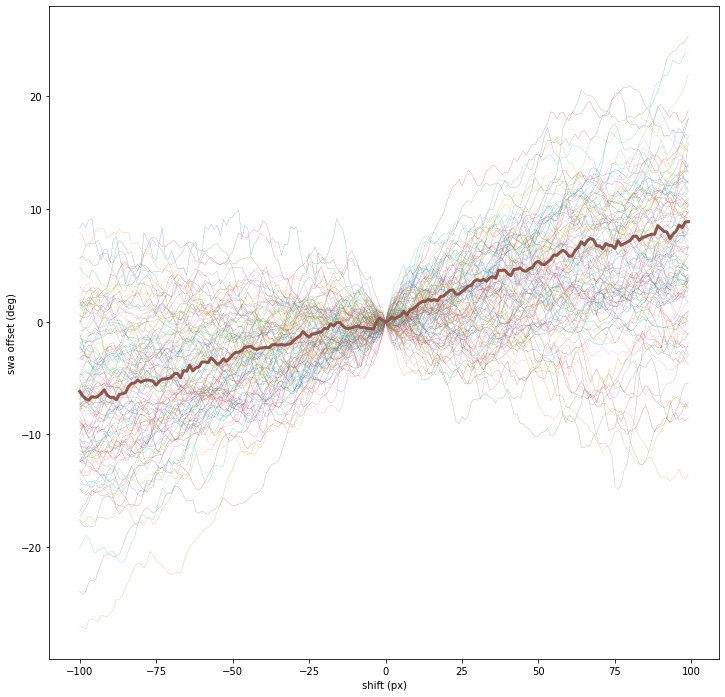

In [20]:
for prediction_list in predictions_lists:
    #plt.plot(shifts, np.asarray(prediction_list), linewidth = 0.5)
    plt.plot(shifts, np.asarray(prediction_list)-prediction_list[len(prediction_list)//2], linewidth = 0.2)

median_predictions = np.median(predictions_lists, axis=0)
plt.plot(shifts, np.asarray(median_predictions)-median_predictions[len(median_predictions)//2], linewidth = 3)

plt.xlabel("shift (px)")
plt.ylabel("swa offset (deg)")
plt.show()



# Lenkrad Winkelgeschwindigkeit

10464
10463


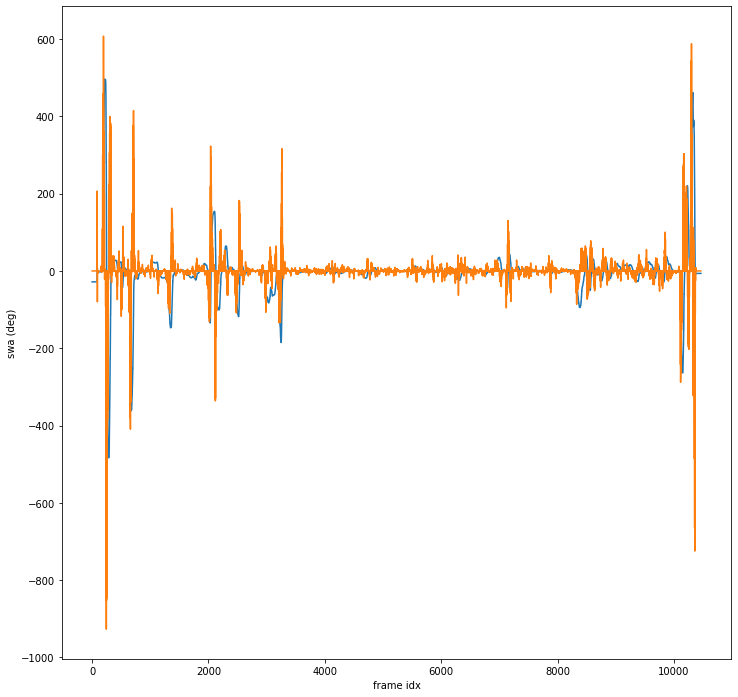

In [64]:
speeds = velocity_list[:]
angles = ground_truth[:] # deg
fps = 15
angular_speed = np.diff(angles)*fps # deg/s


idxs = range(1, len(angles)+1)
print(len(angles))
#print(angles)
print(len(angular_speed))
#print(angular_speed)

plt.plot(idxs, angles)
plt.plot(idxs[:len(angular_speed)], angular_speed)
plt.xlabel("frame idx")
plt.ylabel("swa (deg)")
plt.show()


In [67]:
speeds = np.asarray(speeds)
abs_angles = abs(np.asarray(angles))
abs_angular_speed = abs(angular_speed)

In [70]:
# get indices where abs(swa) > 45
invalid_angle_indxs = np.argwhere(abs_angles>45)

# get indices where speed < 25
invalid_speed_indxs = np.argwhere(speeds[:-1]<25)

In [71]:
# remove samples from angular speed array
abs_angular_speed[invalid_angle_indxs] = 0
abs_angular_speed[invalid_speed_indxs] = 0

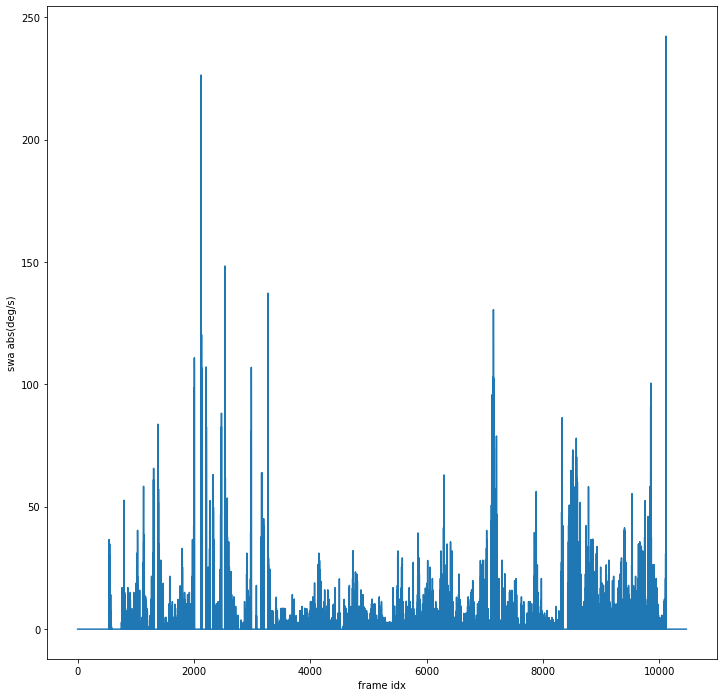

In [72]:
plt.plot(idxs[:len(abs_angular_speed)], abs_angular_speed)
plt.xlabel("frame idx")
plt.ylabel("swa abs(deg/s)")
plt.show()

In [97]:
qs = list(range(60,90,5))
qs.extend(list(range(90,101,1)))

for q in qs:
    print("{}th: {} deg/s".format(q, round(np.percentile(abs_angular_speed, q=q),1)))

60th: 0.0 deg/s
65th: 0.9 deg/s
70th: 1.9 deg/s
75th: 2.9 deg/s
80th: 4.6 deg/s
85th: 7.5 deg/s
90th: 11.2 deg/s
91th: 12.3 deg/s
92th: 14.1 deg/s
93th: 16.1 deg/s
94th: 17.9 deg/s
95th: 21.6 deg/s
96th: 25.3 deg/s
97th: 30.0 deg/s
98th: 37.6 deg/s
99th: 57.2 deg/s
100th: 242.2 deg/s
